# Multi Class: Skin Lesion Classification Using Deep Learning

**Author:** Mohammad Imran Hossain
<br>**Institute:** University of Girona, Erasmus Mundus Joint Master in Medical Imaging and Applications

**Introduction:**
<br>This project is part of a course requirement for the Computer Aided Diagnosis (CAD) module in the Erasmus Mundus Joint Master in Medical Imaging and Applications (MAIA) program at the University of Girona, Spain. The focus is on Skin Lesion Classification using Deep Learning methodologies.

**Dataset Overview:**
<br>The challenge utilizes a comprehensive dataset combining sources from HAM10000 (ViDIR Group, Medical University of Vienna), BCN_20000 (Hospital Clínic de Barcelona), and the MSK Dataset (ISBI 2017). The dataset encompasses three types of skin lesions, offering a diverse range of samples for accurate model training and evaluation.

**Classification Categories:**
<br>Melanoma
<br>Basal Cell Carcinoma
<br>Squamous Cell Carcinoma

**Dataset Distribution:**
<br>Training Data   : 5082
<br>Validation Data : 1270
<br>Testing Data    : 2121

**Approach and Methodology:**
<br>The project will leverage Transfer Learning techniques, utilizing a variety of pre-trained models such as ResNet, RegNet, DenseNet, ResNext, EfficientNet, Swin Transformer, and Vision Transfomer. These models, known for their efficiency in image recognition tasks, will be fine-tuned and evaluated to determine the most effective approach for this specific classification challenge.

**Objective:**
<br>The primary goal is to develop a robust and accurate classification system that can effectively distinguish between the three types of skin lesions. This system aims to aid in the early detection and diagnosis of skin cancer, contributing significantly to medical imaging and computer-aided diagnosis fields.









# Necessary Libraries
- **Import all the necessary libraries.**

In [ ]:
# Basic Python and System Libraries
import sys
import os
import time
import copy
import logging

# Data Handling and Manipulation
import numpy as np
import pandas as pd
from PIL import Image

# Deep Learning and PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torch.autograd import Variable

# Model Architectures and Pre-Trained Models
from torchvision import models
from torchvision.models import efficientnet_b2
from torchvision.models import efficientnet_b4
from torchvision.models import swin_s
from torchvision.models import swin_b
from torchvision.models import swin_t
from torchvision.models import swin_v2_s
from torchvision.models import swin_v2_b
from torchvision.models import regnet_y_32gf

# Model Weights
from torchvision.models._api import WeightsEnum
from torchvision.models import EfficientNet_B2_Weights
from torchvision.models import EfficientNet_B4_Weights
from torchvision.models import Swin_S_Weights
from torchvision.models import Swin_T_Weights
from torchvision.models import Swin_B_Weights
from torchvision.models import Swin_V2_S_Weights
from torchvision.models import Swin_V2_B_Weights
from torchvision.models import RegNet_Y_32GF_Weights

# Image Transformations and Augmentations
import torchvision.transforms as transforms
import albumentations as Alb
from albumentations.pytorch import ToTensorV2

# Metrics and Visualization
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar Utility
from tqdm import tqdm

# Weight Calculation for Imbalanced Classes
from sklearn.utils import class_weight

# Type Hinting for Function Signatures
from typing import Callable

# Mount Colab

- **Mount the google drive with colab.**


In [ ]:
# Mount drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Enviroment
- **Check and set the GPU connected to the remote server.**

In [ ]:
# Check GPU information
!nvidia-smi

# Set CUDA VISIBLE DEVICES to assigned UUID
os.environ["CUDA_VISIBLE_DEVICES"] = 'MIG-c604cc16-2464-5475-9de2-2e4f69e621c0'

# Check for CUDA availability and assign device accordingly
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

Sun Jan  7 15:12:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Exploratory Data Analysis
- **Define the path of the dataset directory.**

In [ ]:
# Define the path of the train, validation, and test dataset directories
TRAIN_DATA_PATH  = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Multi_Class/Dataset/train"
VALID_DATA_PATH  = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Multi_Class/Dataset/val"
TEST_DATA_PATH   = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Multi_Class/Dataset/test"

# Define the path for saving the checkpoint and best model
TENSORBOARD_PATH = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Multi_Class/Tensorboard"

- **Compute the mean and standard deviation of intensites for training dataset.**

In [ ]:
# Function to preprocess image
def preprocess_image(image_path):
    """
    Preprocess an image from the given path.

    Args:
    image_path (str): Path to the image file.

    Returns:
    torch.Tensor: Transformed image as a tensor.
    """
    # Open the image file at the specified path
    image = Image.open(image_path)

    # Define transformations: resize to 256x256 and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    return transform(image)


# Function to calculate the mean and standard deviation of images in a dataset
def calculate_mean_std(data_path):
    """
    Calculate mean and standard deviation of images in a dataset.

    Args:
    data_path (str): Path to the dataset directory.

    Returns:
    tuple: Mean and standard deviation of the dataset images.
    """
    # Initialize variables for mean and standard deviation calculation
    channel_sum, channel_squared_sum = np.zeros(3), np.zeros(3)
    num_images = 0

    # Iterate over each image file in the dataset
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.jpg'):
                # Process each image and update the sum and squared sum
                image_path = os.path.join(root, file)
                img = preprocess_image(image_path)
                channel_sum += torch.mean(img, dim=[1, 2]).numpy()
                channel_squared_sum += torch.mean(img**2, dim=[1, 2]).numpy()
                num_images += 1

    # Calculate the mean and standard deviation
    mean = channel_sum / num_images
    stddev = (channel_squared_sum / num_images - mean**2)**0.5

    return mean, stddev

# Apply the function to calculate mean and std deviation for a dataset
computed_mean, computed_std = calculate_mean_std(TRAIN_DATA_PATH)

# Display the computed mean and standard deviation
print("Training Dataset  :")
print("Mean              :", computed_mean)
print("Standard Deviation:", computed_std)


Training Dataset  :
Mean              : [0.60915693 0.50459815 0.49816272]
Standard Deviation: [0.25096698 0.22856602 0.23785942]


- **Class to load and pre-process the dataset.**

In [ ]:
# Class to load and pre-process the train, validation, and test dataset
class SkinLesionDataset(Dataset):
    def __init__(self, root_dir, img_height, img_width, img_transform=None, augment=False, has_subfolders=True):
        """
        Initializes the SkinLesionDataset object.
        Args:
            root_dir (string): Directory with all the images.
            img_height (int) : The desired image height.
            img_width (int)  : The desired image width.
            img_transform (callable, optional): Optional transform to be applied on a sample.
            augment (boolean): Whether to perform data augmentation or not.
            has_subfolders (boolean): Whether the dataset has subfolders for each class.
        """
        self.root_dir      = root_dir               # Root directory of the dataset
        self.img_height    = img_height             # Image height
        self.img_width     = img_width              # Image width
        self.img_transform = img_transform          # Flag to enable image transformation
        self.augment       = augment                # Flag to enable data augmentation
        self.classes       = ['mel', 'bcc', 'scc']  # Define the classes for skin lesions
        self.file_list     = []                     # Store the file paths and labels
        self.labels        = []                     # Store the labels for each image

        # Load images and labels from subfolders if they exist
        if has_subfolders:
            for index, _class in enumerate(self.classes):
                class_path = os.path.join(self.root_dir, _class)
                for img in os.listdir(class_path):
                    self.file_list.append((os.path.join(class_path, img), index))
                    self.labels.append(index)
        else:
            # Load images without labels if there are no subfolders
            for img in sorted(os.listdir(self.root_dir), key=lambda x: int(x.split('.')[0][-5:])):
                self.file_list.append((img, None))  # None for no label

    def __len__(self):
        # Return the total number of images
        return len(self.file_list)

    def __getitem__(self, idx):
        # Retrieve an image and its label by index
        img_path, label = self.file_list[idx]
        image = np.array(Image.open(img_path).convert('RGB'))

        # Apply data augmentation if enabled
        if self.augment:
            # Define the augmentation pipeline
            aug_transform = Alb.Compose([
                Alb.SmallestMaxSize(max_size=max(self.img_height, self.img_width)),
                Alb.RandomResizedCrop(height=self.img_height, width=self.img_width, scale=(0.4, 1.0), ratio=(0.75, 4/3)),
                Alb.Affine(scale=(0.8, 1.2), rotate=(0.0, 90.0), shear=(0.0, 20.0), p=0.8),
                Alb.Flip(p=0.9),
                Alb.ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.9, 1.1], hue=0.05, p=0.6),
            ])
            image = aug_transform(image=image)['image']

        # Apply standard image transformations
        if self.img_transform:
            image = self.img_transform(Image.fromarray(image))

        # Return image and image path for test data
        if label is None:
            return image, img_path

        return image, label, img_path

    def get_labels(self):
        # Provide the labels of the dataset
        return self.labels

# Define constants for image processing
IMAGE_SIZE = 256             # Size of the image
MU = [0.485, 0.456, 0.406]   # Mean values for normalization
STD = [0.229, 0.224, 0.225]  # Standard deviation values for normalization

# Define the standard image transformations
img_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE+4),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MU, std=STD)
])

# Define image dimensions
IMAGE_HEIGHT = 256
IMAGE_WIDTH  = 256

# Initialize the datasets for training, validation, and testing
train_dataset = SkinLesionDataset(root_dir=TRAIN_DATA_PATH, img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=True,  has_subfolders=True)
val_dataset   = SkinLesionDataset(root_dir=VALID_DATA_PATH, img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=False, has_subfolders=True)
test_dataset  = SkinLesionDataset(root_dir=TEST_DATA_PATH,  img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=False, has_subfolders=True)


- **Function to count the total number of dataset.**

In [ ]:
# Function to count the number of instances for each class in a dataset
def count_classes(dataset):
    """
    Count the number of instances for each class in the dataset.

    Args:
    dataset: A dataset containing labels.

    Returns:
    tuple: Counts of each class.
    """
    # Initialize counters for each class
    mel_count, bcc_count, scc_count = 0, 0, 0
    # Iterate through the dataset and update counts
    for _, label in tqdm(dataset, desc="Counting"):
        if label == 0:
            mel_count += 1
        elif label == 1:
            bcc_count += 1
        elif label == 2:
            scc_count += 1
    return mel_count, bcc_count, scc_count

# Count Instances in the Training Dataset
train_mel_count, train_bcc_count, train_scc_count = count_classes(train_dataset)
# Calculate the total number of training data
train_total = train_mel_count + train_bcc_count + train_scc_count

# Display the count for each class in the training dataset
print("Total Number of Training Data:", train_total)
print("mel:", train_mel_count)
print("bcc:", train_bcc_count)
print("scc:", train_scc_count)

# Count Instances in the Validation Dataset
val_mel_count, val_bcc_count, val_scc_count = count_classes(val_dataset)
# Calculate the total number of validation data
val_total = val_mel_count + val_bcc_count + val_scc_count

# Display the count for each class in the validation dataset
print("\nTotal Number of Validation Data:", val_total)
print("mel:", val_mel_count)
print("bcc:", val_bcc_count)
print("scc:", val_scc_count)


Counting: 100%|██████████| 5082/5082 [02:38<00:00, 32.11it/s]


Total Number of Training Data: 5082
mel: 2713
bcc: 1993
scc: 376




Counting: 100%|██████████| 1270/1270 [05:18<00:00,  3.99it/s]


Total Number of Validation Data: 1270
mel: 678
bcc: 498
scc: 94


- **Get the weight of the each calss of training dataset.**

In [ ]:
# Set the device to CUDA if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Obtain labels from the training dataset
labels = train_dataset.get_labels()

# Compute class weights for balanced training
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=np.array(labels)
)

# Convert class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights).float().to(DEVICE)

# Print class weights
for class_id, weight in zip(np.unique(labels), class_weights):
    print(f"Class ID: {class_id}, Weight: {weight}")

Class ID: 0, Weight: 0.6244010329246521
Class ID: 1, Weight: 0.8499749302864075
Class ID: 2, Weight: 4.505319118499756


- **Function to compute sample count based on sampling technique.**

In [ ]:
# Function to compute sample count based on sampling technique
def get_samples_count(y, sampling_technique):
    """
    Compute the sample count based on the specified sampling technique.

    Args:
    y (array-like): Array of class labels.
    sampling_technique (str): The sampling technique ('mean', 'over', 'under').

    Returns:
    int: Computed sample count.
    """
    # Get unique class labels and their counts
    unique, counts = np.unique(y, return_counts=True)

    # Calculate sample count based on the specified sampling technique
    if sampling_technique == 'mean':
        # Use the mean of counts across classes
        mean_samples = np.mean(counts) * 3
    elif sampling_technique == 'over':
        # Use the maximum count across classes
        mean_samples = np.max(counts) * 3
    elif sampling_technique == 'under':
        # Use the minimum count across classes
        mean_samples = np.min(counts) * 3
    else:
        # Handle invalid sampling technique
        raise Exception("Error: Sampling Technique not implemented")

    # Return the calculated sample count
    return int(mean_samples)

- **Class for imbalance data sampler**

In [ ]:
# Class to balance the dataset
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """
    Sampler for imbalanced datasets.

    Arguments:
    dataset                                : The dataset to sample from.
    indices (list, optional)               : List of indices to sample from. If None, all elements in the dataset are considered.
    num_samples (int, optional)            : The number of samples to draw in each iteration. Defaults to the length of 'indices'.
    callback_get_label (Callable, optional): A function to retrieve the label for a given data point.
                                              If None, the label will be inferred based on the dataset type.
    replacement (bool, optional)           : Whether to sample with replacement. Defaults to True.

    """

    def __init__(self, dataset,
                 indices: list = None,
                 num_samples: int = None,
                 callback_get_label: Callable = None,
                 replacement=True):
        """
        Initialize sampler with dataset and configuration.
        """
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.callback_get_label = callback_get_label
        self.num_samples = len(self.indices) if num_samples is None else num_samples
        self.replacement = replacement

        # Count labels and calculate weights for balancing
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        label_to_count = df["label"].value_counts()
        weights = 1.0 / label_to_count[df["label"]]
        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        """
        Retrieve labels from dataset or using callback.
        """
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        """
        Iterator for weighted sampling of indices.
        """
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, self.replacement))

    def __len__(self):
        """
        Length of sampler equal to number of samples.
        """
        return self.num_samples


- **Configuration for data loaders.**

In [ ]:
# Set batch sizes for training, validation, and test sets
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

# Define the number of workers for DataLoader
NUM_WORKERS = 2

# Create a balanced DataLoader for the training dataset
mean_samples = get_samples_count(train_dataset.get_labels(), 'mean')  # Calculate mean sample count for balanced sampling
data_sampler = ImbalancedDatasetSampler(train_dataset, num_samples=mean_samples, replacement=True)  # Initialize sampler
train_loader_balanced = DataLoader(train_dataset, sampler=data_sampler, num_workers=NUM_WORKERS, batch_size=TRAIN_BATCH_SIZE)  # DataLoader with balanced sampling

In [ ]:
# Define the dataloader for training, validation, and testing dataset
train_loader     = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader       = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_loader      = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

val_loader_shuff = DataLoader(val_dataset, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# Create a combined training and validation dataloader
dataloaders = {"train": train_loader,
              "val": val_loader}

dataloaders_balanced = {"train": train_loader_balanced,
                        "val": val_loader}

# Train Model

- **Function to train the model.**

In [ ]:
# Training function
def train_model(model,
                dataloaders,
                criterion,
                optimizer,
                scheduler,
                checkpoint_path,
                early_stop_patience=10,
                num_epochs=25,
                writer_path='',
                load_checkpoint=None):
    """
    Function to train and validate a PyTorch model.

    Args:
        model              : The PyTorch model to be trained.
        dataloaders        : Dictionary containing 'train' and 'val' DataLoaders.
        criterion          : Loss function.
        optimizer          : Optimization algorithm.
        scheduler          : Learning rate scheduler.
        checkpoint_path    : Path to save the model checkpoints.
        early_stop_patience: Number of epochs to wait for improvement before stopping.
        num_epochs         : Maximum number of epochs for training.
        writer_path        : Path for TensorBoard logging.
        load_checkpoint    : Path of the checkpoint to load the model state from.

    Returns:
        The trained model and a dictionary of training metrics.
    """

    since = time.time()
    best_weights_p = checkpoint_path[:-4] + '_best.pth'

    # Setup TensorBoard writers for train and validation phases
    writers = {
        'train': SummaryWriter(writer_path + '/log'),
        'val': SummaryWriter(writer_path + '/log_val')
    }

    # Initialize best model weights and tracking variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e8
    best_kappa = 0.0
    early_stop_c = 0
    prev_epoch = -1

    # Initialize storage for metrics
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_kappa': [],
        'val_kappa': []
    }

    # Load model from checkpoint if specified
    if load_checkpoint is not None:
        checkpoint = torch.load(load_checkpoint)
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        model.load_state_dict(checkpoint['model_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        criterion = checkpoint['criterion']
        prev_epoch = checkpoint['epoch']
        best_loss = checkpoint['best_loss']
        best_kappa = checkpoint['best_kappa']
        early_stop_c = checkpoint['early_stop_c']

    # Main training loop
    for epoch in range(prev_epoch+1, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_labels = []
            running_preds = []

            # Iterate over data batches
            for batch in tqdm(dataloaders[phase]):
                # Handle different data batch structures
                inputs, labels = batch[:2]
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()  # Reset gradients

                # Forward pass and loss computation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running statistics
                running_loss += loss.item() * inputs.size(0)
                running_labels.extend(labels.int().cpu().tolist())
                running_preds.extend(preds.int().cpu().tolist())

            # Calculate epoch-level metrics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(running_labels, running_preds)
            epoch_kappa = cohen_kappa_score(running_labels, running_preds)

            # Update scheduler and TensorBoard in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)
                lr_ = optimizer.param_groups[0]['lr']
                writers['train'].add_scalar('info/lr', lr_, epoch)

            # Log epoch-level metrics
            logging.info(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}, kappa: {epoch_kappa:.4f}')

            # Save metrics to TensorBoard
            writers[phase].add_scalar('info/loss', epoch_loss, epoch)
            writers[phase].add_scalar('info/acc', epoch_acc, epoch)
            writers[phase].add_scalar('info/kappa', epoch_kappa, epoch)

            # Store metrics for analysis
            if phase == 'train':
                metrics['train_loss'].append(epoch_loss)
                metrics['train_acc'].append(epoch_acc)
                metrics['train_kappa'].append(epoch_kappa)
            else:
                metrics['val_loss'].append(epoch_loss)
                metrics['val_acc'].append(epoch_acc)
                metrics['val_kappa'].append(epoch_kappa)

            # Check and update best model weights
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                early_stop_c = 0
            else:
                early_stop_c += 1

            if phase == 'val' and epoch_kappa > best_kappa:
                best_kappa = epoch_kappa
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, best_weights_p)

        # Save checkpoint after each epoch
        torch.save({
            'model_state': model.state_dict(),
            'criterion': criterion,
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'epoch': epoch,
            'best_loss': best_loss,
            'best_kappa': best_kappa,
            'early_stop_c': early_stop_c
        }, checkpoint_path)

        # Early stopping condition
        if early_stop_c > early_stop_patience:
            print(f'EARLY STOP AFTER {epoch + 1} EPOCHS')
            break

        print()

    # Print final training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f"Best val Kappa: {best_kappa}")

    # Load best model weights and close TensorBoard writers
    model.load_state_dict(best_model_wts)
    writers['train'].close()
    writers['val'].close()

    return model, metrics


# Predict Model
- **Function to predict the model.**

In [ ]:
# Function to predict the model
def test_model(model, loader, device, criterion):
    """
    Function to evaluate a model on a test dataset.

    Args:
        model: The PyTorch model to be evaluated.
        loader: DataLoader for the test dataset.
        device: Device to run the model on ('cpu' or 'cuda').
        criterion: Loss function used for evaluation.

    Returns:
        Test loss, accuracy, kappa score, labels, predictions, and probabilities.
    """
    since = time.time()

    model.eval()  # Set model to evaluation mode

    # Initialize variables to track test metrics
    running_loss = 0.0
    running_corrects = 0
    running_labels = []
    running_preds = []
    running_probs = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(loader):
            # Unpack the batch
            inputs, labels = batch[:2]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            probs = F.softmax(outputs, dim=1)  # Get class probabilities

            # Compute loss for the batch
            loss = criterion(outputs, labels)

            # Accumulate metrics over the dataset
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_labels.extend(labels.cpu().numpy())
            running_preds.extend(preds.cpu().numpy())
            running_probs.extend(probs.cpu().numpy())

    # Calculate overall test metrics
    test_loss = running_loss / len(loader.dataset)
    test_acc = running_corrects.double() / len(loader.dataset)
    test_kappa = cohen_kappa_score(running_labels, running_preds)  # Calculate Cohen's kappa

    # Print test summary
    time_elapsed = time.time() - since
    print(f'\nTest Loss: {test_loss:.4f} Acc: {test_acc:.4f}, Kappa: {test_kappa:.4f}')
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    model.train()  # Set the model back to training mode

    return test_loss, test_acc, test_kappa, running_labels, running_preds, running_probs


# Focal Loss
- **Class for focal loss.**

In [ ]:
# Class for local loss
class FocalLoss(nn.Module):
    """
    Focal Loss for Dense Object Detection.

    Args:
        gamma (float): Focusing parameter to adjust the rate at which easy examples are down-weighted.
        alpha (float or list): Class balancing parameter. If a list, it should have the same length as the number of classes.
        size_average (bool): If True, the loss is averaged over the batch, else summed.
    """
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma  # Focusing parameter
        self.alpha = alpha  # Class weighting parameter
        # Convert alpha to a tensor if it's a number or a list
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        """
        Forward pass for the focal loss calculation.

        Args:
            input: Predictions from the model (before softmax).
            target: Ground truth labels.

        Returns:
            Computed focal loss.
        """
        # Reshape input if necessary
        if input.dim() > 2:
            # Transform input to 2D if it's more than 2D
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)  # Reshape target to 2D

        # Calculate log probability
        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1, target)  # Gather log probabilities with respect to target labels
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())  # Convert log probabilities to probabilities

        # Apply alpha weighting if provided
        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        # Compute the final focal loss
        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()  # Return mean loss if size_average is True
        else:
            return loss.sum()  # Return sum of the loss if size_average is False


# Vizualizatoin

In [ ]:
# Function to visualize the summary (training and validation loss and accuracy)
def plot_summary(metrics):
    """
    Plots the training and validation loss and accuracy over epochs.

    Args:
        metrics (dict): Dictionary containing 'train_loss', 'val_loss', 'train_acc', 'val_acc' lists.
    """

    # Unpack metrics for loss and accuracy from the provided dictionary
    train_loss = metrics['train_loss']
    val_loss   = metrics['val_loss']
    train_acc  = metrics['train_acc']
    val_acc    = metrics['val_acc']

    # Create subplots: one for loss and one for accuracy
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    axs[0].plot(train_loss, label='Train Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(train_acc, label='Train Accuracy')
    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Display the plots
    plt.show()


In [ ]:
# Function to plot confusion metrics and ROC curve
def plot_evaluation_metrics(y_true, y_probs, class_names=None):
    """
    Plots the confusion matrix and Receiver Operating Characteristic (ROC) curve for evaluation.

    Args:
        y_true: Array of true labels.
        y_probs: Array of predicted probabilities for each class.
        class_names: List of class names corresponding to the labels.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_probs, axis=1))
    plt.figure(figsize=(10, 5))
    print('\n')

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Prepare data for ROC curve
    n_classes = len(class_names) if class_names else len(np.unique(y_true))  #
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# ResNet 34 [Focal Loss]


In [ ]:
# Configure logging to write messages to a file and also print them to stdout.
logging.basicConfig(filename="/home/cad05/CADx/Skin-Lesion-Classification-Deep-Learning/Multi_Class_Challenge/Tensorboard/ResNet34/resnet34_fl.txt",
                    level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s',
                    datefmt='%H:%M:%S',
                    force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Path for Tensorboard logs
writer_path = '/home/cad05/CADx/Skin-Lesion-Classification-Deep-Learning/Multi_Class_Challenge/Tensorboard'

# Number of classes in the dataset
num_classes = 3

# Load a pre-trained ResNet-34 model
resnet34_model = models.resnet34(pretrained=True)

# Modify the last layer of the model to have the same number of outputs as there are classes
num_ftrs = resnet34_model.fc.in_features
resnet34_model.fc = nn.Linear(num_ftrs, num_classes)

# Device configuration - uses GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnet34_model = resnet34_model.to(DEVICE)

# Hyperparameters
LR = 1e-4             # Learning rate
LR_PATIENCE = 7       # Patience for LR reduction
ES_PATIENCE = 12      # Patience for early stopping
EPOCHS = 100          # Number of training epochs
WD = 1e-6             # Weight decay for regularization

# Loss function (Focal Loss in this case, suitable for class imbalance)
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

# Optimizer (Adam)
optimizer = optim.Adam(resnet34_model.parameters(), lr = LR, weight_decay=WD)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

# Dataset sizes for training and validation sets
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
}

# Clearing the GPU cache
torch.cuda.empty_cache()

# Checkpoint path for saving the model
checkpoint_p = '/home/cad05/CADx/Skin-Lesion-Classification-Deep-Learning/Multi_Class_Challenge/Tensorboard/ResNet34/resnet34_fl_checkpoint.pth'

# Train the model
resnet = train_model(resnet34_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.24it/s]

train loss : 0.3907, acc: 0.6013, kappa: 0.3808



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2823, acc: 0.7362, kappa: 0.5625



Epoch 2/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]


train loss : 0.2967, acc: 0.6885, kappa: 0.5021


100%|██████████| 40/40 [00:18<00:00,  2.18it/s]

val loss : 0.2491, acc: 0.8150, kappa: 0.6744



Epoch 3/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.44it/s]

train loss : 0.2598, acc: 0.7460, kappa: 0.5806



100%|██████████| 40/40 [00:20<00:00,  1.97it/s]

val loss : 0.2584, acc: 0.6402, kappa: 0.4543



Epoch 4/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.68it/s]

train loss : 0.2544, acc: 0.7387, kappa: 0.5712



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2148, acc: 0.7685, kappa: 0.6112



Epoch 5/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.2234, acc: 0.7686, kappa: 0.6158



100%|██████████| 40/40 [00:19<00:00,  2.07it/s]

val loss : 0.2110, acc: 0.7551, kappa: 0.5950



Epoch 6/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.58it/s]

train loss : 0.2362, acc: 0.7538, kappa: 0.5943



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.1926, acc: 0.8134, kappa: 0.6816



Epoch 7/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.59it/s]

train loss : 0.2138, acc: 0.7737, kappa: 0.6233



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.1854, acc: 0.7764, kappa: 0.6327



Epoch 8/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.48it/s]


train loss : 0.2288, acc: 0.7767, kappa: 0.6272


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.2155, acc: 0.7173, kappa: 0.5544



Epoch 9/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.2105, acc: 0.7853, kappa: 0.6407



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.1822, acc: 0.8236, kappa: 0.6988



Epoch 10/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.66it/s]

train loss : 0.2001, acc: 0.8005, kappa: 0.6644



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2251, acc: 0.7811, kappa: 0.6310



Epoch 11/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.58it/s]


train loss : 0.2037, acc: 0.7900, kappa: 0.6485


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.2475, acc: 0.7787, kappa: 0.6278



Epoch 12/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.59it/s]

train loss : 0.1863, acc: 0.8107, kappa: 0.6806



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.1704, acc: 0.8409, kappa: 0.7278



Epoch 13/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]

train loss : 0.1843, acc: 0.8184, kappa: 0.6919



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.1857, acc: 0.8157, kappa: 0.6896



Epoch 14/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.1809, acc: 0.8154, kappa: 0.6889



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.1800, acc: 0.8630, kappa: 0.7595



Epoch 15/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.51it/s]


train loss : 0.1739, acc: 0.8207, kappa: 0.6967


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.1722, acc: 0.8307, kappa: 0.7103



Epoch 16/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.1684, acc: 0.8235, kappa: 0.7004



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.1849, acc: 0.8307, kappa: 0.7068



Epoch 17/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.66it/s]

train loss : 0.1833, acc: 0.8101, kappa: 0.6802



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.1976, acc: 0.8102, kappa: 0.6712



Epoch 18/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.1646, acc: 0.8325, kappa: 0.7152



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2292, acc: 0.8118, kappa: 0.6732



Epoch 19/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.47it/s]

train loss : 0.1579, acc: 0.8327, kappa: 0.7142



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.1388, acc: 0.8614, kappa: 0.7622



Epoch 20/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.1543, acc: 0.8268, kappa: 0.7063



100%|██████████| 40/40 [00:19<00:00,  2.04it/s]

val loss : 0.1755, acc: 0.8543, kappa: 0.7472



Epoch 21/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.1598, acc: 0.8341, kappa: 0.7186



100%|██████████| 40/40 [00:20<00:00,  1.95it/s]

val loss : 0.1968, acc: 0.7858, kappa: 0.6424



Epoch 22/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.48it/s]

train loss : 0.1598, acc: 0.8329, kappa: 0.7164



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.1884, acc: 0.8362, kappa: 0.7209



Epoch 23/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.1483, acc: 0.8436, kappa: 0.7320



100%|██████████| 40/40 [00:20<00:00,  1.99it/s]

val loss : 0.2514, acc: 0.8047, kappa: 0.6614



Epoch 24/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.51it/s]

train loss : 0.1478, acc: 0.8412, kappa: 0.7283



100%|██████████| 40/40 [00:19<00:00,  2.04it/s]

val loss : 0.1695, acc: 0.8654, kappa: 0.7631



Epoch 25/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.67it/s]

train loss : 0.1296, acc: 0.8638, kappa: 0.7657



100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

val loss : 0.1858, acc: 0.8630, kappa: 0.7611



Epoch 26/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.1472, acc: 0.8459, kappa: 0.7370



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.1466, acc: 0.8709, kappa: 0.7756



Epoch 27/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]


train loss : 0.1472, acc: 0.8465, kappa: 0.7372


100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2035, acc: 0.8213, kappa: 0.6893



Epoch 28/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.1277, acc: 0.8754, kappa: 0.7842



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.1389, acc: 0.8567, kappa: 0.7544



Epoch 29/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.69it/s]

train loss : 0.1067, acc: 0.8922, kappa: 0.8121



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.1383, acc: 0.8709, kappa: 0.7764



Epoch 30/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.50it/s]

train loss : 0.0975, acc: 0.8959, kappa: 0.8185



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.1280, acc: 0.8929, kappa: 0.8139



Epoch 31/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.0887, acc: 0.9059, kappa: 0.8354



100%|██████████| 40/40 [00:19<00:00,  2.03it/s]

val loss : 0.1309, acc: 0.8882, kappa: 0.8059



Epoch 32/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.40it/s]

train loss : 0.0831, acc: 0.9071, kappa: 0.8373



100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

val loss : 0.1232, acc: 0.8858, kappa: 0.8035



Epoch 33/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.0806, acc: 0.9115, kappa: 0.8447



100%|██████████| 40/40 [00:18<00:00,  2.21it/s]

val loss : 0.1206, acc: 0.8929, kappa: 0.8144



Epoch 34/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.0741, acc: 0.9179, kappa: 0.8562



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.1281, acc: 0.8961, kappa: 0.8179



Epoch 35/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.0694, acc: 0.9191, kappa: 0.8579



100%|██████████| 40/40 [00:20<00:00,  1.96it/s]

val loss : 0.1281, acc: 0.9118, kappa: 0.8440



Epoch 36/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.0660, acc: 0.9254, kappa: 0.8686



100%|██████████| 40/40 [00:19<00:00,  2.06it/s]

val loss : 0.1307, acc: 0.9157, kappa: 0.8512



Epoch 37/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.0662, acc: 0.9231, kappa: 0.8645



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.1309, acc: 0.9087, kappa: 0.8385



Epoch 38/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.60it/s]

train loss : 0.0618, acc: 0.9254, kappa: 0.8689



100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

val loss : 0.1414, acc: 0.9079, kappa: 0.8377



Epoch 39/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.0648, acc: 0.9250, kappa: 0.8679



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.1377, acc: 0.9031, kappa: 0.8299



Epoch 40/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.45it/s]


train loss : 0.0660, acc: 0.9227, kappa: 0.8639


100%|██████████| 40/40 [00:18<00:00,  2.13it/s]

val loss : 0.1356, acc: 0.9071, kappa: 0.8362



Epoch 41/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.0621, acc: 0.9317, kappa: 0.8795



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.1336, acc: 0.9087, kappa: 0.8387



Epoch 42/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.48it/s]

train loss : 0.0603, acc: 0.9233, kappa: 0.8656



100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

val loss : 0.1300, acc: 0.9094, kappa: 0.8400



Epoch 43/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]


train loss : 0.0618, acc: 0.9270, kappa: 0.8714


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.1389, acc: 0.9102, kappa: 0.8404



Epoch 44/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.0583, acc: 0.9262, kappa: 0.8702



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.1335, acc: 0.9047, kappa: 0.8321



Epoch 45/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.47it/s]

train loss : 0.0546, acc: 0.9329, kappa: 0.8818



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.1396, acc: 0.9118, kappa: 0.8439



Epoch 46/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.0565, acc: 0.9362, kappa: 0.8874



100%|██████████| 40/40 [00:19<00:00,  2.05it/s]

val loss : 0.1371, acc: 0.9102, kappa: 0.8405


EARLY STOP AFTER 46 EPOCHS
Training complete in 72m 21s
Best val loss: 0.120562
Best val Kappa: 0.8512183692596064


In [ ]:
# Load the ResNet-34 model without pre-trained weights
resnet34_model_predict = models.resnet34(pretrained=False)

# Modify the last layer to match the number of classes
num_ftrs = resnet34_model_predict.fc.in_features
resnet34_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the appropriate device
resnet34_model_predict = resnet34_model_predict.to(DEVICE)

# Load the best model checkpoint
best_model_path = TENSORBOARD_PATH + '/resnet34_checkpoint_best.pth'
resnet34_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa = test_model(resnet34_model_predict, val_loader, DEVICE, criterion)


100%|██████████| 40/40 [00:19<00:00,  2.06it/s]

Test Loss: 0.1518 Acc: 0.9181, kappa: 0.8524
Testing complete in 0m 19s


# ResNet 34 [Weighted Cross Entropy]

In [ ]:
# Clearing the GPU cache to free up memory and avoid potential issues
torch.cuda.empty_cache()

# Setting up logging to both a file and stdout for monitoring the training process
logging.basicConfig(filename=TENSORBOARD_PATH + '/ResNet34/resnet34_wce.txt', level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Define the path for saving Tensorboard logs
writer_path = TENSORBOARD_PATH + '/ResNet34'

# Number of target classes in the dataset
num_classes = 3

# Load a pre-trained ResNet-34 model for transfer learning
resnet34_model = models.resnet34(pretrained=True)

# Modify the last layer of the model for the specific number of classes
num_ftrs = resnet34_model.fc.in_features
resnet34_model.fc = nn.Linear(num_ftrs, num_classes)

# Device configuration for training (GPU or CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnet34_model = resnet34_model.to(DEVICE)

# Training parameters
LR = 1e-4             # Learning rate
LR_PATIENCE = 7       # Learning rate scheduler patience
ES_PATIENCE = 12      # Early stopping patience
EPOCHS = 100          # Total number of training epochs
WD = 1e-6             # Weight decay for regularization

# Loss function with class weights for handling imbalanced data
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer setup
optimizer = optim.Adam(resnet34_model.parameters(), lr=LR, weight_decay=WD)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Sizes of training and validation datasets
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
}

# Path for saving the training checkpoint
checkpoint_p = TENSORBOARD_PATH + '/ResNet34/resnet34_wce_checkpoint.pth'

# Training the model
resnet = train_model(resnet34_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p,
                     early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.38it/s]

train loss : 0.8248, acc: 0.6802, kappa: 0.4749



100%|██████████| 40/40 [00:18<00:00,  2.20it/s]

val loss : 0.5387, acc: 0.7661, kappa: 0.6096



Epoch 2/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.46it/s]

train loss : 0.7083, acc: 0.7391, kappa: 0.5619



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.4772, acc: 0.8165, kappa: 0.6778



Epoch 3/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.57it/s]

train loss : 0.6468, acc: 0.7625, kappa: 0.5999



100%|██████████| 40/40 [00:19<00:00,  2.07it/s]

val loss : 0.4552, acc: 0.8063, kappa: 0.6606



Epoch 4/100
---------------


100%|██████████| 318/318 [01:13<00:00,  4.35it/s]

train loss : 0.6103, acc: 0.7869, kappa: 0.6381



100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

val loss : 0.4204, acc: 0.8535, kappa: 0.7395



Epoch 5/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.50it/s]

train loss : 0.5810, acc: 0.7930, kappa: 0.6469



100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

val loss : 0.4979, acc: 0.7913, kappa: 0.6506



Epoch 6/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.45it/s]

train loss : 0.5731, acc: 0.7977, kappa: 0.6528



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.4606, acc: 0.8157, kappa: 0.6910



Epoch 7/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.5433, acc: 0.8101, kappa: 0.6744



100%|██████████| 40/40 [00:22<00:00,  1.82it/s]

val loss : 0.4220, acc: 0.8323, kappa: 0.7110



Epoch 8/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.5204, acc: 0.8085, kappa: 0.6731



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.4361, acc: 0.8244, kappa: 0.7038



Epoch 9/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.51it/s]

train loss : 0.5030, acc: 0.8243, kappa: 0.6979



100%|██████████| 40/40 [00:22<00:00,  1.82it/s]

val loss : 0.4198, acc: 0.8441, kappa: 0.7209



Epoch 10/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.73it/s]

train loss : 0.4859, acc: 0.8323, kappa: 0.7112



100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.4913, acc: 0.8520, kappa: 0.7437



Epoch 11/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.74it/s]

train loss : 0.4789, acc: 0.8221, kappa: 0.6946



100%|██████████| 40/40 [00:19<00:00,  2.02it/s]

val loss : 0.4511, acc: 0.8173, kappa: 0.6829



Epoch 12/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.79it/s]

train loss : 0.4686, acc: 0.8304, kappa: 0.7086



100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

val loss : 0.3468, acc: 0.8740, kappa: 0.7793



Epoch 13/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.58it/s]

train loss : 0.4511, acc: 0.8396, kappa: 0.7231



100%|██████████| 40/40 [00:22<00:00,  1.79it/s]

val loss : 0.3724, acc: 0.8567, kappa: 0.7478



Epoch 14/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.37it/s]

train loss : 0.4317, acc: 0.8455, kappa: 0.7341



100%|██████████| 40/40 [00:15<00:00,  2.63it/s]

val loss : 0.4317, acc: 0.8370, kappa: 0.7120



Epoch 15/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.4487, acc: 0.8473, kappa: 0.7366



100%|██████████| 40/40 [00:18<00:00,  2.19it/s]

val loss : 0.4066, acc: 0.8433, kappa: 0.7282



Epoch 16/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.61it/s]

train loss : 0.4065, acc: 0.8571, kappa: 0.7527



100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

val loss : 0.4232, acc: 0.8528, kappa: 0.7322



Epoch 17/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.41it/s]

train loss : 0.4169, acc: 0.8534, kappa: 0.7468



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.3259, acc: 0.8772, kappa: 0.7784



Epoch 18/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.47it/s]

train loss : 0.3966, acc: 0.8609, kappa: 0.7589



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.3787, acc: 0.8449, kappa: 0.7305



Epoch 19/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.38it/s]

train loss : 0.3758, acc: 0.8627, kappa: 0.7624



100%|██████████| 40/40 [00:19<00:00,  2.00it/s]

val loss : 0.3608, acc: 0.8551, kappa: 0.7503



Epoch 20/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.68it/s]

train loss : 0.3644, acc: 0.8723, kappa: 0.7778



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.3462, acc: 0.8787, kappa: 0.7864



Epoch 21/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.3732, acc: 0.8713, kappa: 0.7767



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.3190, acc: 0.8921, kappa: 0.8095



Epoch 22/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.53it/s]

train loss : 0.3355, acc: 0.8760, kappa: 0.7841



100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

val loss : 0.3543, acc: 0.8685, kappa: 0.7687



Epoch 23/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.45it/s]

train loss : 0.3726, acc: 0.8674, kappa: 0.7701



100%|██████████| 40/40 [00:18<00:00,  2.17it/s]

val loss : 0.2854, acc: 0.8969, kappa: 0.8163



Epoch 24/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]

train loss : 0.3383, acc: 0.8833, kappa: 0.7967



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.3202, acc: 0.8772, kappa: 0.7856



Epoch 25/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.92it/s]

train loss : 0.3555, acc: 0.8786, kappa: 0.7891



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.3031, acc: 0.8937, kappa: 0.8132



Epoch 26/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.54it/s]

train loss : 0.3534, acc: 0.8790, kappa: 0.7890



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.3383, acc: 0.8740, kappa: 0.7769



Epoch 27/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.84it/s]

train loss : 0.3130, acc: 0.8918, kappa: 0.8104



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.3067, acc: 0.8866, kappa: 0.7977



Epoch 28/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]

train loss : 0.3150, acc: 0.8867, kappa: 0.8014



100%|██████████| 40/40 [00:18<00:00,  2.11it/s]

val loss : 0.3378, acc: 0.8732, kappa: 0.7776



Epoch 29/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]

train loss : 0.3165, acc: 0.8932, kappa: 0.8129



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.3648, acc: 0.8709, kappa: 0.7726



Epoch 30/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.59it/s]

train loss : 0.2891, acc: 0.8926, kappa: 0.8119



100%|██████████| 40/40 [00:17<00:00,  2.26it/s]

val loss : 0.4092, acc: 0.8606, kappa: 0.7548



Epoch 31/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.47it/s]

train loss : 0.2849, acc: 0.8991, kappa: 0.8231



100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

val loss : 0.2865, acc: 0.9016, kappa: 0.8250



Epoch 32/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.51it/s]

train loss : 0.2272, acc: 0.9256, kappa: 0.8685



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2483, acc: 0.9126, kappa: 0.8448



Epoch 33/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.52it/s]

train loss : 0.1925, acc: 0.9335, kappa: 0.8824



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2403, acc: 0.9173, kappa: 0.8527



Epoch 34/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.43it/s]

train loss : 0.1782, acc: 0.9355, kappa: 0.8859



100%|██████████| 40/40 [00:18<00:00,  2.19it/s]

val loss : 0.2519, acc: 0.9150, kappa: 0.8494



Epoch 35/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.86it/s]

train loss : 0.1821, acc: 0.9376, kappa: 0.8895



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2352, acc: 0.9220, kappa: 0.8618



Epoch 36/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]


train loss : 0.1619, acc: 0.9412, kappa: 0.8955


100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

val loss : 0.2288, acc: 0.9307, kappa: 0.8757



Epoch 37/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.44it/s]

train loss : 0.1541, acc: 0.9459, kappa: 0.9040



100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

val loss : 0.2239, acc: 0.9260, kappa: 0.8676



Epoch 38/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.41it/s]

train loss : 0.1546, acc: 0.9453, kappa: 0.9025



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2392, acc: 0.9213, kappa: 0.8599



Epoch 39/100
---------------


100%|██████████| 318/318 [01:10<00:00,  4.50it/s]

train loss : 0.1539, acc: 0.9475, kappa: 0.9068



100%|██████████| 40/40 [00:22<00:00,  1.79it/s]

val loss : 0.2513, acc: 0.9157, kappa: 0.8490



Epoch 40/100
---------------


100%|██████████| 318/318 [01:12<00:00,  4.38it/s]

train loss : 0.1566, acc: 0.9459, kappa: 0.9038



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.2432, acc: 0.9244, kappa: 0.8637



Epoch 41/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.44it/s]


train loss : 0.1480, acc: 0.9461, kappa: 0.9043


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.2383, acc: 0.9228, kappa: 0.8616



Epoch 42/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]

train loss : 0.1414, acc: 0.9532, kappa: 0.9167



100%|██████████| 40/40 [00:18<00:00,  2.17it/s]

val loss : 0.2426, acc: 0.9236, kappa: 0.8636



Epoch 43/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.61it/s]

train loss : 0.1298, acc: 0.9524, kappa: 0.9152



100%|██████████| 40/40 [00:19<00:00,  2.01it/s]

val loss : 0.2343, acc: 0.9276, kappa: 0.8697



Epoch 44/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.74it/s]

train loss : 0.1219, acc: 0.9547, kappa: 0.9194



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2463, acc: 0.9244, kappa: 0.8633



Epoch 45/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.46it/s]

train loss : 0.1359, acc: 0.9526, kappa: 0.9156



100%|██████████| 40/40 [00:22<00:00,  1.78it/s]

val loss : 0.2331, acc: 0.9331, kappa: 0.8798



Epoch 46/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.88it/s]


train loss : 0.1309, acc: 0.9551, kappa: 0.9202


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2275, acc: 0.9307, kappa: 0.8753



Epoch 47/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.66it/s]

train loss : 0.1287, acc: 0.9547, kappa: 0.9194



100%|██████████| 40/40 [00:18<00:00,  2.12it/s]

val loss : 0.2255, acc: 0.9354, kappa: 0.8843



Epoch 48/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.43it/s]

train loss : 0.1231, acc: 0.9557, kappa: 0.9212



100%|██████████| 40/40 [00:19<00:00,  2.09it/s]

val loss : 0.2367, acc: 0.9291, kappa: 0.8727



Epoch 49/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.60it/s]

train loss : 0.1233, acc: 0.9575, kappa: 0.9242



100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

val loss : 0.2373, acc: 0.9315, kappa: 0.8778



Epoch 50/100
---------------


100%|██████████| 318/318 [01:11<00:00,  4.47it/s]

train loss : 0.1249, acc: 0.9604, kappa: 0.9294



100%|██████████| 40/40 [00:21<00:00,  1.84it/s]

val loss : 0.2352, acc: 0.9299, kappa: 0.8746


EARLY STOP AFTER 50 EPOCHS
Training complete in 77m 17s
Best val loss: 0.223871
Best val Kappa: 0.8842791169032052


In [ ]:
# Load ResNet-34 model
resnet34_model_predict = models.resnet34(pretrained=False)

# Modify the last layer for the number of classes
num_ftrs = resnet34_model_predict.fc.in_features
resnet34_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU or CPU
resnet34_model_predict = resnet34_model_predict.to(DEVICE)

# Load the best model checkpoint
best_model_path = TENSORBOARD_PATH + '/ResNet34/resnet34_wce_checkpoint_best.pth'
resnet34_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa = test_model(resnet34_model_predict, val_loader, DEVICE, criterion)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

Test Loss: 0.2255 Acc: 0.9354, kappa: 0.8843
Testing complete in 0m 21s


# ResNet 34 [Sampler Cross Entropy]


In [ ]:
torch.cuda.empty_cache()

logging.basicConfig(filename=TENSORBOARD_PATH + '/ResNet34/resnet34_ces.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH + '/ResNet34'

# Assuming you have 3 classes
num_classes = 3

# Load the pre-trained ResNet-34 model
resnet34_model = models.resnet34(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnet34_model.fc.in_features
resnet34_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
resnet34_model = resnet34_model.to(DEVICE)

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12

EPOCHS = 100
WD = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet34_model.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

#number of samples in each set
dataset_sizes = {
    'train': mean_samples,
    'val':len(val_dataset),
}



checkpoint_p = TENSORBOARD_PATH +'/ResNet34/resnet34_ces_checkpoint.pth'

resnet = train_model(resnet34_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.05it/s]

train loss : 0.8113, acc: 0.6802, kappa: 0.4757



100%|██████████| 40/40 [00:20<00:00,  1.96it/s]

val loss : 0.6227, acc: 0.7567, kappa: 0.5753



Epoch 2/100
---------------


100%|██████████| 318/318 [00:53<00:00,  5.90it/s]

train loss : 0.6792, acc: 0.7426, kappa: 0.5702



100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

val loss : 0.5849, acc: 0.7512, kappa: 0.5921



Epoch 3/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.87it/s]

train loss : 0.6422, acc: 0.7767, kappa: 0.6201



100%|██████████| 40/40 [00:13<00:00,  2.90it/s]

val loss : 0.5563, acc: 0.7457, kappa: 0.5894



Epoch 4/100
---------------


100%|██████████| 318/318 [01:03<00:00,  5.02it/s]

train loss : 0.6036, acc: 0.7808, kappa: 0.6287



100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

val loss : 0.5430, acc: 0.7583, kappa: 0.6138



Epoch 5/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.85it/s]

train loss : 0.5712, acc: 0.7869, kappa: 0.6389



100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.4312, acc: 0.8244, kappa: 0.7013



Epoch 6/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.74it/s]

train loss : 0.5422, acc: 0.8079, kappa: 0.6721



100%|██████████| 40/40 [00:19<00:00,  2.05it/s]

val loss : 0.4650, acc: 0.8173, kappa: 0.6907



Epoch 7/100
---------------


100%|██████████| 318/318 [00:58<00:00,  5.41it/s]

train loss : 0.5452, acc: 0.7967, kappa: 0.6542



100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

val loss : 0.5232, acc: 0.7780, kappa: 0.6377



Epoch 8/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.71it/s]

train loss : 0.5243, acc: 0.8115, kappa: 0.6787



100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

val loss : 0.4657, acc: 0.8157, kappa: 0.6838



Epoch 9/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.73it/s]

train loss : 0.5080, acc: 0.8241, kappa: 0.6981



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.4337, acc: 0.8252, kappa: 0.7080



Epoch 10/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.75it/s]

train loss : 0.4913, acc: 0.8253, kappa: 0.7009



100%|██████████| 40/40 [00:13<00:00,  2.91it/s]

val loss : 0.4082, acc: 0.8307, kappa: 0.7025



Epoch 11/100
---------------


100%|██████████| 318/318 [00:48<00:00,  6.56it/s]

train loss : 0.4722, acc: 0.8408, kappa: 0.7247



100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.3522, acc: 0.8622, kappa: 0.7589



Epoch 12/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.70it/s]

train loss : 0.4695, acc: 0.8388, kappa: 0.7215



100%|██████████| 40/40 [00:20<00:00,  1.96it/s]

val loss : 0.3715, acc: 0.8480, kappa: 0.7389



Epoch 13/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.75it/s]

train loss : 0.4397, acc: 0.8461, kappa: 0.7338



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.3286, acc: 0.8795, kappa: 0.7893



Epoch 14/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.75it/s]

train loss : 0.4424, acc: 0.8442, kappa: 0.7327



100%|██████████| 40/40 [00:13<00:00,  2.99it/s]

val loss : 0.4808, acc: 0.8189, kappa: 0.6978



Epoch 15/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.77it/s]

train loss : 0.4122, acc: 0.8506, kappa: 0.7418



100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.3705, acc: 0.8756, kappa: 0.7751



Epoch 16/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.73it/s]

train loss : 0.4130, acc: 0.8564, kappa: 0.7512



100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

val loss : 0.4883, acc: 0.8197, kappa: 0.6993



Epoch 17/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.80it/s]

train loss : 0.4238, acc: 0.8457, kappa: 0.7343



100%|██████████| 40/40 [00:20<00:00,  1.95it/s]

val loss : 0.4682, acc: 0.8260, kappa: 0.6985



Epoch 18/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.74it/s]

train loss : 0.4087, acc: 0.8463, kappa: 0.7354



100%|██████████| 40/40 [00:18<00:00,  2.15it/s]

val loss : 0.3901, acc: 0.8598, kappa: 0.7549



Epoch 19/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.92it/s]

train loss : 0.3960, acc: 0.8548, kappa: 0.7490



100%|██████████| 40/40 [00:14<00:00,  2.73it/s]

val loss : 0.3499, acc: 0.8795, kappa: 0.7892



Epoch 20/100
---------------


100%|██████████| 318/318 [00:53<00:00,  5.90it/s]

train loss : 0.3855, acc: 0.8630, kappa: 0.7616



100%|██████████| 40/40 [00:20<00:00,  1.97it/s]

val loss : 0.3714, acc: 0.8614, kappa: 0.7599



Epoch 21/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.70it/s]

train loss : 0.3676, acc: 0.8715, kappa: 0.7767



100%|██████████| 40/40 [00:14<00:00,  2.71it/s]

val loss : 0.3402, acc: 0.8764, kappa: 0.7857



Epoch 22/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.80it/s]

train loss : 0.3083, acc: 0.8933, kappa: 0.8141



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.3065, acc: 0.8835, kappa: 0.7965



Epoch 23/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.82it/s]

train loss : 0.2475, acc: 0.9122, kappa: 0.8458



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.2904, acc: 0.8976, kappa: 0.8188



Epoch 24/100
---------------


100%|██████████| 318/318 [00:57<00:00,  5.52it/s]

train loss : 0.2483, acc: 0.9113, kappa: 0.8439



100%|██████████| 40/40 [00:20<00:00,  1.96it/s]

val loss : 0.3104, acc: 0.8913, kappa: 0.8077



Epoch 25/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.73it/s]

train loss : 0.2444, acc: 0.9170, kappa: 0.8537



100%|██████████| 40/40 [00:19<00:00,  2.10it/s]

val loss : 0.3122, acc: 0.8858, kappa: 0.7973



Epoch 26/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.70it/s]

train loss : 0.2289, acc: 0.9205, kappa: 0.8593



100%|██████████| 40/40 [00:20<00:00,  1.95it/s]

val loss : 0.2953, acc: 0.8929, kappa: 0.8112



Epoch 27/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]

train loss : 0.2158, acc: 0.9264, kappa: 0.8700



100%|██████████| 40/40 [00:20<00:00,  1.95it/s]

val loss : 0.3041, acc: 0.8929, kappa: 0.8120



Epoch 28/100
---------------


100%|██████████| 318/318 [00:48<00:00,  6.60it/s]

train loss : 0.2086, acc: 0.9284, kappa: 0.8734



100%|██████████| 40/40 [00:13<00:00,  3.00it/s]

val loss : 0.2879, acc: 0.9024, kappa: 0.8268



Epoch 29/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.80it/s]


train loss : 0.2106, acc: 0.9244, kappa: 0.8666


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

val loss : 0.2856, acc: 0.9016, kappa: 0.8254



Epoch 30/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.94it/s]


train loss : 0.1794, acc: 0.9345, kappa: 0.8839


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]

val loss : 0.3190, acc: 0.8937, kappa: 0.8133



Epoch 31/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.88it/s]

train loss : 0.1805, acc: 0.9353, kappa: 0.8857



100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

val loss : 0.2791, acc: 0.9087, kappa: 0.8376



Epoch 32/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.72it/s]

train loss : 0.1883, acc: 0.9305, kappa: 0.8770



100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

val loss : 0.2892, acc: 0.9031, kappa: 0.8273



Epoch 33/100
---------------


100%|██████████| 318/318 [00:53<00:00,  5.90it/s]

train loss : 0.1957, acc: 0.9366, kappa: 0.8878



100%|██████████| 40/40 [00:19<00:00,  2.10it/s]

val loss : 0.2938, acc: 0.9087, kappa: 0.8366



Epoch 34/100
---------------


100%|██████████| 318/318 [01:00<00:00,  5.26it/s]

train loss : 0.1839, acc: 0.9357, kappa: 0.8861



100%|██████████| 40/40 [00:13<00:00,  3.00it/s]

val loss : 0.2953, acc: 0.9094, kappa: 0.8381



Epoch 35/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.81it/s]

train loss : 0.1692, acc: 0.9406, kappa: 0.8945



100%|██████████| 40/40 [00:20<00:00,  1.97it/s]

val loss : 0.2928, acc: 0.9039, kappa: 0.8291



Epoch 36/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.82it/s]

train loss : 0.1687, acc: 0.9406, kappa: 0.8947



100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

val loss : 0.2979, acc: 0.9087, kappa: 0.8367



Epoch 37/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.84it/s]


train loss : 0.1848, acc: 0.9380, kappa: 0.8900


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]

val loss : 0.2921, acc: 0.9071, kappa: 0.8335



Epoch 38/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.93it/s]

train loss : 0.1514, acc: 0.9445, kappa: 0.9018



100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

val loss : 0.2979, acc: 0.9039, kappa: 0.8281



Epoch 39/100
---------------


100%|██████████| 318/318 [01:01<00:00,  5.13it/s]


train loss : 0.1496, acc: 0.9463, kappa: 0.9044


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.2911, acc: 0.9071, kappa: 0.8333



Epoch 40/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.09it/s]

train loss : 0.1596, acc: 0.9441, kappa: 0.9009



100%|██████████| 40/40 [00:13<00:00,  2.87it/s]

val loss : 0.2972, acc: 0.9079, kappa: 0.8358



Epoch 41/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]

train loss : 0.1520, acc: 0.9453, kappa: 0.9030



100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

val loss : 0.2915, acc: 0.9102, kappa: 0.8395



Epoch 42/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.72it/s]

train loss : 0.1537, acc: 0.9471, kappa: 0.9057



100%|██████████| 40/40 [00:19<00:00,  2.06it/s]

val loss : 0.2925, acc: 0.9071, kappa: 0.8342



Epoch 43/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.68it/s]

train loss : 0.1515, acc: 0.9486, kappa: 0.9088



100%|██████████| 40/40 [00:13<00:00,  2.87it/s]

val loss : 0.3020, acc: 0.9094, kappa: 0.8388



Epoch 44/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.72it/s]

train loss : 0.1469, acc: 0.9482, kappa: 0.9079



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.2851, acc: 0.9071, kappa: 0.8343


EARLY STOP AFTER 44 EPOCHS
Training complete in 62m 21s
Best val loss: 0.279052
Best val Kappa: 0.8394800564114846


In [ ]:
# Load the pre-trained ResNet-34 model
resnet34_model_predict = models.resnet34(pretrained=False)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnet34_model_predict.fc.in_features
resnet34_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
resnet34_model_predict = resnet34_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/ResNet34/resnet34_ces_checkpoint_best.pth'

resnet34_model_predict.load_state_dict(torch.load(best_model_path))

val_loss, val_acc, val_kappa = test_model(resnet, val_loader, DEVICE, criterion)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:16<00:00,  2.36it/s]

Test Loss: 0.2915 Acc: 0.9102, kappa: 0.8395
Testing complete in 0m 17s


# ResNet 34 [Cross Entropy]

In [ ]:
torch.cuda.empty_cache()


logging.basicConfig(filename=TENSORBOARD_PATH + '/ResNet34/resnet34_ce.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH + '/ResNet34'

# Assuming you have 3 classes
num_classes = 3

# Load the pre-trained ResNet-34 model
resnet34_model = models.resnet34(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnet34_model.fc.in_features
resnet34_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
resnet34_model = resnet34_model.to(DEVICE)

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12

EPOCHS = 100
WD = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet34_model.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

#number of samples in each set
dataset_sizes = {
    'train': len(train_dataset),
    'val':len(val_dataset),
}



checkpoint_p = TENSORBOARD_PATH +'/ResNet34/resnet34_ce_checkpoint.pth'

resnet = train_model(resnet34_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cad05/CADx/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [00:58<00:00,  5.40it/s]

train loss : 0.8206, acc: 0.6743, kappa: 0.4694



100%|██████████| 40/40 [00:20<00:00,  1.95it/s]

val loss : 0.5381, acc: 0.7646, kappa: 0.5963



Epoch 2/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.7069, acc: 0.7365, kappa: 0.5578



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.5222, acc: 0.7772, kappa: 0.6310



Epoch 3/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.71it/s]


train loss : 0.6496, acc: 0.7538, kappa: 0.5878


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

val loss : 0.5187, acc: 0.7835, kappa: 0.6373



Epoch 4/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]

train loss : 0.6110, acc: 0.7835, kappa: 0.6334



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.4894, acc: 0.8181, kappa: 0.6707



Epoch 5/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.69it/s]

train loss : 0.5717, acc: 0.8046, kappa: 0.6654



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.4724, acc: 0.8236, kappa: 0.6993



Epoch 6/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.76it/s]

train loss : 0.5686, acc: 0.7926, kappa: 0.6480



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.4973, acc: 0.7882, kappa: 0.6510



Epoch 7/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.80it/s]

train loss : 0.5496, acc: 0.8113, kappa: 0.6776



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.6452, acc: 0.7354, kappa: 0.5802



Epoch 8/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.85it/s]

train loss : 0.5452, acc: 0.8148, kappa: 0.6821



100%|██████████| 40/40 [00:15<00:00,  2.57it/s]

val loss : 0.4208, acc: 0.8417, kappa: 0.7213



Epoch 9/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.67it/s]

train loss : 0.5081, acc: 0.8235, kappa: 0.6961



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.3792, acc: 0.8528, kappa: 0.7407



Epoch 10/100
---------------


100%|██████████| 318/318 [01:01<00:00,  5.14it/s]

train loss : 0.4722, acc: 0.8384, kappa: 0.7218



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.5054, acc: 0.7937, kappa: 0.6633



Epoch 11/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.97it/s]

train loss : 0.4691, acc: 0.8323, kappa: 0.7127



100%|██████████| 40/40 [00:18<00:00,  2.14it/s]

val loss : 0.4776, acc: 0.8126, kappa: 0.6909



Epoch 12/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.54it/s]

train loss : 0.4804, acc: 0.8249, kappa: 0.6999



100%|██████████| 40/40 [00:14<00:00,  2.84it/s]

val loss : 0.3822, acc: 0.8512, kappa: 0.7427



Epoch 13/100
---------------


100%|██████████| 318/318 [00:56<00:00,  5.59it/s]

train loss : 0.4566, acc: 0.8434, kappa: 0.7297



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.3853, acc: 0.8606, kappa: 0.7532



Epoch 14/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.78it/s]

train loss : 0.4665, acc: 0.8451, kappa: 0.7328



100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

val loss : 0.4182, acc: 0.8457, kappa: 0.7391



Epoch 15/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.4168, acc: 0.8506, kappa: 0.7421



100%|██████████| 40/40 [00:13<00:00,  2.90it/s]

val loss : 0.3889, acc: 0.8630, kappa: 0.7625



Epoch 16/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.71it/s]

train loss : 0.4282, acc: 0.8522, kappa: 0.7449



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.4132, acc: 0.8567, kappa: 0.7500



Epoch 17/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.60it/s]

train loss : 0.4041, acc: 0.8595, kappa: 0.7564



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.3457, acc: 0.8843, kappa: 0.7967



Epoch 18/100
---------------


100%|██████████| 318/318 [00:53<00:00,  5.99it/s]

train loss : 0.4063, acc: 0.8579, kappa: 0.7539



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.4121, acc: 0.8504, kappa: 0.7466



Epoch 19/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.56it/s]

train loss : 0.3693, acc: 0.8727, kappa: 0.7781



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2785, acc: 0.9071, kappa: 0.8339



Epoch 20/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.55it/s]

train loss : 0.3643, acc: 0.8719, kappa: 0.7773



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.3542, acc: 0.8787, kappa: 0.7850



Epoch 21/100
---------------


100%|██████████| 318/318 [00:52<00:00,  6.09it/s]

train loss : 0.3821, acc: 0.8625, kappa: 0.7635



100%|██████████| 40/40 [00:14<00:00,  2.82it/s]

val loss : 0.4313, acc: 0.8402, kappa: 0.7289



Epoch 22/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.68it/s]

train loss : 0.3422, acc: 0.8768, kappa: 0.7857



100%|██████████| 40/40 [00:14<00:00,  2.67it/s]

val loss : 0.3609, acc: 0.8606, kappa: 0.7528



Epoch 23/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.86it/s]

train loss : 0.3851, acc: 0.8615, kappa: 0.7596



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.3320, acc: 0.8780, kappa: 0.7815



Epoch 24/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.65it/s]

train loss : 0.3465, acc: 0.8776, kappa: 0.7876



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.4007, acc: 0.8543, kappa: 0.7485



Epoch 25/100
---------------


100%|██████████| 318/318 [01:04<00:00,  4.96it/s]


train loss : 0.3225, acc: 0.8798, kappa: 0.7910


100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.3279, acc: 0.8937, kappa: 0.8127



Epoch 26/100
---------------


100%|██████████| 318/318 [01:03<00:00,  5.04it/s]

train loss : 0.3364, acc: 0.8841, kappa: 0.7973



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.3511, acc: 0.8646, kappa: 0.7692



Epoch 27/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.3074, acc: 0.8894, kappa: 0.8079



100%|██████████| 40/40 [00:14<00:00,  2.76it/s]

val loss : 0.3677, acc: 0.8598, kappa: 0.7554



Epoch 28/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.2478, acc: 0.9136, kappa: 0.8483



100%|██████████| 40/40 [00:14<00:00,  2.71it/s]

val loss : 0.3074, acc: 0.8835, kappa: 0.7956



Epoch 29/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.88it/s]

train loss : 0.2142, acc: 0.9231, kappa: 0.8642



100%|██████████| 40/40 [00:14<00:00,  2.83it/s]

val loss : 0.2784, acc: 0.9055, kappa: 0.8334



Epoch 30/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.2043, acc: 0.9221, kappa: 0.8626



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2750, acc: 0.9000, kappa: 0.8236



Epoch 31/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.1855, acc: 0.9329, kappa: 0.8813



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2828, acc: 0.8969, kappa: 0.8177



Epoch 32/100
---------------


100%|██████████| 318/318 [01:03<00:00,  5.02it/s]

train loss : 0.1860, acc: 0.9351, kappa: 0.8850



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2800, acc: 0.9000, kappa: 0.8231



Epoch 33/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1969, acc: 0.9317, kappa: 0.8794



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.2813, acc: 0.8945, kappa: 0.8148



Epoch 34/100
---------------


100%|██████████| 318/318 [00:58<00:00,  5.42it/s]

train loss : 0.1772, acc: 0.9410, kappa: 0.8952



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2787, acc: 0.9000, kappa: 0.8243



Epoch 35/100
---------------


100%|██████████| 318/318 [00:53<00:00,  5.99it/s]

train loss : 0.1589, acc: 0.9416, kappa: 0.8964



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.2707, acc: 0.8992, kappa: 0.8216



Epoch 36/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.1786, acc: 0.9380, kappa: 0.8900



100%|██████████| 40/40 [00:16<00:00,  2.50it/s]

val loss : 0.2592, acc: 0.9087, kappa: 0.8385



Epoch 37/100
---------------


100%|██████████| 318/318 [00:50<00:00,  6.30it/s]

train loss : 0.1480, acc: 0.9465, kappa: 0.9050



100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

val loss : 0.2711, acc: 0.9079, kappa: 0.8363



Epoch 38/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.87it/s]

train loss : 0.1746, acc: 0.9443, kappa: 0.9011



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2722, acc: 0.9039, kappa: 0.8310



Epoch 39/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1672, acc: 0.9445, kappa: 0.9015



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2647, acc: 0.9047, kappa: 0.8305



Epoch 40/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.75it/s]

train loss : 0.1574, acc: 0.9449, kappa: 0.9020



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.2521, acc: 0.9102, kappa: 0.8402



Epoch 41/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.09it/s]

train loss : 0.1503, acc: 0.9484, kappa: 0.9084



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2605, acc: 0.9063, kappa: 0.8342



Epoch 42/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1442, acc: 0.9526, kappa: 0.9156



100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.2710, acc: 0.9102, kappa: 0.8413



Epoch 43/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.82it/s]

train loss : 0.1366, acc: 0.9516, kappa: 0.9140



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2712, acc: 0.9094, kappa: 0.8383



Epoch 44/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.1342, acc: 0.9569, kappa: 0.9231



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2620, acc: 0.9142, kappa: 0.8463



Epoch 45/100
---------------


100%|██████████| 318/318 [00:50<00:00,  6.35it/s]

train loss : 0.1239, acc: 0.9577, kappa: 0.9246



100%|██████████| 40/40 [00:14<00:00,  2.75it/s]

val loss : 0.2564, acc: 0.9142, kappa: 0.8468



Epoch 46/100
---------------


100%|██████████| 318/318 [00:52<00:00,  6.02it/s]

train loss : 0.1332, acc: 0.9536, kappa: 0.9173



100%|██████████| 40/40 [00:14<00:00,  2.82it/s]

val loss : 0.2534, acc: 0.9181, kappa: 0.8535



Epoch 47/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.74it/s]

train loss : 0.1344, acc: 0.9526, kappa: 0.9156



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2569, acc: 0.9165, kappa: 0.8514



Epoch 48/100
---------------


100%|██████████| 318/318 [00:56<00:00,  5.60it/s]

train loss : 0.1370, acc: 0.9561, kappa: 0.9218



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2542, acc: 0.9157, kappa: 0.8496



Epoch 49/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.07it/s]

train loss : 0.1051, acc: 0.9644, kappa: 0.9364



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2542, acc: 0.9165, kappa: 0.8512



Epoch 50/100
---------------


100%|██████████| 318/318 [00:57<00:00,  5.49it/s]

train loss : 0.1225, acc: 0.9577, kappa: 0.9247



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2413, acc: 0.9228, kappa: 0.8620



Epoch 51/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1122, acc: 0.9614, kappa: 0.9313



100%|██████████| 40/40 [00:13<00:00,  2.98it/s]

val loss : 0.2443, acc: 0.9220, kappa: 0.8602



Epoch 52/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.60it/s]

train loss : 0.1241, acc: 0.9559, kappa: 0.9214



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2491, acc: 0.9268, kappa: 0.8690



Epoch 53/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.59it/s]

train loss : 0.1090, acc: 0.9610, kappa: 0.9305



100%|██████████| 40/40 [00:14<00:00,  2.72it/s]

val loss : 0.2485, acc: 0.9205, kappa: 0.8574



Epoch 54/100
---------------


100%|██████████| 318/318 [00:58<00:00,  5.46it/s]

train loss : 0.1210, acc: 0.9557, kappa: 0.9212



100%|██████████| 40/40 [00:16<00:00,  2.44it/s]

val loss : 0.2513, acc: 0.9165, kappa: 0.8506



Epoch 55/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.60it/s]

train loss : 0.1167, acc: 0.9577, kappa: 0.9247



100%|██████████| 40/40 [00:14<00:00,  2.74it/s]

val loss : 0.2497, acc: 0.9205, kappa: 0.8573



Epoch 56/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.62it/s]

train loss : 0.1193, acc: 0.9571, kappa: 0.9237



100%|██████████| 40/40 [00:15<00:00,  2.64it/s]

val loss : 0.2548, acc: 0.9118, kappa: 0.8431



Epoch 57/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.83it/s]


train loss : 0.1063, acc: 0.9591, kappa: 0.9272


100%|██████████| 40/40 [00:13<00:00,  2.90it/s]

val loss : 0.2417, acc: 0.9228, kappa: 0.8617



Epoch 58/100
---------------


100%|██████████| 318/318 [01:07<00:00,  4.68it/s]

train loss : 0.1170, acc: 0.9601, kappa: 0.9288



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2545, acc: 0.9118, kappa: 0.8421



Epoch 59/100
---------------


100%|██████████| 318/318 [00:59<00:00,  5.38it/s]

train loss : 0.1227, acc: 0.9575, kappa: 0.9242



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2471, acc: 0.9165, kappa: 0.8507



Epoch 60/100
---------------


100%|██████████| 318/318 [01:06<00:00,  4.79it/s]

train loss : 0.1147, acc: 0.9581, kappa: 0.9253



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2524, acc: 0.9142, kappa: 0.8465



Epoch 61/100
---------------


100%|██████████| 318/318 [00:55<00:00,  5.75it/s]


train loss : 0.1180, acc: 0.9587, kappa: 0.9264


100%|██████████| 40/40 [00:15<00:00,  2.54it/s]

val loss : 0.2496, acc: 0.9189, kappa: 0.8549



Epoch 62/100
---------------


100%|██████████| 318/318 [00:50<00:00,  6.33it/s]

train loss : 0.1063, acc: 0.9614, kappa: 0.9311



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2423, acc: 0.9205, kappa: 0.8570



Epoch 63/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.61it/s]

train loss : 0.1134, acc: 0.9577, kappa: 0.9246



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2407, acc: 0.9236, kappa: 0.8627



Epoch 64/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.10it/s]

train loss : 0.1013, acc: 0.9626, kappa: 0.9334



100%|██████████| 40/40 [00:15<00:00,  2.63it/s]

val loss : 0.2445, acc: 0.9157, kappa: 0.8488



Epoch 65/100
---------------


100%|██████████| 318/318 [01:05<00:00,  4.85it/s]

train loss : 0.1133, acc: 0.9632, kappa: 0.9344



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2530, acc: 0.9173, kappa: 0.8511



Epoch 66/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.65it/s]

train loss : 0.1156, acc: 0.9579, kappa: 0.9248



100%|██████████| 40/40 [00:13<00:00,  2.87it/s]

val loss : 0.2452, acc: 0.9220, kappa: 0.8601



Epoch 67/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.67it/s]

train loss : 0.1068, acc: 0.9622, kappa: 0.9327



100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

val loss : 0.2482, acc: 0.9157, kappa: 0.8493



Epoch 68/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1129, acc: 0.9606, kappa: 0.9298



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2497, acc: 0.9134, kappa: 0.8464



Epoch 69/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.58it/s]

train loss : 0.1196, acc: 0.9591, kappa: 0.9271



100%|██████████| 40/40 [00:21<00:00,  1.86it/s]

val loss : 0.2468, acc: 0.9197, kappa: 0.8559



Epoch 70/100
---------------


100%|██████████| 318/318 [01:03<00:00,  4.98it/s]


train loss : 0.1199, acc: 0.9599, kappa: 0.9284


100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2465, acc: 0.9213, kappa: 0.8595



Epoch 71/100
---------------


100%|██████████| 318/318 [00:54<00:00,  5.81it/s]

train loss : 0.1124, acc: 0.9616, kappa: 0.9315



100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

val loss : 0.2529, acc: 0.9118, kappa: 0.8426



Epoch 72/100
---------------


100%|██████████| 318/318 [01:02<00:00,  5.12it/s]

train loss : 0.1089, acc: 0.9620, kappa: 0.9323



100%|██████████| 40/40 [00:15<00:00,  2.66it/s]

val loss : 0.2465, acc: 0.9236, kappa: 0.8628



Epoch 73/100
---------------


100%|██████████| 318/318 [01:09<00:00,  4.59it/s]


train loss : 0.1141, acc: 0.9571, kappa: 0.9236


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]

val loss : 0.2501, acc: 0.9102, kappa: 0.8395



Epoch 74/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.64it/s]

train loss : 0.1181, acc: 0.9610, kappa: 0.9305



100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

val loss : 0.2523, acc: 0.9197, kappa: 0.8554



Epoch 75/100
---------------


100%|██████████| 318/318 [01:08<00:00,  4.63it/s]

train loss : 0.1193, acc: 0.9620, kappa: 0.9322



100%|██████████| 40/40 [00:21<00:00,  1.88it/s]

val loss : 0.2454, acc: 0.9205, kappa: 0.8575



Epoch 76/100
---------------


100%|██████████| 318/318 [00:52<00:00,  6.10it/s]

train loss : 0.1124, acc: 0.9593, kappa: 0.9273



100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

val loss : 0.2446, acc: 0.9181, kappa: 0.8533


EARLY STOP AFTER 76 EPOCHS
Training complete in 108m 42s
Best val loss: 0.240728
Best val Kappa: 0.8690373228660768


In [ ]:
# Load the pre-trained ResNet-34 model
resnet34_model_predict = models.resnet34(weights=None)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnet34_model_predict.fc.in_features
resnet34_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
resnet34_model_predict = resnet34_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/ResNet34/resnet34_ce_checkpoint_best.pth'

resnet34_model_predict.load_state_dict(torch.load(best_model_path))

val_loss, val_acc, val_kappa = test_model(resnet, val_loader, DEVICE, criterion)

100%|██████████| 40/40 [00:19<00:00,  2.02it/s]

Test Loss: 0.2491 Acc: 0.9268, kappa: 0.8690
Testing complete in 0m 20s


# ResNeXt 50 [Focal Loss]

In [ ]:
# Your logging setup remains the same
logging.basicConfig(filename= TENSORBOARD_PATH + "/ResNext50/resnext50_fl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained ResNeXt-50 model
resnext50_model = models.resnext50_32x4d(pretrained=True)

# Modify the last fully connected layer
num_ftrs = resnext50_model.fc.in_features
resnext50_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnext50_model = resnext50_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.Adam(resnext50_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


checkpoint_p = TENSORBOARD_PATH + '/ResNext50/resnext50_fl_checkpoint.pth'
resnext50 = train_model(resnext50_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train loss : 0.3547, acc: 0.6393, kappa: 0.4354



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2577, acc: 0.6976, kappa: 0.5297



Epoch 2/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train loss : 0.2690, acc: 0.7147, kappa: 0.5380



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2069, acc: 0.8039, kappa: 0.6733



Epoch 3/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train loss : 0.2566, acc: 0.7495, kappa: 0.5885



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1947, acc: 0.8346, kappa: 0.7166



Epoch 4/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train loss : 0.2265, acc: 0.7849, kappa: 0.6402



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2336, acc: 0.8528, kappa: 0.7353



Epoch 5/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.2075, acc: 0.7989, kappa: 0.6626



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1725, acc: 0.8740, kappa: 0.7792



Epoch 6/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.1990, acc: 0.8038, kappa: 0.6717



100%|██████████| 40/40 [00:26<00:00,  1.53it/s]

val loss : 0.1653, acc: 0.8630, kappa: 0.7596



Epoch 7/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.59it/s]

train loss : 0.1900, acc: 0.8038, kappa: 0.6698



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.1607, acc: 0.7929, kappa: 0.6652



Epoch 8/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.1742, acc: 0.8154, kappa: 0.6890



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.2221, acc: 0.8394, kappa: 0.7176



Epoch 9/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.54it/s]

train loss : 0.1782, acc: 0.8192, kappa: 0.6948



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.1875, acc: 0.7953, kappa: 0.6641



Epoch 10/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.1682, acc: 0.8196, kappa: 0.6952



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2024, acc: 0.8370, kappa: 0.7166



Epoch 11/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.44it/s]

train loss : 0.1770, acc: 0.8164, kappa: 0.6894



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1358, acc: 0.8630, kappa: 0.7644



Epoch 12/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.44it/s]

train loss : 0.1581, acc: 0.8278, kappa: 0.7089



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.2144, acc: 0.8780, kappa: 0.7809



Epoch 13/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train loss : 0.1662, acc: 0.8300, kappa: 0.7112



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.1440, acc: 0.8669, kappa: 0.7693



Epoch 14/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.1523, acc: 0.8506, kappa: 0.7441



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.1627, acc: 0.8457, kappa: 0.7345



Epoch 15/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.1610, acc: 0.8432, kappa: 0.7326



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1428, acc: 0.8764, kappa: 0.7829



Epoch 16/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.1428, acc: 0.8436, kappa: 0.7325



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1556, acc: 0.8717, kappa: 0.7772



Epoch 17/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.50it/s]

train loss : 0.1497, acc: 0.8481, kappa: 0.7379



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1744, acc: 0.8488, kappa: 0.7359



Epoch 18/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.52it/s]

train loss : 0.1281, acc: 0.8613, kappa: 0.7605



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1798, acc: 0.8543, kappa: 0.7431



Epoch 19/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.1359, acc: 0.8583, kappa: 0.7566



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1597, acc: 0.8654, kappa: 0.7652



Epoch 20/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.61it/s]

train loss : 0.0961, acc: 0.8939, kappa: 0.8155



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1323, acc: 0.8858, kappa: 0.8001



Epoch 21/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.0838, acc: 0.9042, kappa: 0.8328



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.1240, acc: 0.8850, kappa: 0.7997



Epoch 22/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.0781, acc: 0.9109, kappa: 0.8439



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1301, acc: 0.9008, kappa: 0.8243



Epoch 23/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0798, acc: 0.9093, kappa: 0.8412



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1391, acc: 0.9016, kappa: 0.8248



Epoch 24/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0731, acc: 0.9158, kappa: 0.8518



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1249, acc: 0.8969, kappa: 0.8198



Epoch 25/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0674, acc: 0.9209, kappa: 0.8610



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1218, acc: 0.8937, kappa: 0.8131



Epoch 26/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.0642, acc: 0.9298, kappa: 0.8764



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1207, acc: 0.8945, kappa: 0.8132



Epoch 27/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.0632, acc: 0.9296, kappa: 0.8756



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1275, acc: 0.9055, kappa: 0.8329



Epoch 28/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.0628, acc: 0.9254, kappa: 0.8687



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1359, acc: 0.9000, kappa: 0.8235



Epoch 29/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0614, acc: 0.9335, kappa: 0.8827



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.1511, acc: 0.9110, kappa: 0.8412



Epoch 30/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.0535, acc: 0.9378, kappa: 0.8903



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1346, acc: 0.9157, kappa: 0.8508



Epoch 31/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.0540, acc: 0.9374, kappa: 0.8891



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.1425, acc: 0.8858, kappa: 0.7989



Epoch 32/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0455, acc: 0.9465, kappa: 0.9053



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1397, acc: 0.9079, kappa: 0.8361



Epoch 33/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0533, acc: 0.9374, kappa: 0.8893



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1441, acc: 0.9094, kappa: 0.8392



Epoch 34/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.0516, acc: 0.9406, kappa: 0.8948



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1455, acc: 0.9063, kappa: 0.8330



Epoch 35/100
---------------


100%|██████████| 318/318 [02:02<00:00,  2.59it/s]

train loss : 0.0439, acc: 0.9459, kappa: 0.9041



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1324, acc: 0.9118, kappa: 0.8427



Epoch 36/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0466, acc: 0.9490, kappa: 0.9094



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1347, acc: 0.9102, kappa: 0.8400



Epoch 37/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.0424, acc: 0.9494, kappa: 0.9103



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1365, acc: 0.9150, kappa: 0.8484



Epoch 38/100
---------------


100%|██████████| 318/318 [02:11<00:00,  2.41it/s]

train loss : 0.0432, acc: 0.9494, kappa: 0.9102



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.1308, acc: 0.9236, kappa: 0.8638



Epoch 39/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train loss : 0.0405, acc: 0.9538, kappa: 0.9177



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


val loss : 0.1313, acc: 0.9173, kappa: 0.8535
EARLY STOP AFTER 39 EPOCHS
Training complete in 102m 6s
Best val loss: 0.120668
Best val Kappa: 0.8638236815691616


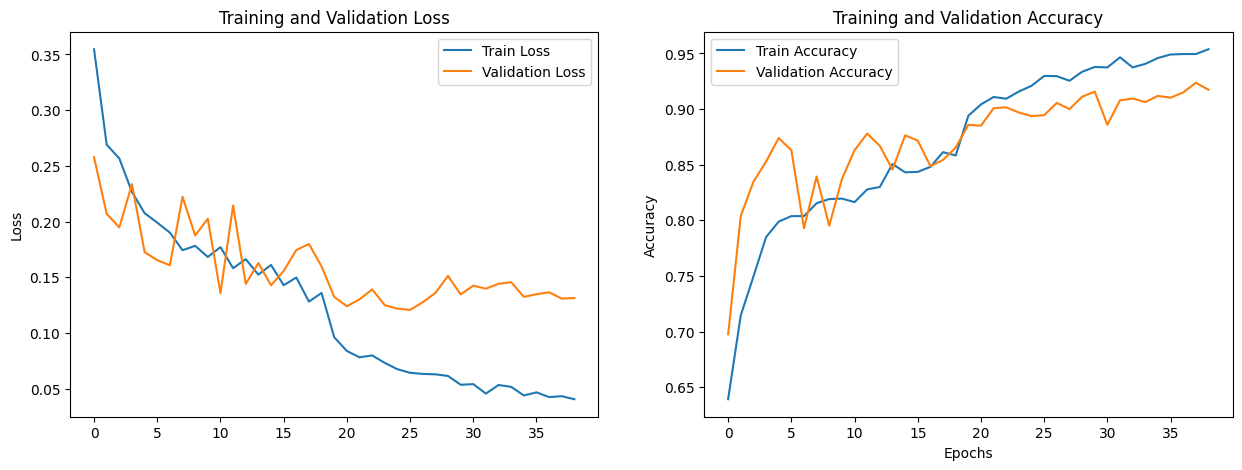

In [ ]:

plot_metrics(resnext50[1])



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:32<00:00,  1.25it/s]



Test Loss: 0.2664 Acc: 0.9181, Kappa: 0.8537
Testing complete in 0m 32s




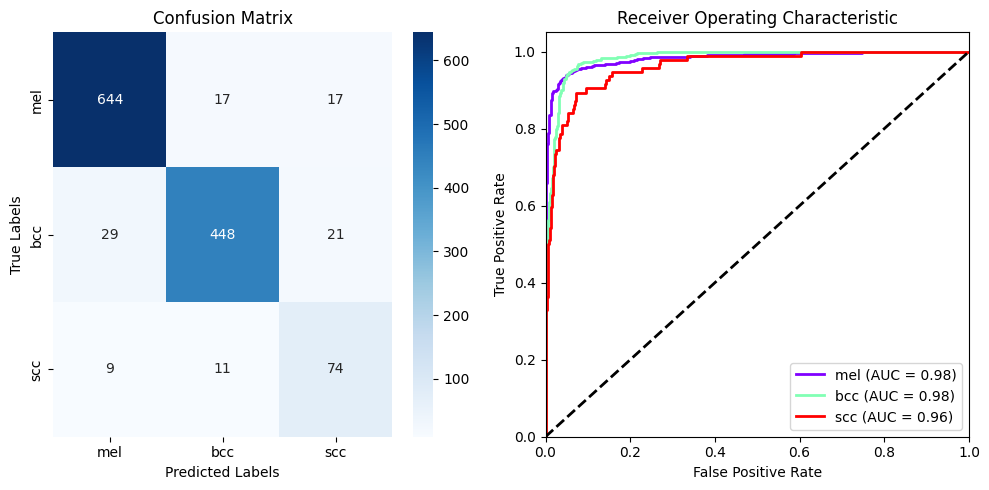

In [ ]:
# Load the pre-trained ResNeXt-50 model
resnext50_model_predict = models.resnext50_32x4d(pretrained=False)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnext50_model_predict.fc.in_features
resnext50_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnext50_model_predict = resnext50_model_predict.to(DEVICE)

# Load the best model weights
best_model_path = TENSORBOARD_PATH + '/ResNext50/resnext50_fl_checkpoint_best.pth'
resnext50_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(resnext50_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)

# ResNeXt 50 [Weighted Cross Entropy]

In [ ]:
# Your logging setup remains the same
logging.basicConfig(filename= TENSORBOARD_PATH + "/ResNext50/resnext50_wce.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained ResNeXt-50 model
resnext50_model = models.resnext50_32x4d(pretrained=True)

# Modify the last fully connected layer
num_ftrs = resnext50_model.fc.in_features
resnext50_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnext50_model = resnext50_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(resnext50_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


checkpoint_p = TENSORBOARD_PATH + '/ResNext50/resnext50_wce_checkpoint.pth'
resnext50 = train_model(resnext50_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.7957, acc: 0.7054, kappa: 0.5091



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.4382, acc: 0.8378, kappa: 0.7134



Epoch 2/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train loss : 0.6545, acc: 0.7627, kappa: 0.6013



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.4337, acc: 0.8488, kappa: 0.7311



Epoch 3/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.5788, acc: 0.7965, kappa: 0.6528



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.4505, acc: 0.8394, kappa: 0.7244



Epoch 4/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.5696, acc: 0.7961, kappa: 0.6556



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.3975, acc: 0.8362, kappa: 0.7232



Epoch 5/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.5184, acc: 0.8170, kappa: 0.6874



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.3368, acc: 0.8819, kappa: 0.7885



Epoch 6/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.4692, acc: 0.8257, kappa: 0.7004



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.3381, acc: 0.8661, kappa: 0.7668



Epoch 7/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.4809, acc: 0.8314, kappa: 0.7098



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.3892, acc: 0.8598, kappa: 0.7578



Epoch 8/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.4413, acc: 0.8522, kappa: 0.7440



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2929, acc: 0.9024, kappa: 0.8257



Epoch 9/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.4349, acc: 0.8505, kappa: 0.7420



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.3486, acc: 0.8669, kappa: 0.7698



Epoch 10/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.4006, acc: 0.8562, kappa: 0.7521



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.3526, acc: 0.8669, kappa: 0.7647



Epoch 11/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.61it/s]

train loss : 0.3988, acc: 0.8587, kappa: 0.7555



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.3238, acc: 0.8819, kappa: 0.7935



Epoch 12/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.3906, acc: 0.8709, kappa: 0.7760



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.3136, acc: 0.8835, kappa: 0.7976



Epoch 13/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.3551, acc: 0.8686, kappa: 0.7723



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.5310, acc: 0.7984, kappa: 0.6627



Epoch 14/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.3621, acc: 0.8705, kappa: 0.7746



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.3110, acc: 0.8898, kappa: 0.8049



Epoch 15/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.58it/s]

train loss : 0.3443, acc: 0.8770, kappa: 0.7857



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.3007, acc: 0.8898, kappa: 0.8034



Epoch 16/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.54it/s]

train loss : 0.3275, acc: 0.8853, kappa: 0.8002



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.3044, acc: 0.8787, kappa: 0.7900



Epoch 17/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.2388, acc: 0.9181, kappa: 0.8559



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2889, acc: 0.8929, kappa: 0.8137



Epoch 18/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.52it/s]

train loss : 0.2101, acc: 0.9274, kappa: 0.8717



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2416, acc: 0.9142, kappa: 0.8494



Epoch 19/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.1820, acc: 0.9364, kappa: 0.8873



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2519, acc: 0.9213, kappa: 0.8618



Epoch 20/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.1954, acc: 0.9333, kappa: 0.8819



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.2297, acc: 0.9252, kappa: 0.8677



Epoch 21/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.1706, acc: 0.9408, kappa: 0.8953



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2138, acc: 0.9362, kappa: 0.8859



Epoch 22/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.1580, acc: 0.9455, kappa: 0.9032



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.2398, acc: 0.9244, kappa: 0.8657



Epoch 23/100
---------------


100%|██████████| 318/318 [02:02<00:00,  2.60it/s]

train loss : 0.1601, acc: 0.9435, kappa: 0.8998



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2446, acc: 0.9260, kappa: 0.8686



Epoch 24/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.1620, acc: 0.9420, kappa: 0.8969



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2536, acc: 0.9205, kappa: 0.8604



Epoch 25/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.1373, acc: 0.9522, kappa: 0.9149



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2559, acc: 0.9220, kappa: 0.8623



Epoch 26/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.1360, acc: 0.9522, kappa: 0.9148



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2371, acc: 0.9291, kappa: 0.8748



Epoch 27/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.1290, acc: 0.9565, kappa: 0.9224



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2052, acc: 0.9346, kappa: 0.8837



Epoch 28/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train loss : 0.1324, acc: 0.9583, kappa: 0.9257



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2172, acc: 0.9315, kappa: 0.8786



Epoch 29/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.1155, acc: 0.9620, kappa: 0.9323



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2220, acc: 0.9370, kappa: 0.8881



Epoch 30/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.1156, acc: 0.9583, kappa: 0.9256



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2206, acc: 0.9339, kappa: 0.8829



Epoch 31/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.1116, acc: 0.9583, kappa: 0.9257



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2113, acc: 0.9354, kappa: 0.8839



Epoch 32/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.1186, acc: 0.9612, kappa: 0.9308



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2122, acc: 0.9331, kappa: 0.8806



Epoch 33/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.0988, acc: 0.9652, kappa: 0.9379



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2281, acc: 0.9291, kappa: 0.8743



Epoch 34/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0976, acc: 0.9658, kappa: 0.9389



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2202, acc: 0.9346, kappa: 0.8845



Epoch 35/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0960, acc: 0.9665, kappa: 0.9403



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2021, acc: 0.9402, kappa: 0.8925



Epoch 36/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.0987, acc: 0.9650, kappa: 0.9374



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2054, acc: 0.9370, kappa: 0.8873



Epoch 37/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.0948, acc: 0.9648, kappa: 0.9370



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2609, acc: 0.9260, kappa: 0.8700



Epoch 38/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train loss : 0.0926, acc: 0.9709, kappa: 0.9480



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2419, acc: 0.9299, kappa: 0.8756



Epoch 39/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0834, acc: 0.9721, kappa: 0.9501



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1990, acc: 0.9417, kappa: 0.8957



Epoch 40/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0815, acc: 0.9721, kappa: 0.9501



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.1891, acc: 0.9457, kappa: 0.9027



Epoch 41/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.58it/s]

train loss : 0.0874, acc: 0.9701, kappa: 0.9465



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2017, acc: 0.9480, kappa: 0.9073



Epoch 42/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0761, acc: 0.9746, kappa: 0.9546



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2160, acc: 0.9370, kappa: 0.8880



Epoch 43/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0836, acc: 0.9711, kappa: 0.9482



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


val loss : 0.2173, acc: 0.9425, kappa: 0.8974

Epoch 44/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.0789, acc: 0.9723, kappa: 0.9504



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2277, acc: 0.9394, kappa: 0.8922



Epoch 45/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train loss : 0.0697, acc: 0.9748, kappa: 0.9549



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


val loss : 0.2038, acc: 0.9433, kappa: 0.8979

Epoch 46/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.52it/s]

train loss : 0.0673, acc: 0.9750, kappa: 0.9552



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2089, acc: 0.9409, kappa: 0.8947



Epoch 47/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.0780, acc: 0.9750, kappa: 0.9552



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2191, acc: 0.9402, kappa: 0.8921



Epoch 48/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train loss : 0.0629, acc: 0.9758, kappa: 0.9567



100%|██████████| 40/40 [00:31<00:00,  1.29it/s]

val loss : 0.2077, acc: 0.9425, kappa: 0.8971



Epoch 49/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.55it/s]

train loss : 0.0716, acc: 0.9736, kappa: 0.9529



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2081, acc: 0.9433, kappa: 0.8986



Epoch 50/100
---------------


100%|██████████| 318/318 [02:11<00:00,  2.43it/s]

train loss : 0.0647, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

val loss : 0.1906, acc: 0.9496, kappa: 0.9096



Epoch 51/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.43it/s]

train loss : 0.0607, acc: 0.9811, kappa: 0.9662



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1908, acc: 0.9488, kappa: 0.9083



Epoch 52/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train loss : 0.0685, acc: 0.9787, kappa: 0.9619



100%|██████████| 40/40 [00:30<00:00,  1.29it/s]

val loss : 0.1925, acc: 0.9496, kappa: 0.9098



Epoch 53/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train loss : 0.0664, acc: 0.9787, kappa: 0.9619



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1960, acc: 0.9472, kappa: 0.9053


EARLY STOP AFTER 53 EPOCHS
Training complete in 138m 0s
Best val loss: 0.189133
Best val Kappa: 0.9097983335774815


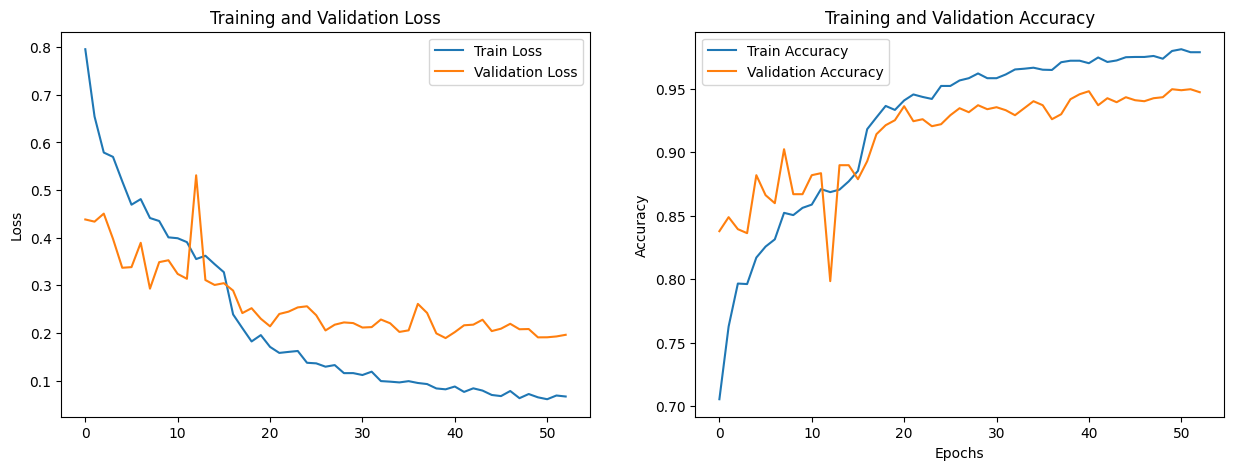

In [ ]:
plot_metrics(resnext50[1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:29<00:00,  1.35it/s]



Test Loss: 0.2641 Acc: 0.9323, Kappa: 0.8789
Testing complete in 0m 30s




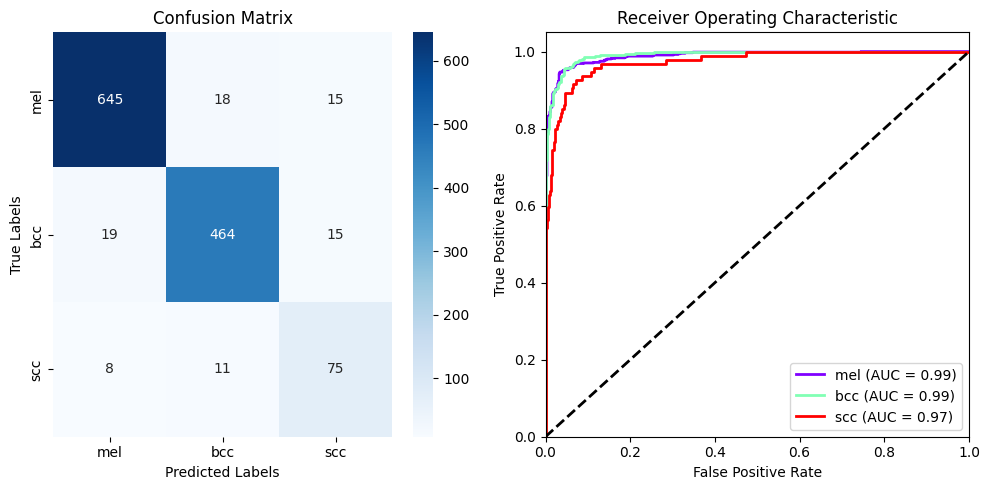

In [ ]:
# Load the pre-trained ResNeXt-50 model
resnext50_model_predict = models.resnext50_32x4d(pretrained=False)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnext50_model_predict.fc.in_features
resnext50_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnext50_model_predict = resnext50_model_predict.to(DEVICE)

# Load the best model weights
best_model_path = TENSORBOARD_PATH + '/ResNext50/resnext50_wce_checkpoint_best.pth'
resnext50_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(resnext50_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# ResNeXt 50 [Sampler Cross Entropy]

In [ ]:
logging.basicConfig(filename=TENSORBOARD_PATH + '/ResNext50/resnext50_ces.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH + '/ResNext50'

# Assuming you have 3 classes
num_classes = 3

# Load the pre-trained ResNeXt-50 model
resnext50_model = models.resnext50_32x4d(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnext50_model.fc.in_features
resnext50_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
resnext50_model = resnext50_model.to(DEVICE)

# Parameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnext50_model.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

# number of samples in each set
dataset_sizes = {
    'train': mean_samples,
    'val': len(val_dataset),
}

checkpoint_p = TENSORBOARD_PATH + '/ResNext50/resnext50_ces_checkpoint.pth'

resnext = train_model(resnext50_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 49.7MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.7906, acc: 0.6991, kappa: 0.5030



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.5349, acc: 0.7906, kappa: 0.6505



Epoch 2/100
---------------


100%|██████████| 318/318 [02:29<00:00,  2.12it/s]

train loss : 0.6623, acc: 0.7649, kappa: 0.6008



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.5604, acc: 0.7677, kappa: 0.6214



Epoch 3/100
---------------


100%|██████████| 318/318 [02:46<00:00,  1.91it/s]

train loss : 0.5995, acc: 0.7896, kappa: 0.6428



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.4409, acc: 0.8268, kappa: 0.7036



Epoch 4/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.5499, acc: 0.8018, kappa: 0.6640



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

val loss : 0.5309, acc: 0.7724, kappa: 0.6286



Epoch 5/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.5136, acc: 0.8123, kappa: 0.6795



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.4581, acc: 0.8150, kappa: 0.6873



Epoch 6/100
---------------


100%|██████████| 318/318 [02:39<00:00,  2.00it/s]

train loss : 0.4890, acc: 0.8203, kappa: 0.6915



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.3436, acc: 0.8661, kappa: 0.7608



Epoch 7/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.19it/s]

train loss : 0.4668, acc: 0.8465, kappa: 0.7348



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.3898, acc: 0.8551, kappa: 0.7483



Epoch 8/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.21it/s]

train loss : 0.4569, acc: 0.8410, kappa: 0.7257



100%|██████████| 40/40 [00:34<00:00,  1.18it/s]

val loss : 0.4499, acc: 0.8362, kappa: 0.7218



Epoch 9/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.18it/s]

train loss : 0.4179, acc: 0.8512, kappa: 0.7433



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.3810, acc: 0.8811, kappa: 0.7899



Epoch 10/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.19it/s]

train loss : 0.3935, acc: 0.8605, kappa: 0.7587



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.3945, acc: 0.8646, kappa: 0.7656



Epoch 11/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.18it/s]

train loss : 0.4195, acc: 0.8599, kappa: 0.7571



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.3484, acc: 0.8827, kappa: 0.7933



Epoch 12/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.3990, acc: 0.8562, kappa: 0.7519



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.4239, acc: 0.8362, kappa: 0.7242



Epoch 13/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]


train loss : 0.3785, acc: 0.8621, kappa: 0.7613


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.3574, acc: 0.8780, kappa: 0.7874



Epoch 14/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.18it/s]

train loss : 0.3598, acc: 0.8770, kappa: 0.7862



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.3588, acc: 0.8709, kappa: 0.7764



Epoch 15/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.16it/s]

train loss : 0.2942, acc: 0.8926, kappa: 0.8121



100%|██████████| 40/40 [00:34<00:00,  1.18it/s]

val loss : 0.2851, acc: 0.9039, kappa: 0.8309



Epoch 16/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.16it/s]

train loss : 0.2587, acc: 0.9032, kappa: 0.8302



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2702, acc: 0.9094, kappa: 0.8408



Epoch 17/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.16it/s]

train loss : 0.2319, acc: 0.9166, kappa: 0.8531



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2870, acc: 0.9055, kappa: 0.8328



Epoch 18/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.15it/s]

train loss : 0.2106, acc: 0.9270, kappa: 0.8711



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2490, acc: 0.9244, kappa: 0.8650



Epoch 19/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.2022, acc: 0.9303, kappa: 0.8767



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2561, acc: 0.9228, kappa: 0.8629



Epoch 20/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.16it/s]

train loss : 0.2053, acc: 0.9311, kappa: 0.8783



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2650, acc: 0.9220, kappa: 0.8617



Epoch 21/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.1823, acc: 0.9353, kappa: 0.8851



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2553, acc: 0.9236, kappa: 0.8639



Epoch 22/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1738, acc: 0.9366, kappa: 0.8875



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


val loss : 0.2779, acc: 0.9197, kappa: 0.8584

Epoch 23/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.1816, acc: 0.9368, kappa: 0.8881



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2718, acc: 0.9165, kappa: 0.8519



Epoch 24/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1620, acc: 0.9380, kappa: 0.8901



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


val loss : 0.2530, acc: 0.9236, kappa: 0.8632

Epoch 25/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1547, acc: 0.9439, kappa: 0.9004



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2522, acc: 0.9291, kappa: 0.8730



Epoch 26/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1644, acc: 0.9473, kappa: 0.9061



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2559, acc: 0.9291, kappa: 0.8735



Epoch 27/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1395, acc: 0.9486, kappa: 0.9089



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2552, acc: 0.9299, kappa: 0.8747



Epoch 28/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.18it/s]

train loss : 0.1340, acc: 0.9532, kappa: 0.9167



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2576, acc: 0.9268, kappa: 0.8689



Epoch 29/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.15it/s]

train loss : 0.1404, acc: 0.9488, kappa: 0.9093



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2581, acc: 0.9283, kappa: 0.8716



Epoch 30/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train loss : 0.1309, acc: 0.9543, kappa: 0.9188



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2495, acc: 0.9283, kappa: 0.8716



Epoch 31/100
---------------


100%|██████████| 318/318 [02:28<00:00,  2.15it/s]

train loss : 0.1361, acc: 0.9514, kappa: 0.9135



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2551, acc: 0.9252, kappa: 0.8660


EARLY STOP AFTER 31 EPOCHS
Training complete in 95m 23s
Best val loss: 0.249039
Best val Kappa: 0.8747073586009968


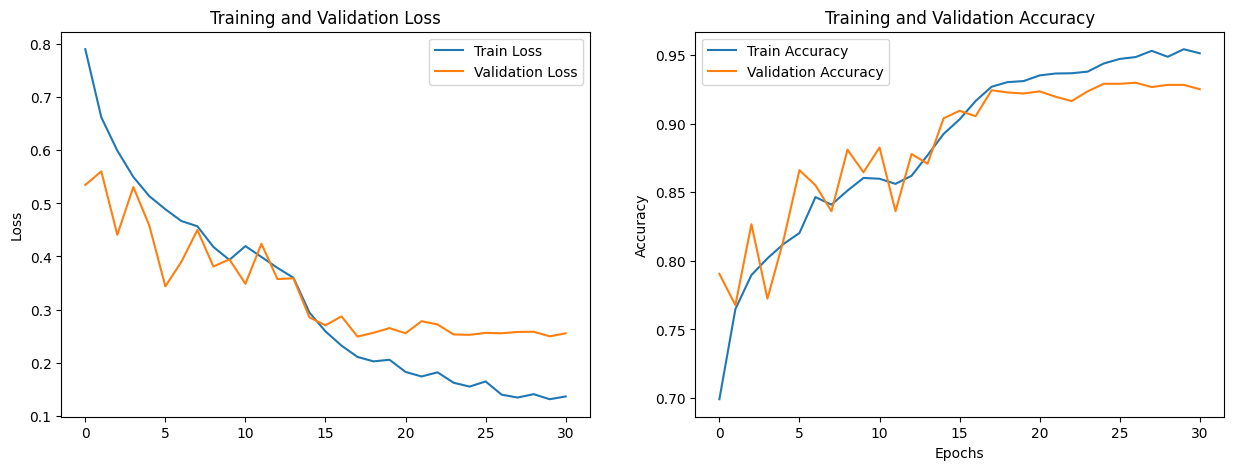

In [ ]:
plot_metrics(resnext[1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:29<00:00,  1.35it/s]



Test Loss: 0.3171 Acc: 0.9220, Kappa: 0.8607
Testing complete in 0m 30s




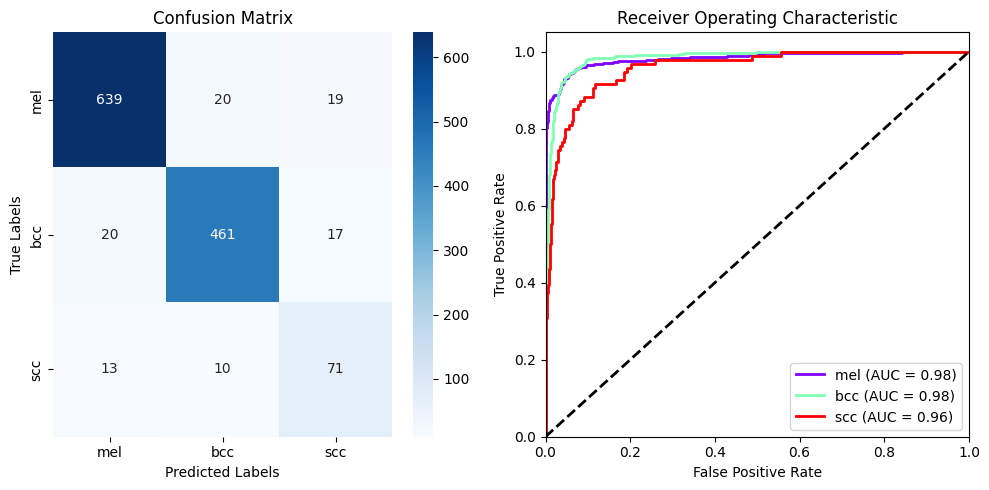

In [ ]:
# Load the pre-trained ResNeXt-50 model
resnext50_model_predict = models.resnext50_32x4d(pretrained=False)

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnext50_model_predict.fc.in_features
resnext50_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
resnext50_model_predict = resnext50_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/ResNext50/resnext50_ces_checkpoint_best.pth'

# Load the best model weights
resnext50_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(resnext50_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# RegNet [Focal Loss]

In [ ]:
# Logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/RegNetY23GF/regnet_y23gf_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

weights = RegNet_Y_32GF_Weights.DEFAULT
# Load the pre-trained RegNetY-23GF model
regnet_y23gf_model = regnet_y_32gf(weights=weights)

# Modify the last fully connected layer
num_ftrs = regnet_y23gf_model.fc.in_features
regnet_y23gf_model.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
regnet_y23gf_model = regnet_y23gf_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(regnet_y23gf_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/RegNetY23GF/regnet_y23gf_wce_checkpoint.pth'
regnet_y23gf = train_model(regnet_y23gf_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Downloading: "https://download.pytorch.org/models/regnet_y_32gf-8db6d4b5.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-8db6d4b5.pth
100%|██████████| 554M/554M [00:40<00:00, 14.2MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [31:36<00:00,  5.96s/it]

train loss : 0.7094, acc: 0.7371, kappa: 0.5578



100%|██████████| 40/40 [08:04<00:00, 12.12s/it]

val loss : 0.3815, acc: 0.8614, kappa: 0.7575



Epoch 2/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.5075, acc: 0.8117, kappa: 0.6791



100%|██████████| 40/40 [00:38<00:00,  1.04it/s]

val loss : 0.3345, acc: 0.8717, kappa: 0.7749



Epoch 3/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.4273, acc: 0.8493, kappa: 0.7401



100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

val loss : 0.2962, acc: 0.9008, kappa: 0.8257



Epoch 4/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.3363, acc: 0.8817, kappa: 0.7939



100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

val loss : 0.3715, acc: 0.8661, kappa: 0.7711



Epoch 5/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.3020, acc: 0.8924, kappa: 0.8120



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2381, acc: 0.9102, kappa: 0.8407



Epoch 6/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.2634, acc: 0.9010, kappa: 0.8268



100%|██████████| 40/40 [00:40<00:00,  1.00s/it]

val loss : 0.3039, acc: 0.8929, kappa: 0.8162



Epoch 7/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.2351, acc: 0.9162, kappa: 0.8522



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2593, acc: 0.9157, kappa: 0.8504



Epoch 8/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.2215, acc: 0.9223, kappa: 0.8630



100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

val loss : 0.3338, acc: 0.8866, kappa: 0.8012



Epoch 9/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.1992, acc: 0.9284, kappa: 0.8733



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.4104, acc: 0.8638, kappa: 0.7680



Epoch 10/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.14s/it]

train loss : 0.1588, acc: 0.9453, kappa: 0.9030



100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

val loss : 0.3639, acc: 0.8953, kappa: 0.8176



Epoch 11/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.1821, acc: 0.9362, kappa: 0.8874



100%|██████████| 40/40 [00:38<00:00,  1.05it/s]

val loss : 0.3367, acc: 0.8843, kappa: 0.7964



Epoch 12/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.1361, acc: 0.9522, kappa: 0.9150



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2684, acc: 0.9047, kappa: 0.8329



Epoch 13/100
---------------


100%|██████████| 318/318 [06:03<00:00,  1.14s/it]

train loss : 0.1771, acc: 0.9359, kappa: 0.8865



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.3049, acc: 0.9071, kappa: 0.8382



Epoch 14/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.1075, acc: 0.9658, kappa: 0.9389



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2285, acc: 0.9244, kappa: 0.8665



Epoch 15/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0806, acc: 0.9728, kappa: 0.9515



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2253, acc: 0.9307, kappa: 0.8767



Epoch 16/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.0794, acc: 0.9766, kappa: 0.9581



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2129, acc: 0.9331, kappa: 0.8807



Epoch 17/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0633, acc: 0.9791, kappa: 0.9627



100%|██████████| 40/40 [00:39<00:00,  1.00it/s]

val loss : 0.2175, acc: 0.9299, kappa: 0.8753



Epoch 18/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0594, acc: 0.9821, kappa: 0.9679



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.2048, acc: 0.9394, kappa: 0.8916



Epoch 19/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.0499, acc: 0.9847, kappa: 0.9725



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.1996, acc: 0.9425, kappa: 0.8972



Epoch 20/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0468, acc: 0.9841, kappa: 0.9714



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2068, acc: 0.9378, kappa: 0.8889



Epoch 21/100
---------------


100%|██████████| 318/318 [06:05<00:00,  1.15s/it]

train loss : 0.0457, acc: 0.9847, kappa: 0.9725



100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

val loss : 0.2127, acc: 0.9370, kappa: 0.8881



Epoch 22/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0370, acc: 0.9878, kappa: 0.9781



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2086, acc: 0.9394, kappa: 0.8910



Epoch 23/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0366, acc: 0.9884, kappa: 0.9792



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2011, acc: 0.9449, kappa: 0.9011



Epoch 24/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0252, acc: 0.9917, kappa: 0.9852



100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

val loss : 0.1891, acc: 0.9457, kappa: 0.9021



Epoch 25/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0337, acc: 0.9884, kappa: 0.9792



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2019, acc: 0.9465, kappa: 0.9043



Epoch 26/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0299, acc: 0.9886, kappa: 0.9795



100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

val loss : 0.1971, acc: 0.9425, kappa: 0.8967



Epoch 27/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0330, acc: 0.9908, kappa: 0.9834



100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

val loss : 0.1973, acc: 0.9465, kappa: 0.9036



Epoch 28/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0278, acc: 0.9931, kappa: 0.9876



100%|██████████| 40/40 [00:39<00:00,  1.00it/s]

val loss : 0.2016, acc: 0.9425, kappa: 0.8966



Epoch 29/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0306, acc: 0.9919, kappa: 0.9855



100%|██████████| 40/40 [00:38<00:00,  1.04it/s]

val loss : 0.1964, acc: 0.9394, kappa: 0.8916



Epoch 30/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0206, acc: 0.9937, kappa: 0.9887



100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

val loss : 0.1999, acc: 0.9472, kappa: 0.9049



Epoch 31/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0212, acc: 0.9921, kappa: 0.9859



100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

val loss : 0.2066, acc: 0.9488, kappa: 0.9077



Epoch 32/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0282, acc: 0.9913, kappa: 0.9844



100%|██████████| 40/40 [00:38<00:00,  1.05it/s]

val loss : 0.1844, acc: 0.9512, kappa: 0.9121



Epoch 33/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0226, acc: 0.9929, kappa: 0.9873



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.2011, acc: 0.9504, kappa: 0.9111



Epoch 34/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0190, acc: 0.9963, kappa: 0.9933



100%|██████████| 40/40 [00:38<00:00,  1.05it/s]

val loss : 0.2090, acc: 0.9543, kappa: 0.9178



Epoch 35/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0191, acc: 0.9945, kappa: 0.9901



100%|██████████| 40/40 [00:39<00:00,  1.00it/s]

val loss : 0.2008, acc: 0.9488, kappa: 0.9087



Epoch 36/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.14s/it]

train loss : 0.0201, acc: 0.9939, kappa: 0.9890



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.1997, acc: 0.9528, kappa: 0.9145



Epoch 37/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0203, acc: 0.9945, kappa: 0.9901



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.2165, acc: 0.9504, kappa: 0.9109



Epoch 38/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0248, acc: 0.9939, kappa: 0.9890



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.2066, acc: 0.9441, kappa: 0.9000



Epoch 39/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0175, acc: 0.9953, kappa: 0.9915



100%|██████████| 40/40 [00:38<00:00,  1.04it/s]

val loss : 0.2144, acc: 0.9441, kappa: 0.8994



Epoch 40/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0180, acc: 0.9955, kappa: 0.9919



100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

val loss : 0.1916, acc: 0.9504, kappa: 0.9105



Epoch 41/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0171, acc: 0.9941, kappa: 0.9894



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.2059, acc: 0.9457, kappa: 0.9022



Epoch 42/100
---------------


100%|██████████| 318/318 [06:03<00:00,  1.14s/it]

train loss : 0.0173, acc: 0.9945, kappa: 0.9901



100%|██████████| 40/40 [00:37<00:00,  1.05it/s]

val loss : 0.1991, acc: 0.9480, kappa: 0.9068



Epoch 43/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0121, acc: 0.9963, kappa: 0.9933



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.1998, acc: 0.9472, kappa: 0.9053



Epoch 44/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0158, acc: 0.9965, kappa: 0.9936



100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

val loss : 0.2086, acc: 0.9457, kappa: 0.9027



Epoch 45/100
---------------


100%|██████████| 318/318 [06:04<00:00,  1.15s/it]

train loss : 0.0127, acc: 0.9955, kappa: 0.9919



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.1923, acc: 0.9520, kappa: 0.9137


EARLY STOP AFTER 45 EPOCHS
Training complete in 344m 29s
Best val loss: 0.184378
Best val Kappa: 0.9178330961060518


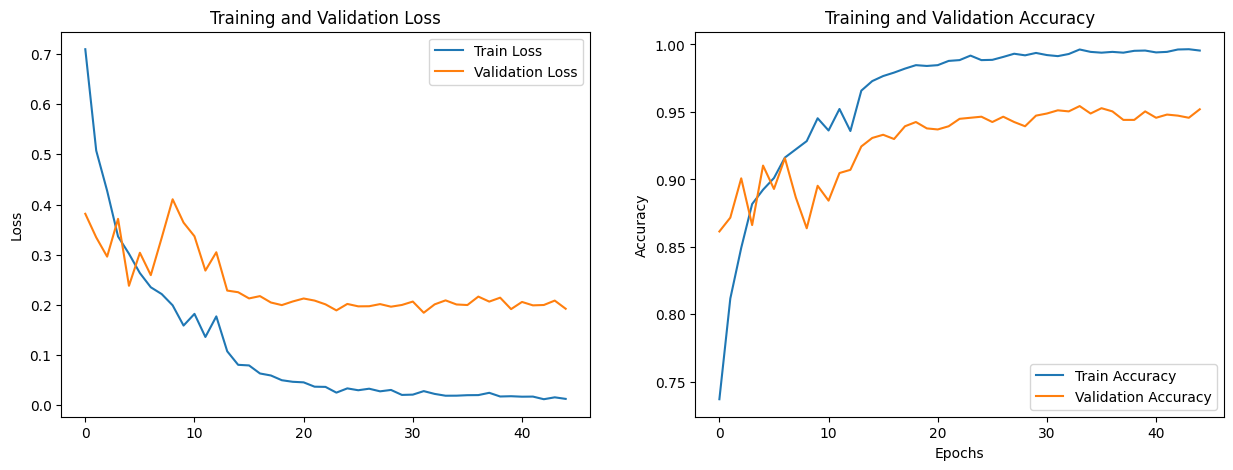

In [ ]:

plot_metrics(regnet_y23gf[1])

100%|██████████| 40/40 [00:44<00:00,  1.12s/it]



Test Loss: 0.2090 Acc: 0.9543, Kappa: 0.9178
Testing complete in 0m 45s




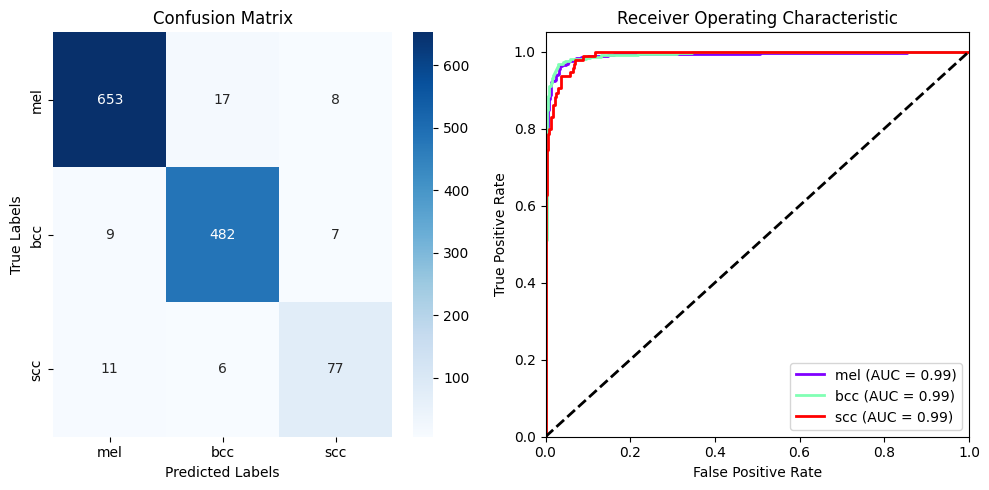

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Assuming 'TENSORBOARD_PATH', 'num_classes', 'val_loader', 'DEVICE', and 'criterion' are defined, and test_model is implemented

# Load the pre-trained RegNetY-23 model (adjust this line if the model is available in your torchvision version)
regnet_y23_model_predict = models.regnet_y_32gf(weights=None)  # Replace regnet_y_23gf with the correct function if different

# Modify the last fully connected layer to match the number of classes
num_ftrs = regnet_y23_model_predict.fc.in_features
regnet_y23_model_predict.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
regnet_y23_model_predict = regnet_y23_model_predict.to(DEVICE)

# Load the best model weights
best_model_path = TENSORBOARD_PATH + '/RegNetY23GF/regnet_y23gf_wce_checkpoint_best.pth'  # Adjust directory as needed
regnet_y23_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(regnet_y23_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# DenseNet 121 [Focal Loss]

In [ ]:
logging.basicConfig(filename=TENSORBOARD_PATH + "/DenseNet121/densenet121_fl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Assuming you have 3 classes
num_classes = 3

# Load the pre-trained DenseNet-121 model
densenet121_model = models.densenet121(pretrained=True)

# Modify the classifier layer to match the number of classes
num_ftrs = densenet121_model.classifier.in_features
densenet121_model.classifier = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
densenet121_model = densenet121_model.to(DEVICE)

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12

EPOCHS = 100
WD = 1e-6

criterion =  FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.Adam(densenet121_model.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

#number of samples in each set
dataset_sizes = {
    'train': len(train_dataset),
    'val':len(val_dataset),
}
torch.cuda.empty_cache()

checkpoint_p = TENSORBOARD_PATH + '/DenseNet121/densenet121_checkpoint.pth'
densenet121 = train_model(densenet121_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.3491, acc: 0.6350, kappa: 0.4225



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2598, acc: 0.8063, kappa: 0.6648



Epoch 2/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.2723, acc: 0.7062, kappa: 0.5255



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2359, acc: 0.7913, kappa: 0.6492



Epoch 3/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.2445, acc: 0.7471, kappa: 0.5835



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.1843, acc: 0.8008, kappa: 0.6710



Epoch 4/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.43it/s]

train loss : 0.2273, acc: 0.7637, kappa: 0.6087



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2300, acc: 0.8654, kappa: 0.7558



Epoch 5/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.1995, acc: 0.7869, kappa: 0.6426



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1768, acc: 0.8543, kappa: 0.7462



Epoch 6/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.65it/s]

train loss : 0.1980, acc: 0.8013, kappa: 0.6657



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.1878, acc: 0.8378, kappa: 0.7218



Epoch 7/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.1962, acc: 0.7997, kappa: 0.6633



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1945, acc: 0.8197, kappa: 0.6923



Epoch 8/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1796, acc: 0.8115, kappa: 0.6816



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1691, acc: 0.8630, kappa: 0.7602



Epoch 9/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.1672, acc: 0.8198, kappa: 0.6943



100%|██████████| 40/40 [00:25<00:00,  1.55it/s]

val loss : 0.1652, acc: 0.8630, kappa: 0.7573



Epoch 10/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1712, acc: 0.8198, kappa: 0.6953



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1616, acc: 0.8614, kappa: 0.7599



Epoch 11/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1758, acc: 0.8146, kappa: 0.6872



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1710, acc: 0.8189, kappa: 0.6914



Epoch 12/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.1508, acc: 0.8451, kappa: 0.7349



100%|██████████| 40/40 [00:25<00:00,  1.55it/s]

val loss : 0.1525, acc: 0.8189, kappa: 0.6998



Epoch 13/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.65it/s]

train loss : 0.1413, acc: 0.8485, kappa: 0.7401



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1918, acc: 0.8654, kappa: 0.7618



Epoch 14/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1600, acc: 0.8329, kappa: 0.7167



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1653, acc: 0.8102, kappa: 0.6825



Epoch 15/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.1337, acc: 0.8542, kappa: 0.7503



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.1648, acc: 0.8031, kappa: 0.6756



Epoch 16/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.1281, acc: 0.8628, kappa: 0.7640



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1787, acc: 0.8685, kappa: 0.7678



Epoch 17/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.1287, acc: 0.8617, kappa: 0.7620



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1527, acc: 0.8307, kappa: 0.7165



Epoch 18/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.1235, acc: 0.8634, kappa: 0.7652



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1699, acc: 0.8835, kappa: 0.7941



Epoch 19/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.1172, acc: 0.8774, kappa: 0.7879



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.1880, acc: 0.8803, kappa: 0.7869



Epoch 20/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.1175, acc: 0.8705, kappa: 0.7762



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1842, acc: 0.8874, kappa: 0.8006



Epoch 21/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.1012, acc: 0.8973, kappa: 0.8205



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1304, acc: 0.9055, kappa: 0.8336



Epoch 22/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.0858, acc: 0.9036, kappa: 0.8320



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.1231, acc: 0.8976, kappa: 0.8213



Epoch 23/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0821, acc: 0.9107, kappa: 0.8441



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.1177, acc: 0.8945, kappa: 0.8167



Epoch 24/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.0743, acc: 0.9191, kappa: 0.8581



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1235, acc: 0.9039, kappa: 0.8314



Epoch 25/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.0670, acc: 0.9254, kappa: 0.8687



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.1218, acc: 0.9016, kappa: 0.8278



Epoch 26/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.0655, acc: 0.9276, kappa: 0.8725



100%|██████████| 40/40 [00:26<00:00,  1.54it/s]

val loss : 0.1151, acc: 0.9000, kappa: 0.8259



Epoch 27/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.0622, acc: 0.9319, kappa: 0.8801



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1183, acc: 0.9087, kappa: 0.8394



Epoch 28/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.62it/s]

train loss : 0.0562, acc: 0.9347, kappa: 0.8847



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.1169, acc: 0.9094, kappa: 0.8403



Epoch 29/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.58it/s]

train loss : 0.0609, acc: 0.9319, kappa: 0.8800



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1258, acc: 0.8976, kappa: 0.8211



Epoch 30/100
---------------


100%|██████████| 318/318 [02:02<00:00,  2.59it/s]

train loss : 0.0537, acc: 0.9402, kappa: 0.8941



100%|██████████| 40/40 [00:26<00:00,  1.53it/s]

val loss : 0.1335, acc: 0.9055, kappa: 0.8330



Epoch 31/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0529, acc: 0.9390, kappa: 0.8923



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.1223, acc: 0.9087, kappa: 0.8394



Epoch 32/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0506, acc: 0.9469, kappa: 0.9058



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1228, acc: 0.9087, kappa: 0.8394



Epoch 33/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0487, acc: 0.9465, kappa: 0.9050



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1314, acc: 0.9150, kappa: 0.8488



Epoch 34/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.0516, acc: 0.9406, kappa: 0.8949



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1276, acc: 0.9079, kappa: 0.8373



Epoch 35/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0479, acc: 0.9475, kappa: 0.9063



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.1283, acc: 0.9150, kappa: 0.8492



Epoch 36/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.0477, acc: 0.9457, kappa: 0.9035



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.1265, acc: 0.9150, kappa: 0.8492



Epoch 37/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.65it/s]

train loss : 0.0473, acc: 0.9457, kappa: 0.9036



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1163, acc: 0.9110, kappa: 0.8442



Epoch 38/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.0465, acc: 0.9477, kappa: 0.9070



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1199, acc: 0.9134, kappa: 0.8471



Epoch 39/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.0473, acc: 0.9457, kappa: 0.9036



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.1243, acc: 0.9189, kappa: 0.8553


EARLY STOP AFTER 39 EPOCHS
Training complete in 96m 27s
Best val loss: 0.115104
Best val Kappa: 0.8553063554147567


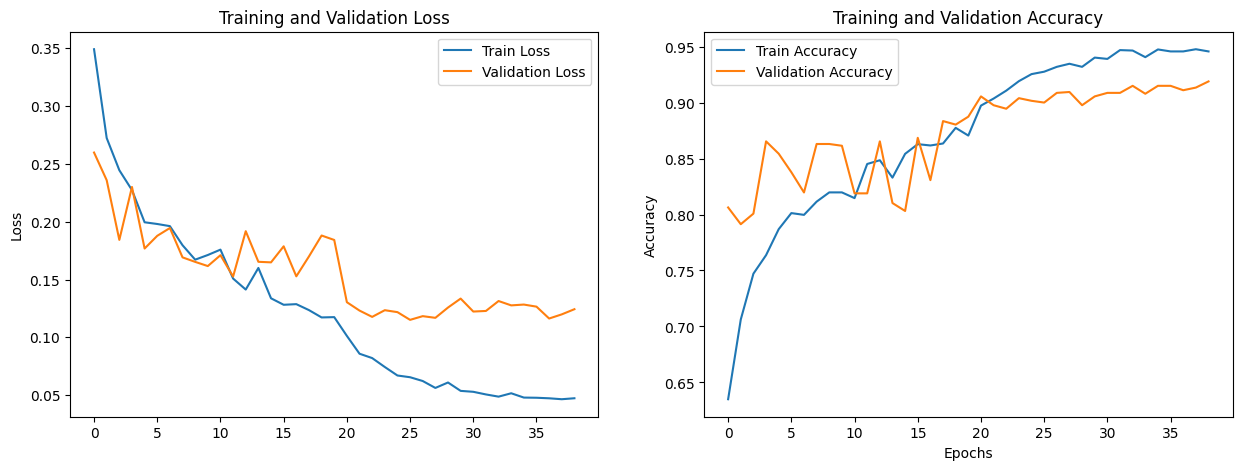

In [ ]:
plot_metrics(densenet121[1])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:35<00:00,  1.14it/s]



Test Loss: 0.2817 Acc: 0.9094, Kappa: 0.8393
Testing complete in 0m 35s




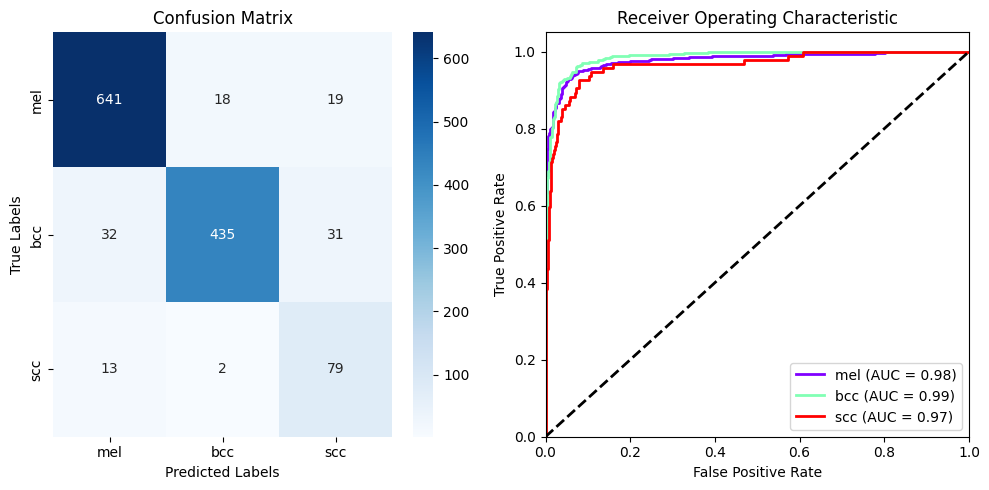

In [ ]:
# Load the pre-trained DenseNet-121 model
densenet121_model_predict = models.densenet121(pretrained=False)

# Modify the classifier layer to match the number of classes
num_ftrs = densenet121_model_predict.classifier.in_features
densenet121_model_predict.classifier = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
densenet121_model_predict = densenet121_model_predict.to(DEVICE)

# Load the best model weights
best_model_path = TENSORBOARD_PATH + '/DenseNet121/densenet121_checkpoint_best.pth'
densenet121_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(densenet121_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# DenseNet 121 [Weighted Cross Entropy]

In [ ]:
logging.basicConfig(filename=TENSORBOARD_PATH + "/DenseNet121/densenet121_wce.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Assuming you have 3 classes
num_classes = 3

# Load the pre-trained DenseNet-121 model
densenet121_model = models.densenet121(pretrained=True)

# Modify the classifier layer to match the number of classes
num_ftrs = densenet121_model.classifier.in_features
densenet121_model.classifier = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
densenet121_model = densenet121_model.to(DEVICE)

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12

EPOCHS = 100
WD = 1e-6

criterion =  nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet121_model.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

#number of samples in each set
dataset_sizes = {
    'train': len(train_dataset),
    'val':len(val_dataset),
}
torch.cuda.empty_cache()

checkpoint_p = TENSORBOARD_PATH + '/DenseNet121/densenet121_wce_checkpoint.pth'
densenet121 = train_model(densenet121_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:02<00:00,  2.60it/s]

train loss : 0.7769, acc: 0.7015, kappa: 0.5036



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.4942, acc: 0.7969, kappa: 0.6525



Epoch 2/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.6377, acc: 0.7676, kappa: 0.6076



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.4396, acc: 0.8291, kappa: 0.7053



Epoch 3/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.5782, acc: 0.7883, kappa: 0.6387



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.4335, acc: 0.8488, kappa: 0.7375



Epoch 4/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.5347, acc: 0.8022, kappa: 0.6634



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.3647, acc: 0.8646, kappa: 0.7619



Epoch 5/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.4957, acc: 0.8194, kappa: 0.6909



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.4636, acc: 0.8087, kappa: 0.6732



Epoch 6/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.5024, acc: 0.8241, kappa: 0.6983



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.3995, acc: 0.8409, kappa: 0.7312



Epoch 7/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.4522, acc: 0.8408, kappa: 0.7258



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.4399, acc: 0.8339, kappa: 0.7140



Epoch 8/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.4224, acc: 0.8485, kappa: 0.7386



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.4143, acc: 0.8457, kappa: 0.7375



Epoch 9/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.4284, acc: 0.8491, kappa: 0.7387



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.4062, acc: 0.8559, kappa: 0.7506



Epoch 10/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.3951, acc: 0.8595, kappa: 0.7574



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.3270, acc: 0.8803, kappa: 0.7872



Epoch 11/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.3669, acc: 0.8636, kappa: 0.7638



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.3452, acc: 0.8819, kappa: 0.7931



Epoch 12/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.3495, acc: 0.8810, kappa: 0.7919



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.3373, acc: 0.8819, kappa: 0.7934



Epoch 13/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.3349, acc: 0.8849, kappa: 0.7988



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.5299, acc: 0.8126, kappa: 0.6885



Epoch 14/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.3191, acc: 0.8863, kappa: 0.8017



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.3270, acc: 0.8764, kappa: 0.7813



Epoch 15/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.3273, acc: 0.8882, kappa: 0.8049



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.3190, acc: 0.8890, kappa: 0.8049



Epoch 16/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.3159, acc: 0.8876, kappa: 0.8036



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.3857, acc: 0.8748, kappa: 0.7837



Epoch 17/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.3070, acc: 0.8890, kappa: 0.8059



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.3522, acc: 0.8780, kappa: 0.7869



Epoch 18/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.3029, acc: 0.8973, kappa: 0.8201



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.4116, acc: 0.8496, kappa: 0.7431



Epoch 19/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.65it/s]

train loss : 0.2793, acc: 0.9022, kappa: 0.8285



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.3235, acc: 0.8929, kappa: 0.8129



Epoch 20/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.2747, acc: 0.8969, kappa: 0.8193



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.3446, acc: 0.8756, kappa: 0.7873



Epoch 21/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2487, acc: 0.9115, kappa: 0.8441



100%|██████████| 40/40 [00:25<00:00,  1.56it/s]

val loss : 0.3167, acc: 0.8882, kappa: 0.8042



Epoch 22/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train loss : 0.2546, acc: 0.9093, kappa: 0.8405



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.3029, acc: 0.8984, kappa: 0.8232



Epoch 23/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.62it/s]

train loss : 0.2396, acc: 0.9201, kappa: 0.8593



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


val loss : 0.3118, acc: 0.8921, kappa: 0.8086

Epoch 24/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.2479, acc: 0.9146, kappa: 0.8496



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2735, acc: 0.9000, kappa: 0.8228



Epoch 25/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.63it/s]

train loss : 0.2307, acc: 0.9207, kappa: 0.8601



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2965, acc: 0.9047, kappa: 0.8300



Epoch 26/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.2003, acc: 0.9282, kappa: 0.8729



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2715, acc: 0.9150, kappa: 0.8493



Epoch 27/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.62it/s]

train loss : 0.2228, acc: 0.9201, kappa: 0.8592



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.2733, acc: 0.9118, kappa: 0.8439



Epoch 28/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.2366, acc: 0.9185, kappa: 0.8565



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2849, acc: 0.9063, kappa: 0.8337



Epoch 29/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.61it/s]

train loss : 0.2013, acc: 0.9276, kappa: 0.8722



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.3207, acc: 0.8913, kappa: 0.8088



Epoch 30/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2059, acc: 0.9298, kappa: 0.8757



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2788, acc: 0.9150, kappa: 0.8491



Epoch 31/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.1994, acc: 0.9242, kappa: 0.8661



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.4278, acc: 0.8677, kappa: 0.7710



Epoch 32/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.2229, acc: 0.9209, kappa: 0.8606



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.3168, acc: 0.9063, kappa: 0.8333



Epoch 33/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.62it/s]

train loss : 0.1960, acc: 0.9307, kappa: 0.8776



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


val loss : 0.2645, acc: 0.9118, kappa: 0.8424

Epoch 34/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.1840, acc: 0.9323, kappa: 0.8799



100%|██████████| 40/40 [00:26<00:00,  1.49it/s]

val loss : 0.3006, acc: 0.9063, kappa: 0.8337



Epoch 35/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1841, acc: 0.9368, kappa: 0.8881



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.3542, acc: 0.8890, kappa: 0.8051



Epoch 36/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1654, acc: 0.9427, kappa: 0.8984



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.3370, acc: 0.9087, kappa: 0.8381



Epoch 37/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1740, acc: 0.9423, kappa: 0.8977



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2578, acc: 0.9260, kappa: 0.8685



Epoch 38/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1864, acc: 0.9384, kappa: 0.8912



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2711, acc: 0.9071, kappa: 0.8365



Epoch 39/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.1422, acc: 0.9490, kappa: 0.9094



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.3276, acc: 0.9016, kappa: 0.8257



Epoch 40/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.1588, acc: 0.9416, kappa: 0.8962



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.3225, acc: 0.8921, kappa: 0.8120



Epoch 41/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.1705, acc: 0.9392, kappa: 0.8922



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2801, acc: 0.9094, kappa: 0.8399



Epoch 42/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.1427, acc: 0.9463, kappa: 0.9048



100%|██████████| 40/40 [00:26<00:00,  1.53it/s]

val loss : 0.3120, acc: 0.9079, kappa: 0.8363



Epoch 43/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1663, acc: 0.9398, kappa: 0.8932



100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

val loss : 0.3148, acc: 0.9047, kappa: 0.8327



Epoch 44/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.1883, acc: 0.9339, kappa: 0.8829



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.3063, acc: 0.9000, kappa: 0.8251



Epoch 45/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.1344, acc: 0.9538, kappa: 0.9176



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.3236, acc: 0.9110, kappa: 0.8412



Epoch 46/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.1032, acc: 0.9626, kappa: 0.9334



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2683, acc: 0.9260, kappa: 0.8675



Epoch 47/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0850, acc: 0.9703, kappa: 0.9468



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2627, acc: 0.9268, kappa: 0.8692



Epoch 48/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0958, acc: 0.9683, kappa: 0.9433



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2574, acc: 0.9276, kappa: 0.8708



Epoch 49/100
---------------


100%|██████████| 318/318 [02:04<00:00,  2.56it/s]

train loss : 0.0698, acc: 0.9754, kappa: 0.9560



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2532, acc: 0.9323, kappa: 0.8790



Epoch 50/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train loss : 0.0712, acc: 0.9774, kappa: 0.9594



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2491, acc: 0.9346, kappa: 0.8828



Epoch 51/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train loss : 0.0604, acc: 0.9791, kappa: 0.9627



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2587, acc: 0.9331, kappa: 0.8807



Epoch 52/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.0610, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:26<00:00,  1.48it/s]

val loss : 0.2506, acc: 0.9362, kappa: 0.8857



Epoch 53/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.0603, acc: 0.9801, kappa: 0.9644



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.2491, acc: 0.9339, kappa: 0.8816



Epoch 54/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0667, acc: 0.9776, kappa: 0.9598



100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

val loss : 0.2585, acc: 0.9315, kappa: 0.8779



Epoch 55/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0586, acc: 0.9793, kappa: 0.9630



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2371, acc: 0.9339, kappa: 0.8814



Epoch 56/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.0510, acc: 0.9811, kappa: 0.9662



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2504, acc: 0.9402, kappa: 0.8925



Epoch 57/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0580, acc: 0.9823, kappa: 0.9683



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.2585, acc: 0.9354, kappa: 0.8845



Epoch 58/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0564, acc: 0.9817, kappa: 0.9672



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2463, acc: 0.9323, kappa: 0.8786



Epoch 59/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.0510, acc: 0.9803, kappa: 0.9647



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2530, acc: 0.9323, kappa: 0.8789



Epoch 60/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0457, acc: 0.9870, kappa: 0.9767



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2627, acc: 0.9307, kappa: 0.8767



Epoch 61/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.65it/s]

train loss : 0.0498, acc: 0.9839, kappa: 0.9710



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2463, acc: 0.9409, kappa: 0.8947



Epoch 62/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.0491, acc: 0.9825, kappa: 0.9686



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2357, acc: 0.9417, kappa: 0.8958



Epoch 63/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.0490, acc: 0.9835, kappa: 0.9703



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.2427, acc: 0.9370, kappa: 0.8874



Epoch 64/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0408, acc: 0.9862, kappa: 0.9753



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2524, acc: 0.9362, kappa: 0.8859



Epoch 65/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.0401, acc: 0.9870, kappa: 0.9767



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2397, acc: 0.9417, kappa: 0.8954



Epoch 66/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.65it/s]

train loss : 0.0422, acc: 0.9864, kappa: 0.9756



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.2399, acc: 0.9378, kappa: 0.8886



Epoch 67/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0474, acc: 0.9848, kappa: 0.9728



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2375, acc: 0.9346, kappa: 0.8829



Epoch 68/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.0402, acc: 0.9864, kappa: 0.9756



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.2492, acc: 0.9307, kappa: 0.8761



Epoch 69/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0406, acc: 0.9858, kappa: 0.9746



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2469, acc: 0.9307, kappa: 0.8755



Epoch 70/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0408, acc: 0.9904, kappa: 0.9827



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2604, acc: 0.9315, kappa: 0.8776



Epoch 71/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0420, acc: 0.9878, kappa: 0.9781



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2533, acc: 0.9315, kappa: 0.8775



Epoch 72/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0452, acc: 0.9868, kappa: 0.9763



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2428, acc: 0.9362, kappa: 0.8859



Epoch 73/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0375, acc: 0.9864, kappa: 0.9757



100%|██████████| 40/40 [00:26<00:00,  1.49it/s]

val loss : 0.2583, acc: 0.9378, kappa: 0.8887



Epoch 74/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.0367, acc: 0.9886, kappa: 0.9795



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.2543, acc: 0.9354, kappa: 0.8848



Epoch 75/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.72it/s]

train loss : 0.0387, acc: 0.9876, kappa: 0.9778



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.2549, acc: 0.9291, kappa: 0.8737


EARLY STOP AFTER 75 EPOCHS
Training complete in 184m 33s
Best val loss: 0.235689
Best val Kappa: 0.895849956557973


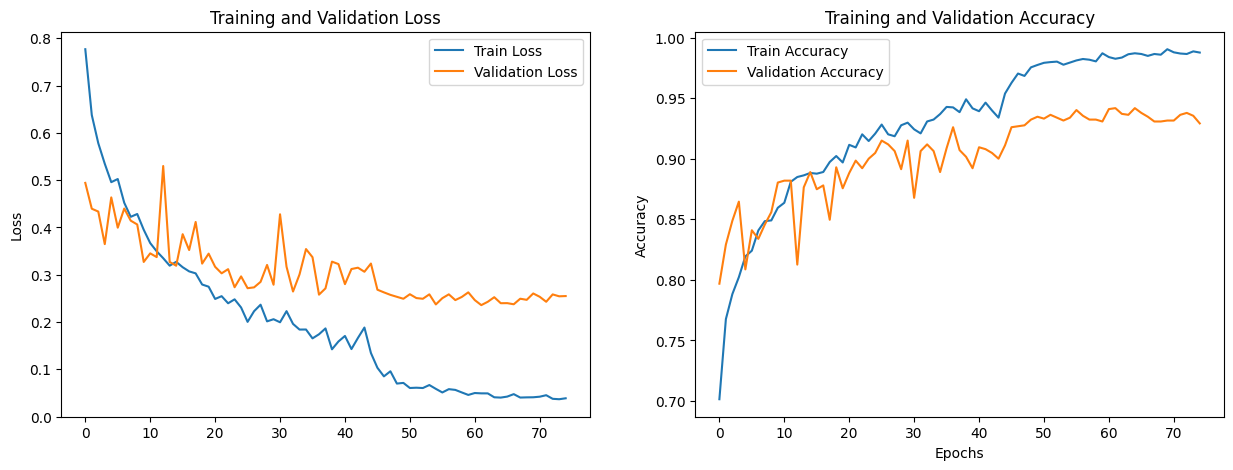

In [ ]:
plot_metrics(densenet121[1])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 40/40 [00:28<00:00,  1.38it/s]



Test Loss: 0.2994 Acc: 0.9307, Kappa: 0.8759
Testing complete in 0m 29s




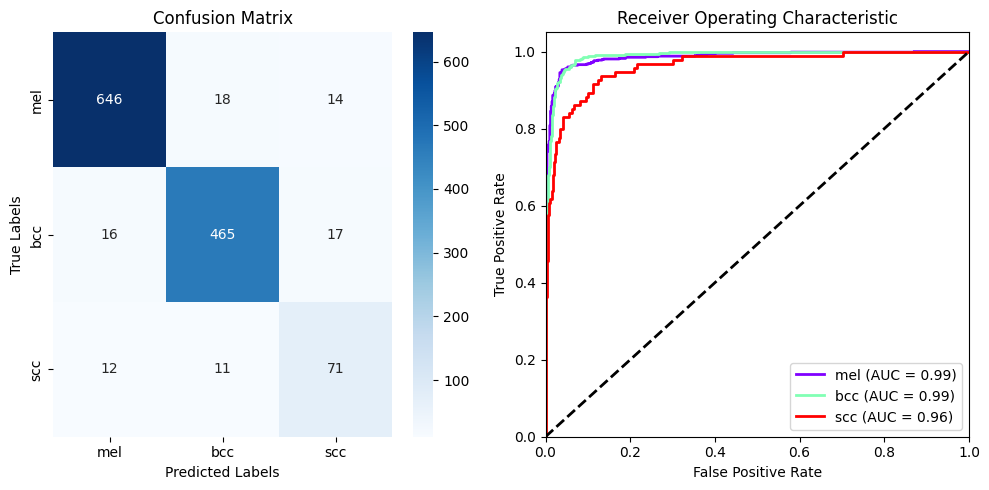

In [ ]:
# Load the pre-trained DenseNet-121 model
densenet121_model_predict = models.densenet121(pretrained=False)

# Modify the classifier layer to match the number of classes
num_ftrs = densenet121_model_predict.classifier.in_features
densenet121_model_predict.classifier = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
densenet121_model_predict = densenet121_model_predict.to(DEVICE)

# Load the best model weights
best_model_path = TENSORBOARD_PATH + '/DenseNet121/densenet121_wce_checkpoint_best.pth'

densenet121_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(densenet121_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# EfficientNet B2 [Focal Loss]

In [ ]:

# Override the get_state_dict method to bypass hash check
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Remove check_hash if it exists
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/EfficientNetB2/efficientnetb2_fl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained EfficientNet B2 model using torchvision
weights = EfficientNet_B2_Weights.DEFAULT
efficientnet_b2_model = models.efficientnet_b2(weights=weights)

# Modify the classifier layer
num_ftrs = efficientnet_b2_model.classifier[1].in_features
efficientnet_b2_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b2_model = efficientnet_b2_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.Adam(efficientnet_b2_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/EfficientNetB2/efficientnetb2_fl_checkpoint.pth'
efficientnet_b2 = train_model(efficientnet_b2_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 101MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.3361, acc: 0.6663, kappa: 0.4594



100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

val loss : 0.2355, acc: 0.7402, kappa: 0.5779



Epoch 2/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.2511, acc: 0.7434, kappa: 0.5786



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.2044, acc: 0.7654, kappa: 0.6209



Epoch 3/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]


train loss : 0.2178, acc: 0.7721, kappa: 0.6197


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1846, acc: 0.8031, kappa: 0.6692



Epoch 4/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.1872, acc: 0.8060, kappa: 0.6739



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


val loss : 0.1607, acc: 0.8378, kappa: 0.7251

Epoch 5/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]


train loss : 0.1781, acc: 0.8178, kappa: 0.6923


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1736, acc: 0.8488, kappa: 0.7398



Epoch 6/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.1681, acc: 0.8243, kappa: 0.7022



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

val loss : 0.1426, acc: 0.8591, kappa: 0.7572



Epoch 7/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.1479, acc: 0.8444, kappa: 0.7338



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.1642, acc: 0.8457, kappa: 0.7320



Epoch 8/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]


train loss : 0.1306, acc: 0.8514, kappa: 0.7453


100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.1437, acc: 0.8890, kappa: 0.8046



Epoch 9/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.1380, acc: 0.8548, kappa: 0.7506



100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1388, acc: 0.8717, kappa: 0.7793



Epoch 10/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.1159, acc: 0.8768, kappa: 0.7868



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


val loss : 0.1401, acc: 0.9008, kappa: 0.8247

Epoch 11/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]


train loss : 0.1157, acc: 0.8701, kappa: 0.7758


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1381, acc: 0.9008, kappa: 0.8246



Epoch 12/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]


train loss : 0.1001, acc: 0.8867, kappa: 0.8034


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1368, acc: 0.8969, kappa: 0.8197



Epoch 13/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]


train loss : 0.1002, acc: 0.8810, kappa: 0.7934


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1611, acc: 0.9087, kappa: 0.8366



Epoch 14/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.1102, acc: 0.8817, kappa: 0.7952



100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1344, acc: 0.8976, kappa: 0.8203



Epoch 15/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]


train loss : 0.0916, acc: 0.9008, kappa: 0.8266


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1389, acc: 0.8772, kappa: 0.7879



Epoch 16/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.0837, acc: 0.9063, kappa: 0.8357



100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

val loss : 0.1220, acc: 0.8976, kappa: 0.8211



Epoch 17/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]


train loss : 0.0816, acc: 0.9065, kappa: 0.8364


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


val loss : 0.1270, acc: 0.8913, kappa: 0.8098

Epoch 18/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]


train loss : 0.0877, acc: 0.9024, kappa: 0.8298


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1389, acc: 0.8906, kappa: 0.8091



Epoch 19/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]


train loss : 0.0706, acc: 0.9238, kappa: 0.8661


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1155, acc: 0.8772, kappa: 0.7883



Epoch 20/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]


train loss : 0.0706, acc: 0.9156, kappa: 0.8520


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1277, acc: 0.9008, kappa: 0.8267



Epoch 21/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0754, acc: 0.9174, kappa: 0.8549



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1138, acc: 0.8764, kappa: 0.7888



Epoch 22/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0680, acc: 0.9244, kappa: 0.8671



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1389, acc: 0.8685, kappa: 0.7745



Epoch 23/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]


train loss : 0.0615, acc: 0.9296, kappa: 0.8756


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1604, acc: 0.8346, kappa: 0.7230



Epoch 24/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.0740, acc: 0.9205, kappa: 0.8600



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1416, acc: 0.8953, kappa: 0.8165



Epoch 25/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]


train loss : 0.0631, acc: 0.9327, kappa: 0.8813


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1353, acc: 0.9205, kappa: 0.8591



Epoch 26/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.0617, acc: 0.9323, kappa: 0.8803



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


val loss : 0.1580, acc: 0.8850, kappa: 0.8002

Epoch 27/100
---------------


100%|██████████| 318/318 [02:29<00:00,  2.13it/s]

train loss : 0.0531, acc: 0.9378, kappa: 0.8899



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.1569, acc: 0.9063, kappa: 0.8361



Epoch 28/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]


train loss : 0.0576, acc: 0.9339, kappa: 0.8832


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1450, acc: 0.9173, kappa: 0.8529



Epoch 29/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.0518, acc: 0.9431, kappa: 0.8994



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1657, acc: 0.9197, kappa: 0.8567



Epoch 30/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.0431, acc: 0.9498, kappa: 0.9109



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


val loss : 0.1555, acc: 0.9157, kappa: 0.8510

Epoch 31/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]


train loss : 0.0417, acc: 0.9561, kappa: 0.9220


100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1479, acc: 0.9228, kappa: 0.8633



Epoch 32/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]


train loss : 0.0371, acc: 0.9551, kappa: 0.9204


100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

val loss : 0.1428, acc: 0.9252, kappa: 0.8678



Epoch 33/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]


train loss : 0.0331, acc: 0.9638, kappa: 0.9356


100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

val loss : 0.1395, acc: 0.9315, kappa: 0.8784



Epoch 34/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0324, acc: 0.9632, kappa: 0.9344



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.1404, acc: 0.9283, kappa: 0.8724


EARLY STOP AFTER 34 EPOCHS
Training complete in 96m 46s
Best val loss: 0.113756
Best val Kappa: 0.8783589188046609


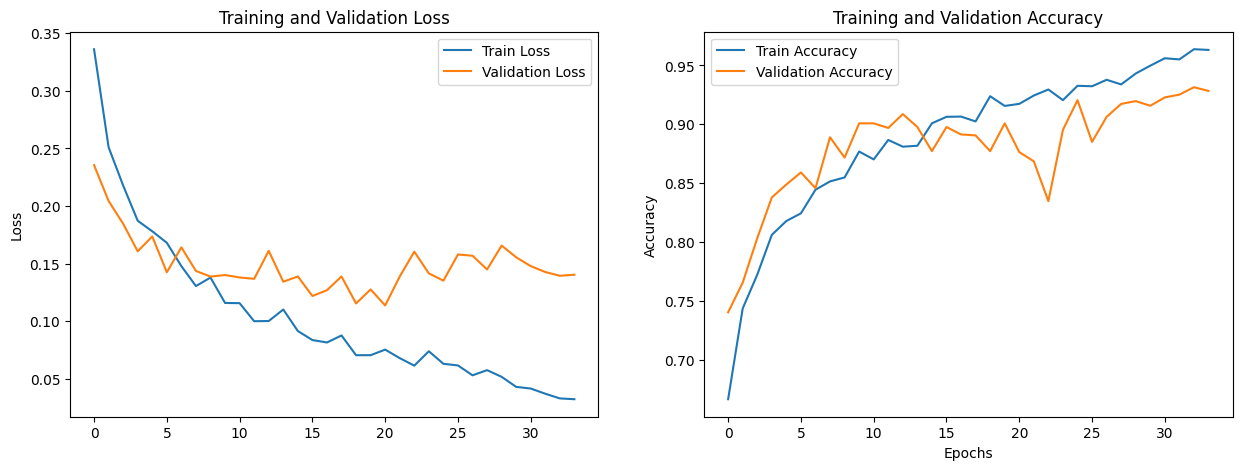

In [ ]:
plot_metrics(efficientnet_b2[1])

100%|██████████| 40/40 [00:30<00:00,  1.31it/s]



Test Loss: 0.2554 Acc: 0.9189, Kappa: 0.8555
Testing complete in 0m 31s




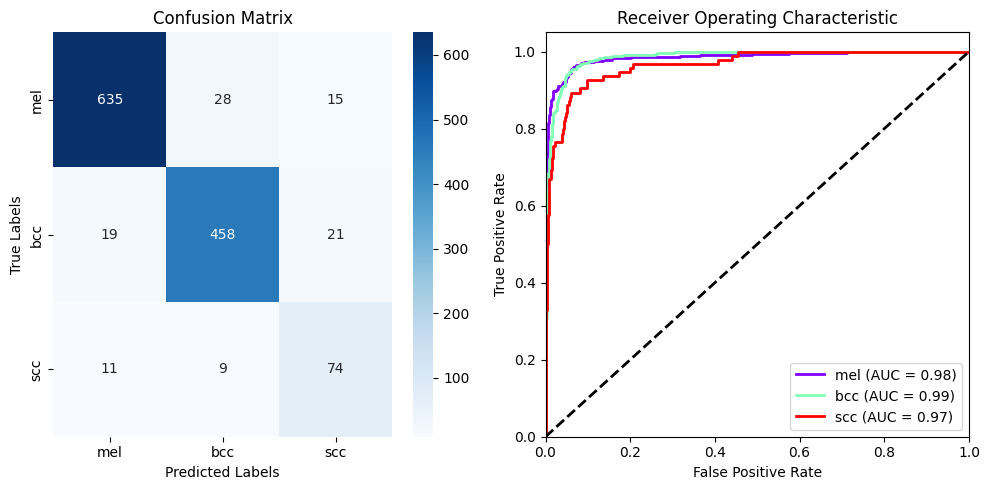

In [ ]:
# Define the EfficientNetB2 Model Structure
efficientnet_b2_model_predict =  models.efficientnet_b2(weights=None)

# Modify the classifier layer
num_ftrs = efficientnet_b2_model_predict.classifier[1].in_features
efficientnet_b2_model_predict.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
efficientnet_b2_model_predict = efficientnet_b2_model_predict.to(DEVICE)


best_model_path = TENSORBOARD_PATH + '/EfficientNetB2/efficientnetb2_fl_checkpoint_best.pth'

# Load the best model weights
efficientnet_b2_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b2_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)

# EfficientNet B2 [Weighted Cross Entropy]

In [ ]:
# Override the get_state_dict method to bypass hash check
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Remove check_hash if it exists
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/EfficientNetB2/efficientnetb2_wce.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained EfficientNet B2 model using torchvision
weights = EfficientNet_B2_Weights.DEFAULT
efficientnet_b2_model = models.efficientnet_b2(weights=weights)

# Modify the classifier layer
num_ftrs = efficientnet_b2_model.classifier[1].in_features
efficientnet_b2_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b2_model = efficientnet_b2_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_b2_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/EfficientNetB2/efficientnetb2_wce_checkpoint.pth'
efficientnet_b2 = train_model(efficientnet_b2_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.7900, acc: 0.7129, kappa: 0.5148



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

val loss : 0.4793, acc: 0.8173, kappa: 0.6815



Epoch 2/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.6134, acc: 0.7753, kappa: 0.6204



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.4657, acc: 0.8094, kappa: 0.6785



Epoch 3/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]


train loss : 0.5336, acc: 0.8099, kappa: 0.6759


100%|██████████| 40/40 [00:34<00:00,  1.18it/s]

val loss : 0.4921, acc: 0.8126, kappa: 0.6905



Epoch 4/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.4707, acc: 0.8276, kappa: 0.7055



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.3320, acc: 0.8811, kappa: 0.7875



Epoch 5/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.4448, acc: 0.8398, kappa: 0.7234



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.3667, acc: 0.8630, kappa: 0.7654

Epoch 6/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.4005, acc: 0.8591, kappa: 0.7560



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.3064, acc: 0.8961, kappa: 0.8171



Epoch 7/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.3586, acc: 0.8729, kappa: 0.7784



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.3131, acc: 0.8772, kappa: 0.7853



Epoch 8/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.3379, acc: 0.8853, kappa: 0.7997



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2830, acc: 0.9055, kappa: 0.8322



Epoch 9/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.3051, acc: 0.8918, kappa: 0.8109



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2852, acc: 0.8984, kappa: 0.8221



Epoch 10/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.2875, acc: 0.8969, kappa: 0.8192



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2668, acc: 0.9094, kappa: 0.8404



Epoch 11/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]


train loss : 0.2743, acc: 0.8953, kappa: 0.8168


100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2854, acc: 0.9008, kappa: 0.8251



Epoch 12/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.2384, acc: 0.9140, kappa: 0.8488



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2318, acc: 0.9213, kappa: 0.8582



Epoch 13/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.2419, acc: 0.9126, kappa: 0.8462



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2762, acc: 0.9031, kappa: 0.8293



Epoch 14/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.2308, acc: 0.9164, kappa: 0.8526



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2337, acc: 0.9205, kappa: 0.8594



Epoch 15/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.2209, acc: 0.9242, kappa: 0.8664



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.2445, acc: 0.9173, kappa: 0.8548



Epoch 16/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.2108, acc: 0.9237, kappa: 0.8651



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


val loss : 0.2332, acc: 0.9244, kappa: 0.8660

Epoch 17/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.2020, acc: 0.9276, kappa: 0.8718



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2246, acc: 0.9307, kappa: 0.8765



Epoch 18/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1896, acc: 0.9313, kappa: 0.8784



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2355, acc: 0.9283, kappa: 0.8729



Epoch 19/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]


train loss : 0.1599, acc: 0.9441, kappa: 0.9007


100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2243, acc: 0.9276, kappa: 0.8709



Epoch 20/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.1533, acc: 0.9482, kappa: 0.9079



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2849, acc: 0.9087, kappa: 0.8369



Epoch 21/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.1430, acc: 0.9514, kappa: 0.9137



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2853, acc: 0.9189, kappa: 0.8572



Epoch 22/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1603, acc: 0.9439, kappa: 0.9006



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2527, acc: 0.9189, kappa: 0.8572



Epoch 23/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.1528, acc: 0.9447, kappa: 0.9018



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2473, acc: 0.9189, kappa: 0.8560



Epoch 24/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]


train loss : 0.1425, acc: 0.9500, kappa: 0.9109


100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2247, acc: 0.9394, kappa: 0.8918



Epoch 25/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.1329, acc: 0.9555, kappa: 0.9209



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2480, acc: 0.9260, kappa: 0.8695



Epoch 26/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.1208, acc: 0.9585, kappa: 0.9261



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2496, acc: 0.9220, kappa: 0.8617



Epoch 27/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.1361, acc: 0.9490, kappa: 0.9094



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2746, acc: 0.9142, kappa: 0.8490



Epoch 28/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]


train loss : 0.1157, acc: 0.9614, kappa: 0.9312


100%|██████████| 40/40 [00:34<00:00,  1.18it/s]

val loss : 0.2356, acc: 0.9339, kappa: 0.8828



Epoch 29/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.0936, acc: 0.9665, kappa: 0.9404



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2086, acc: 0.9362, kappa: 0.8869



Epoch 30/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.0785, acc: 0.9717, kappa: 0.9494



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2174, acc: 0.9362, kappa: 0.8870



Epoch 31/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0825, acc: 0.9736, kappa: 0.9528



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2174, acc: 0.9370, kappa: 0.8888



Epoch 32/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.0713, acc: 0.9760, kappa: 0.9570



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2078, acc: 0.9394, kappa: 0.8924



Epoch 33/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0768, acc: 0.9740, kappa: 0.9536



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2042, acc: 0.9378, kappa: 0.8899



Epoch 34/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.0814, acc: 0.9715, kappa: 0.9490



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2042, acc: 0.9394, kappa: 0.8922



Epoch 35/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0635, acc: 0.9786, kappa: 0.9616



100%|██████████| 40/40 [00:34<00:00,  1.18it/s]


val loss : 0.1944, acc: 0.9394, kappa: 0.8921

Epoch 36/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.0645, acc: 0.9744, kappa: 0.9542



100%|██████████| 40/40 [00:34<00:00,  1.18it/s]

val loss : 0.1933, acc: 0.9449, kappa: 0.9019



Epoch 37/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0690, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2078, acc: 0.9362, kappa: 0.8872



Epoch 38/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.29it/s]

train loss : 0.0609, acc: 0.9787, kappa: 0.9619



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.1997, acc: 0.9417, kappa: 0.8967



Epoch 39/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.0622, acc: 0.9770, kappa: 0.9588



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.1911, acc: 0.9425, kappa: 0.8976



Epoch 40/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0629, acc: 0.9762, kappa: 0.9574



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2009, acc: 0.9433, kappa: 0.8993



Epoch 41/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.0689, acc: 0.9784, kappa: 0.9612



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2080, acc: 0.9417, kappa: 0.8966



Epoch 42/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.0639, acc: 0.9774, kappa: 0.9595



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.2020, acc: 0.9402, kappa: 0.8933



Epoch 43/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.0506, acc: 0.9841, kappa: 0.9714



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2003, acc: 0.9433, kappa: 0.8993



Epoch 44/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]


train loss : 0.0613, acc: 0.9809, kappa: 0.9658


100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.1980, acc: 0.9433, kappa: 0.8985



Epoch 45/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.0566, acc: 0.9807, kappa: 0.9654



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2143, acc: 0.9362, kappa: 0.8870



Epoch 46/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.0553, acc: 0.9813, kappa: 0.9665



100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

val loss : 0.2206, acc: 0.9409, kappa: 0.8955



Epoch 47/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0587, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.2160, acc: 0.9402, kappa: 0.8937



Epoch 48/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.0531, acc: 0.9813, kappa: 0.9665



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2092, acc: 0.9394, kappa: 0.8915



Epoch 49/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0487, acc: 0.9837, kappa: 0.9707



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


val loss : 0.2086, acc: 0.9386, kappa: 0.8905

Epoch 50/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0546, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2033, acc: 0.9409, kappa: 0.8950



Epoch 51/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.0543, acc: 0.9843, kappa: 0.9718



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2253, acc: 0.9402, kappa: 0.8935



Epoch 52/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.0514, acc: 0.9817, kappa: 0.9672



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2020, acc: 0.9441, kappa: 0.8999


EARLY STOP AFTER 52 EPOCHS
Training complete in 149m 58s
Best val loss: 0.191068
Best val Kappa: 0.9018503797915562


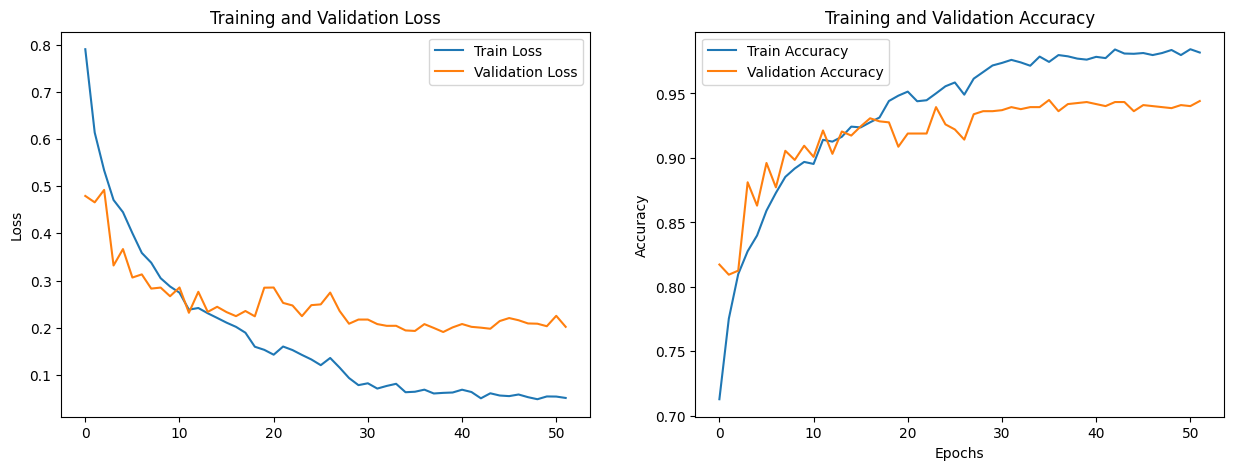

In [ ]:
plot_metrics(efficientnet_b2[1])

100%|██████████| 40/40 [00:28<00:00,  1.42it/s]



Test Loss: 0.2311 Acc: 0.9339, Kappa: 0.8820
Testing complete in 0m 28s




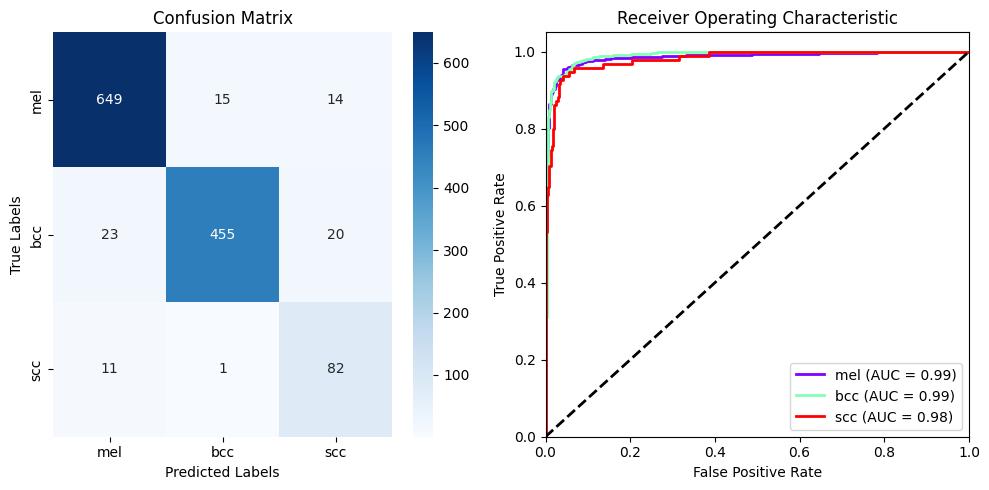

In [ ]:
# Define the EfficientNetB2 Model Structure
efficientnet_b2_model_predict =  models.efficientnet_b2(weights=None)

# Modify the classifier layer
num_ftrs = efficientnet_b2_model_predict.classifier[1].in_features
efficientnet_b2_model_predict.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
efficientnet_b2_model_predict = efficientnet_b2_model_predict.to(DEVICE)


best_model_path = TENSORBOARD_PATH + '/EfficientNetB2/efficientnetb2_wce_checkpoint_best.pth'

# Load the best model weights
efficientnet_b2_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b2_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)

# EfficientNet B4 [Focal Loss]

In [ ]:


# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/EfficientNetB4/efficientnetb4_fl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained EfficientNet B4 model using torchvision
weights = EfficientNet_B4_Weights.DEFAULT
efficientnet_b4_model = models.efficientnet_b4(weights=weights)

# Modify the classifier layer
num_ftrs = efficientnet_b4_model.classifier[1].in_features
efficientnet_b4_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b4_model = efficientnet_b4_model.to(DEVICE)

# The rest of your settings and hyperparameters
# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.Adam(efficientnet_b4_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/EfficientNetB4/efficientnetb4_fl_checkpoint.pth'
efficientnet_b4 = train_model(efficientnet_b4_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 196MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.12it/s]

train loss : 0.4238, acc: 0.5689, kappa: 0.3137



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.3413, acc: 0.6598, kappa: 0.4514

Epoch 2/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.3092, acc: 0.6926, kappa: 0.5004



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2747, acc: 0.7189, kappa: 0.5445



Epoch 3/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.2714, acc: 0.7237, kappa: 0.5497



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.2453, acc: 0.7724, kappa: 0.6206

Epoch 4/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.2451, acc: 0.7562, kappa: 0.6003



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2237, acc: 0.7898, kappa: 0.6470



Epoch 5/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.2257, acc: 0.7725, kappa: 0.6224



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2148, acc: 0.8134, kappa: 0.6777



Epoch 6/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.2073, acc: 0.7887, kappa: 0.6474



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.2253, acc: 0.8339, kappa: 0.7071



Epoch 7/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]


train loss : 0.1880, acc: 0.8007, kappa: 0.6650


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.1883, acc: 0.8465, kappa: 0.7349



Epoch 8/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.1722, acc: 0.8184, kappa: 0.6926



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1999, acc: 0.8394, kappa: 0.7201



Epoch 9/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1715, acc: 0.8111, kappa: 0.6810



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1797, acc: 0.8598, kappa: 0.7551



Epoch 10/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1580, acc: 0.8286, kappa: 0.7087



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.1731, acc: 0.8417, kappa: 0.7291

Epoch 11/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.1483, acc: 0.8367, kappa: 0.7209



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1792, acc: 0.8496, kappa: 0.7409



Epoch 12/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.1467, acc: 0.8363, kappa: 0.7210



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1787, acc: 0.8543, kappa: 0.7462

Epoch 13/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.1349, acc: 0.8485, kappa: 0.7400



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.1769, acc: 0.8780, kappa: 0.7828

Epoch 14/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.1358, acc: 0.8510, kappa: 0.7448



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1634, acc: 0.8575, kappa: 0.7534



Epoch 15/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]


train loss : 0.1328, acc: 0.8585, kappa: 0.7572


100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.1555, acc: 0.8535, kappa: 0.7484



Epoch 16/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.1274, acc: 0.8603, kappa: 0.7589



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.1625, acc: 0.8732, kappa: 0.7782

Epoch 17/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.1166, acc: 0.8729, kappa: 0.7798



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1604, acc: 0.8630, kappa: 0.7626



Epoch 18/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.1077, acc: 0.8806, kappa: 0.7925



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1634, acc: 0.8740, kappa: 0.7816

Epoch 19/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1027, acc: 0.8849, kappa: 0.8005



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1613, acc: 0.8787, kappa: 0.7882



Epoch 20/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.0989, acc: 0.8933, kappa: 0.8133



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1483, acc: 0.8685, kappa: 0.7719



Epoch 21/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.0934, acc: 0.8906, kappa: 0.8096



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]


val loss : 0.1684, acc: 0.8945, kappa: 0.8134

Epoch 22/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1026, acc: 0.8918, kappa: 0.8119



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1597, acc: 0.8835, kappa: 0.7961



Epoch 23/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.0870, acc: 0.9032, kappa: 0.8306



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1397, acc: 0.8858, kappa: 0.8004



Epoch 24/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.0879, acc: 0.9000, kappa: 0.8249



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.1482, acc: 0.8913, kappa: 0.8089



Epoch 25/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.09it/s]

train loss : 0.0773, acc: 0.9048, kappa: 0.8328



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1482, acc: 0.9024, kappa: 0.8272



Epoch 26/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.0789, acc: 0.9118, kappa: 0.8450



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.1601, acc: 0.8906, kappa: 0.8078

Epoch 27/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.0707, acc: 0.9154, kappa: 0.8512



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1394, acc: 0.8882, kappa: 0.8054

Epoch 28/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.0601, acc: 0.9250, kappa: 0.8674



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.1529, acc: 0.9063, kappa: 0.8341



Epoch 29/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.0705, acc: 0.9195, kappa: 0.8584



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.1724, acc: 0.9047, kappa: 0.8303

Epoch 30/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.0677, acc: 0.9179, kappa: 0.8556



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1530, acc: 0.8976, kappa: 0.8210



Epoch 31/100
---------------


100%|██████████| 318/318 [02:35<00:00,  2.04it/s]

train loss : 0.0632, acc: 0.9235, kappa: 0.8650



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1553, acc: 0.9087, kappa: 0.8381

Epoch 32/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0596, acc: 0.9248, kappa: 0.8675



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1625, acc: 0.9031, kappa: 0.8294

Epoch 33/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.0592, acc: 0.9325, kappa: 0.8806



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


val loss : 0.1580, acc: 0.9118, kappa: 0.8438

Epoch 34/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0603, acc: 0.9351, kappa: 0.8852



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1781, acc: 0.9016, kappa: 0.8237

Epoch 35/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0585, acc: 0.9345, kappa: 0.8845



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]


val loss : 0.1598, acc: 0.9189, kappa: 0.8551

Epoch 36/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.08it/s]

train loss : 0.0531, acc: 0.9374, kappa: 0.8894



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


val loss : 0.1733, acc: 0.9087, kappa: 0.8365

Epoch 37/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0539, acc: 0.9357, kappa: 0.8862



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


val loss : 0.1781, acc: 0.9118, kappa: 0.8417

Epoch 38/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0523, acc: 0.9418, kappa: 0.8968



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]


val loss : 0.1669, acc: 0.9157, kappa: 0.8497

Epoch 39/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.0444, acc: 0.9431, kappa: 0.8992



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1718, acc: 0.9118, kappa: 0.8425



Epoch 40/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.0526, acc: 0.9404, kappa: 0.8944



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.1616, acc: 0.9134, kappa: 0.8457
EARLY STOP AFTER 40 EPOCHS
Training complete in 126m 4s
Best val loss: 0.139356
Best val Kappa: 0.8551268761185831


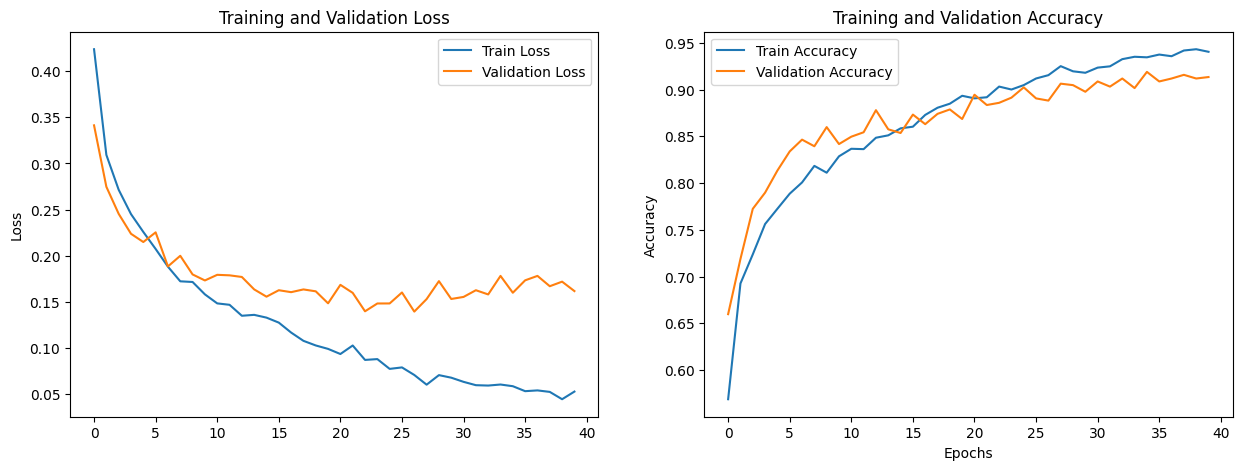

In [ ]:
plot_metrics(efficientnet_b4[1])

100%|██████████| 40/40 [00:29<00:00,  1.35it/s]



Test Loss: 0.3028 Acc: 0.9094, Kappa: 0.8385
Testing complete in 0m 30s




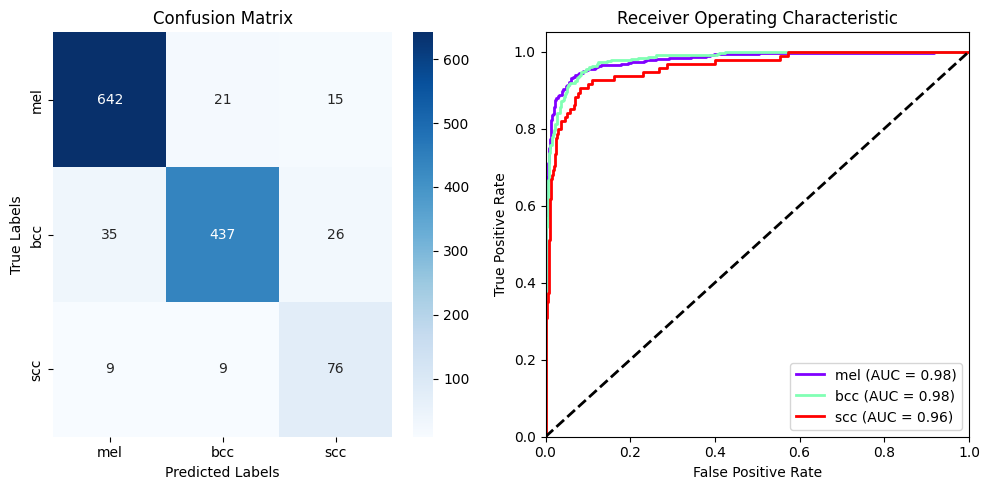

In [ ]:
# Define the EfficientNetB4 Model Structure
efficientnet_b4_model_predict = models.efficientnet_b4(weights=None)

# Modify the classifier layer
num_ftrs = efficientnet_b4_model_predict.classifier[1].in_features
efficientnet_b4_model_predict.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b4_model_predict = efficientnet_b4_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/EfficientNetB4/efficientnetb4_fl_checkpoint_best.pth'

# Load the best model weights
efficientnet_b4_model_predict.load_state_dict(torch.load(best_model_path))



# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b4_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# EfficientNet B4 [Weighted Cross Entropy]


In [ ]:
# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/EfficientNetB4/efficientnetb4_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained EfficientNet B4 model using torchvision
weights = EfficientNet_B4_Weights.DEFAULT
efficientnet_b4_model = models.efficientnet_b4(weights=weights)

# Modify the classifier layer
num_ftrs = efficientnet_b4_model.classifier[1].in_features
efficientnet_b4_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b4_model = efficientnet_b4_model.to(DEVICE)

# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_b4_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/EfficientNetB4/efficientnetb4_wce_checkpoint.pth'
efficientnet_b4 = train_model(efficientnet_b4_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.9414, acc: 0.6747, kappa: 0.4227



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.5968, acc: 0.7819, kappa: 0.6062



Epoch 2/100
---------------


100%|██████████| 318/318 [02:38<00:00,  2.01it/s]

train loss : 0.7281, acc: 0.7521, kappa: 0.5762



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.5562, acc: 0.7748, kappa: 0.6229



Epoch 3/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.6429, acc: 0.7731, kappa: 0.6157



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.4727, acc: 0.8236, kappa: 0.6931



Epoch 4/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.5758, acc: 0.7948, kappa: 0.6502



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.4669, acc: 0.8055, kappa: 0.6728



Epoch 5/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.5394, acc: 0.8074, kappa: 0.6700



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.4288, acc: 0.8236, kappa: 0.6982

Epoch 6/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.5127, acc: 0.8125, kappa: 0.6790



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


val loss : 0.3955, acc: 0.8528, kappa: 0.7435

Epoch 7/100
---------------


100%|██████████| 318/318 [02:39<00:00,  1.99it/s]

train loss : 0.4538, acc: 0.8426, kappa: 0.7293



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


val loss : 0.3782, acc: 0.8598, kappa: 0.7529

Epoch 8/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.08it/s]

train loss : 0.4456, acc: 0.8379, kappa: 0.7214



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.3640, acc: 0.8669, kappa: 0.7648



Epoch 9/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.4338, acc: 0.8459, kappa: 0.7338



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.3669, acc: 0.8669, kappa: 0.7663



Epoch 10/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.3955, acc: 0.8501, kappa: 0.7415



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.3497, acc: 0.8701, kappa: 0.7722



Epoch 11/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.3743, acc: 0.8615, kappa: 0.7601



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.3566, acc: 0.8701, kappa: 0.7729



Epoch 12/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.3610, acc: 0.8749, kappa: 0.7818



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.3529, acc: 0.8748, kappa: 0.7795



Epoch 13/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.3369, acc: 0.8819, kappa: 0.7941



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.3510, acc: 0.8740, kappa: 0.7789



Epoch 14/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]


train loss : 0.3145, acc: 0.8855, kappa: 0.8005


100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.3349, acc: 0.8811, kappa: 0.7901



Epoch 15/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.3115, acc: 0.8855, kappa: 0.7999



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.3762, acc: 0.8724, kappa: 0.7774

Epoch 16/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.08it/s]

train loss : 0.2924, acc: 0.8947, kappa: 0.8161



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.3628, acc: 0.8638, kappa: 0.7641



Epoch 17/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.08it/s]

train loss : 0.2920, acc: 0.8928, kappa: 0.8122



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2908, acc: 0.8858, kappa: 0.7982



Epoch 18/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.2593, acc: 0.9063, kappa: 0.8354



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.3199, acc: 0.8874, kappa: 0.8011



Epoch 19/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.2635, acc: 0.9042, kappa: 0.8317



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.3151, acc: 0.8976, kappa: 0.8188



Epoch 20/100
---------------


100%|██████████| 318/318 [02:35<00:00,  2.04it/s]

train loss : 0.2391, acc: 0.9134, kappa: 0.8474



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


val loss : 0.2840, acc: 0.9016, kappa: 0.8262

Epoch 21/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.05it/s]

train loss : 0.2144, acc: 0.9199, kappa: 0.8588



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.3036, acc: 0.9071, kappa: 0.8336



Epoch 22/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.2407, acc: 0.9077, kappa: 0.8379



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.2902, acc: 0.8929, kappa: 0.8096

Epoch 23/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.2010, acc: 0.9225, kappa: 0.8632



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


val loss : 0.3196, acc: 0.8984, kappa: 0.8202

Epoch 24/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.2094, acc: 0.9183, kappa: 0.8561



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2758, acc: 0.9047, kappa: 0.8312



Epoch 25/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.10it/s]

train loss : 0.1866, acc: 0.9276, kappa: 0.8720



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2717, acc: 0.9102, kappa: 0.8394



Epoch 26/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1857, acc: 0.9333, kappa: 0.8818



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2809, acc: 0.9102, kappa: 0.8391



Epoch 27/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1835, acc: 0.9362, kappa: 0.8870



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.2904, acc: 0.9134, kappa: 0.8459



Epoch 28/100
---------------


100%|██████████| 318/318 [02:31<00:00,  2.09it/s]

train loss : 0.1819, acc: 0.9325, kappa: 0.8806



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2682, acc: 0.9110, kappa: 0.8400



Epoch 29/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.96it/s]

train loss : 0.1763, acc: 0.9360, kappa: 0.8866



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2855, acc: 0.9047, kappa: 0.8285



Epoch 30/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1590, acc: 0.9437, kappa: 0.9002



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


val loss : 0.2659, acc: 0.9134, kappa: 0.8458

Epoch 31/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.1697, acc: 0.9459, kappa: 0.9037



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2571, acc: 0.9126, kappa: 0.8434



Epoch 32/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1273, acc: 0.9536, kappa: 0.9172



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2836, acc: 0.9126, kappa: 0.8444



Epoch 33/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1464, acc: 0.9490, kappa: 0.9095



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.3063, acc: 0.8969, kappa: 0.8135



Epoch 34/100
---------------


100%|██████████| 318/318 [02:35<00:00,  2.05it/s]

train loss : 0.1499, acc: 0.9481, kappa: 0.9077



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.2400, acc: 0.9260, kappa: 0.8669



Epoch 35/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]

train loss : 0.1369, acc: 0.9494, kappa: 0.9100



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


val loss : 0.2505, acc: 0.9197, kappa: 0.8549

Epoch 36/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1326, acc: 0.9526, kappa: 0.9157



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2451, acc: 0.9228, kappa: 0.8608



Epoch 37/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]


train loss : 0.1199, acc: 0.9543, kappa: 0.9187


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


val loss : 0.2524, acc: 0.9220, kappa: 0.8608

Epoch 38/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1271, acc: 0.9553, kappa: 0.9206



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.2579, acc: 0.9197, kappa: 0.8563

Epoch 39/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.1282, acc: 0.9540, kappa: 0.9180



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2413, acc: 0.9236, kappa: 0.8629



Epoch 40/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]

train loss : 0.1117, acc: 0.9591, kappa: 0.9268



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.2564, acc: 0.9189, kappa: 0.8557

Epoch 41/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.1180, acc: 0.9614, kappa: 0.9314



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.2621, acc: 0.9228, kappa: 0.8615

Epoch 42/100
---------------


100%|██████████| 318/318 [02:35<00:00,  2.05it/s]

train loss : 0.1149, acc: 0.9589, kappa: 0.9267



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]


val loss : 0.2913, acc: 0.9126, kappa: 0.8434

Epoch 43/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.08it/s]

train loss : 0.1056, acc: 0.9648, kappa: 0.9371



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


val loss : 0.2843, acc: 0.9157, kappa: 0.8486

Epoch 44/100
---------------


100%|██████████| 318/318 [02:33<00:00,  2.07it/s]


train loss : 0.1031, acc: 0.9610, kappa: 0.9304


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2659, acc: 0.9260, kappa: 0.8667



Epoch 45/100
---------------


100%|██████████| 318/318 [02:32<00:00,  2.09it/s]

train loss : 0.0935, acc: 0.9675, kappa: 0.9420



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


val loss : 0.2577, acc: 0.9299, kappa: 0.8738

Epoch 46/100
---------------


100%|██████████| 318/318 [02:34<00:00,  2.06it/s]


train loss : 0.0922, acc: 0.9667, kappa: 0.9406


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.2615, acc: 0.9220, kappa: 0.8601



Epoch 47/100
---------------


100%|██████████| 318/318 [02:30<00:00,  2.11it/s]

train loss : 0.0861, acc: 0.9699, kappa: 0.9462



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2645, acc: 0.9213, kappa: 0.8583


EARLY STOP AFTER 47 EPOCHS
Training complete in 149m 17s
Best val loss: 0.239970
Best val Kappa: 0.8738335491360449


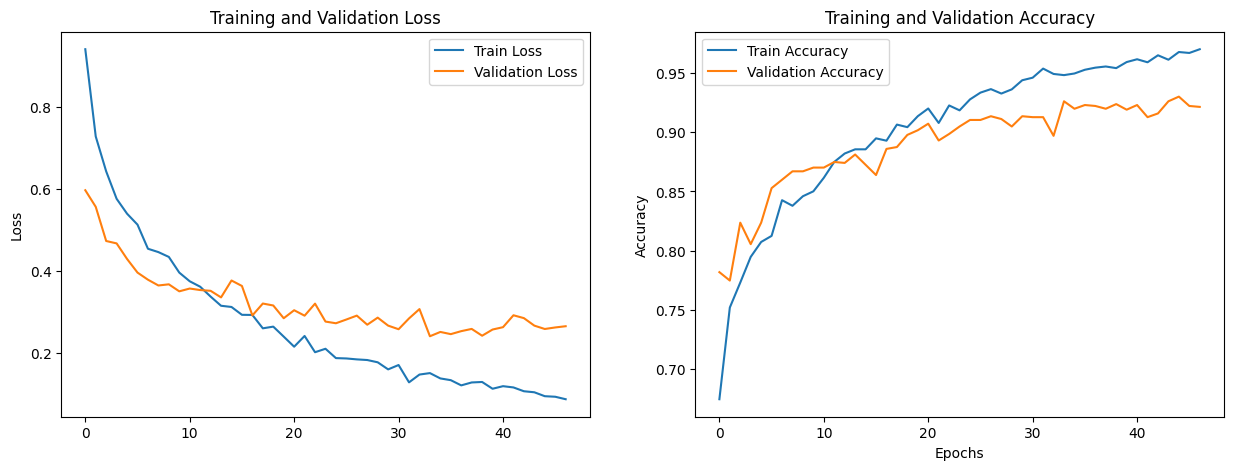

In [ ]:
plot_metrics(efficientnet_b4[1])

100%|██████████| 40/40 [00:46<00:00,  1.17s/it]



Test Loss: 0.3231 Acc: 0.9118, Kappa: 0.8427
Testing complete in 0m 47s




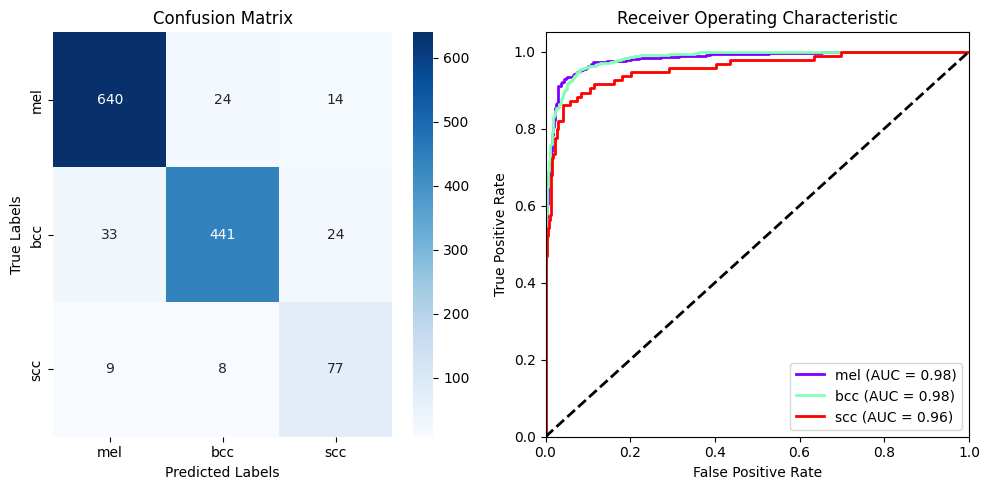

In [ ]:
# Define the EfficientNetB4 Model Structure
efficientnet_b4_model_predict = models.efficientnet_b4(weights=None)

# Modify the classifier layer
num_ftrs = efficientnet_b4_model_predict.classifier[1].in_features
efficientnet_b4_model_predict.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_b4_model_predict = efficientnet_b4_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/EfficientNetB4/efficientnetb4_wce_checkpoint_best.pth'

# Load the best model weights
efficientnet_b4_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b4_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# Swin Transformer S [Focal Loss]

In [ ]:



# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerS/swin_transformer_s_fl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Small model using torchvision
weights = Swin_S_Weights.DEFAULT
swin_transformer_s_model = models.swin_s(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_s_model.head.in_features
swin_transformer_s_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_s_model = swin_transformer_s_model.to(DEVICE)

# The rest of your settings and hyperparameters
# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha=class_weights, gamma=2.0, size_average=True)
optimizer = optim.Adam(swin_transformer_s_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerS/swin_transformer_s_fl_checkpoint.pth'
swin_transformer_s = train_model(swin_transformer_s_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [02:56<00:00,  1.80it/s]

train loss : 0.3575, acc: 0.6303, kappa: 0.4190



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2848, acc: 0.7551, kappa: 0.5944



Epoch 2/100
---------------


100%|██████████| 318/318 [02:36<00:00,  2.03it/s]

train loss : 0.2769, acc: 0.7328, kappa: 0.5638



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2575, acc: 0.6063, kappa: 0.4291



Epoch 3/100
---------------


100%|██████████| 318/318 [02:38<00:00,  2.01it/s]

train loss : 0.2338, acc: 0.7649, kappa: 0.6122



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2316, acc: 0.7339, kappa: 0.5799



Epoch 4/100
---------------


100%|██████████| 318/318 [02:38<00:00,  2.00it/s]

train loss : 0.2353, acc: 0.7651, kappa: 0.6139



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2162, acc: 0.7449, kappa: 0.5954



Epoch 5/100
---------------


100%|██████████| 318/318 [02:37<00:00,  2.02it/s]

train loss : 0.2146, acc: 0.7934, kappa: 0.6554



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.1799, acc: 0.8378, kappa: 0.7226



Epoch 6/100
---------------


100%|██████████| 318/318 [02:37<00:00,  2.02it/s]

train loss : 0.1902, acc: 0.8139, kappa: 0.6868



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.1842, acc: 0.8646, kappa: 0.7630



Epoch 7/100
---------------


100%|██████████| 318/318 [02:37<00:00,  2.02it/s]

train loss : 0.1723, acc: 0.8276, kappa: 0.7080



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1594, acc: 0.8772, kappa: 0.7848



Epoch 8/100
---------------


100%|██████████| 318/318 [02:37<00:00,  2.01it/s]

train loss : 0.1731, acc: 0.8320, kappa: 0.7159



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2085, acc: 0.7126, kappa: 0.5514



Epoch 9/100
---------------


100%|██████████| 318/318 [02:37<00:00,  2.02it/s]

train loss : 0.1519, acc: 0.8440, kappa: 0.7339



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.1634, acc: 0.8709, kappa: 0.7759



Epoch 10/100
---------------


100%|██████████| 318/318 [02:38<00:00,  2.00it/s]

train loss : 0.1610, acc: 0.8471, kappa: 0.7394



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1614, acc: 0.8480, kappa: 0.7407



Epoch 11/100
---------------


100%|██████████| 318/318 [02:38<00:00,  2.01it/s]


train loss : 0.1516, acc: 0.8514, kappa: 0.7458


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.1903, acc: 0.8827, kappa: 0.7908



Epoch 12/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]


train loss : 0.1403, acc: 0.8569, kappa: 0.7559


100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1667, acc: 0.8268, kappa: 0.7077



Epoch 13/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.1266, acc: 0.8723, kappa: 0.7809



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1643, acc: 0.7945, kappa: 0.6686



Epoch 14/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.1337, acc: 0.8579, kappa: 0.7571



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1618, acc: 0.8638, kappa: 0.7640



Epoch 15/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.1183, acc: 0.8788, kappa: 0.7905



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1603, acc: 0.8339, kappa: 0.7206



Epoch 16/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.96it/s]

train loss : 0.0911, acc: 0.8996, kappa: 0.8260



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1232, acc: 0.9079, kappa: 0.8375



Epoch 17/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.99it/s]

train loss : 0.0643, acc: 0.9278, kappa: 0.8734



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1303, acc: 0.9181, kappa: 0.8549



Epoch 18/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]


train loss : 0.0575, acc: 0.9368, kappa: 0.8888


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1350, acc: 0.9087, kappa: 0.8391



Epoch 19/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]

train loss : 0.0564, acc: 0.9327, kappa: 0.8817



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

val loss : 0.1203, acc: 0.9236, kappa: 0.8645



Epoch 20/100
---------------


100%|██████████| 318/318 [02:43<00:00,  1.95it/s]

train loss : 0.0434, acc: 0.9467, kappa: 0.9057



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1222, acc: 0.9094, kappa: 0.8409



Epoch 21/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.96it/s]

train loss : 0.0503, acc: 0.9414, kappa: 0.8964



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1169, acc: 0.9252, kappa: 0.8675



Epoch 22/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]

train loss : 0.0464, acc: 0.9465, kappa: 0.9055



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.1128, acc: 0.9189, kappa: 0.8575



Epoch 23/100
---------------


100%|██████████| 318/318 [02:39<00:00,  2.00it/s]


train loss : 0.0469, acc: 0.9465, kappa: 0.9055


100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.1181, acc: 0.9268, kappa: 0.8697



Epoch 24/100
---------------


100%|██████████| 318/318 [02:43<00:00,  1.95it/s]

train loss : 0.0389, acc: 0.9520, kappa: 0.9148



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1214, acc: 0.9252, kappa: 0.8668



Epoch 25/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0376, acc: 0.9545, kappa: 0.9193



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1170, acc: 0.9307, kappa: 0.8769



Epoch 26/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0416, acc: 0.9516, kappa: 0.9143



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1103, acc: 0.9283, kappa: 0.8722



Epoch 27/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]

train loss : 0.0392, acc: 0.9587, kappa: 0.9264



100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1043, acc: 0.9346, kappa: 0.8836



Epoch 28/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0318, acc: 0.9591, kappa: 0.9274



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1303, acc: 0.9339, kappa: 0.8819



Epoch 29/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.99it/s]


train loss : 0.0373, acc: 0.9634, kappa: 0.9350


100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1075, acc: 0.9386, kappa: 0.8904



Epoch 30/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.96it/s]

train loss : 0.0311, acc: 0.9626, kappa: 0.9335



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.1159, acc: 0.9260, kappa: 0.8687



Epoch 31/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]

train loss : 0.0306, acc: 0.9612, kappa: 0.9311



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1041, acc: 0.9323, kappa: 0.8807



Epoch 32/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]


train loss : 0.0323, acc: 0.9618, kappa: 0.9322


100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1240, acc: 0.9339, kappa: 0.8823



Epoch 33/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0285, acc: 0.9667, kappa: 0.9408



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1233, acc: 0.9362, kappa: 0.8868



Epoch 34/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.95it/s]

train loss : 0.0242, acc: 0.9715, kappa: 0.9491



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1241, acc: 0.9386, kappa: 0.8907



Epoch 35/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.96it/s]

train loss : 0.0261, acc: 0.9699, kappa: 0.9463



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.1298, acc: 0.9402, kappa: 0.8930



Epoch 36/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0234, acc: 0.9713, kappa: 0.9488



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.1193, acc: 0.9386, kappa: 0.8902



Epoch 37/100
---------------


100%|██████████| 318/318 [02:39<00:00,  1.99it/s]

train loss : 0.0305, acc: 0.9669, kappa: 0.9412



100%|██████████| 40/40 [00:38<00:00,  1.05it/s]

val loss : 0.1059, acc: 0.9370, kappa: 0.8871



Epoch 38/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.96it/s]

train loss : 0.0259, acc: 0.9699, kappa: 0.9463



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1089, acc: 0.9362, kappa: 0.8861



Epoch 39/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0228, acc: 0.9713, kappa: 0.9488



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.0948, acc: 0.9449, kappa: 0.9016



Epoch 40/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.95it/s]

train loss : 0.0287, acc: 0.9697, kappa: 0.9461



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.0996, acc: 0.9402, kappa: 0.8936



Epoch 41/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.96it/s]

train loss : 0.0236, acc: 0.9728, kappa: 0.9516



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1049, acc: 0.9402, kappa: 0.8933



Epoch 42/100
---------------


100%|██████████| 318/318 [02:39<00:00,  1.99it/s]


train loss : 0.0209, acc: 0.9764, kappa: 0.9578


100%|██████████| 40/40 [00:38<00:00,  1.05it/s]

val loss : 0.1188, acc: 0.9378, kappa: 0.8893



Epoch 43/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.99it/s]

train loss : 0.0197, acc: 0.9746, kappa: 0.9546



100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

val loss : 0.1456, acc: 0.9299, kappa: 0.8750



Epoch 44/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0225, acc: 0.9721, kappa: 0.9501



100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

val loss : 0.1190, acc: 0.9354, kappa: 0.8856



Epoch 45/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]

train loss : 0.0204, acc: 0.9756, kappa: 0.9564



100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1124, acc: 0.9362, kappa: 0.8868



Epoch 46/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]


train loss : 0.0187, acc: 0.9766, kappa: 0.9581


100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1146, acc: 0.9402, kappa: 0.8931



Epoch 47/100
---------------


100%|██████████| 318/318 [02:40<00:00,  1.98it/s]


train loss : 0.0174, acc: 0.9768, kappa: 0.9586


100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1401, acc: 0.9465, kappa: 0.9037



Epoch 48/100
---------------


100%|██████████| 318/318 [02:43<00:00,  1.95it/s]

train loss : 0.0165, acc: 0.9819, kappa: 0.9676



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

val loss : 0.1212, acc: 0.9480, kappa: 0.9068



Epoch 49/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]


train loss : 0.0193, acc: 0.9805, kappa: 0.9651


100%|██████████| 40/40 [00:38<00:00,  1.04it/s]

val loss : 0.1135, acc: 0.9449, kappa: 0.9014



Epoch 50/100
---------------


100%|██████████| 318/318 [02:43<00:00,  1.95it/s]

train loss : 0.0179, acc: 0.9787, kappa: 0.9620



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1088, acc: 0.9457, kappa: 0.9029



Epoch 51/100
---------------


100%|██████████| 318/318 [02:41<00:00,  1.97it/s]

train loss : 0.0184, acc: 0.9807, kappa: 0.9655



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1079, acc: 0.9465, kappa: 0.9042



Epoch 52/100
---------------


100%|██████████| 318/318 [02:43<00:00,  1.94it/s]

train loss : 0.0152, acc: 0.9809, kappa: 0.9659



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1146, acc: 0.9457, kappa: 0.9027


EARLY STOP AFTER 52 EPOCHS
Training complete in 175m 14s
Best val loss: 0.094787
Best val Kappa: 0.9067564320485552


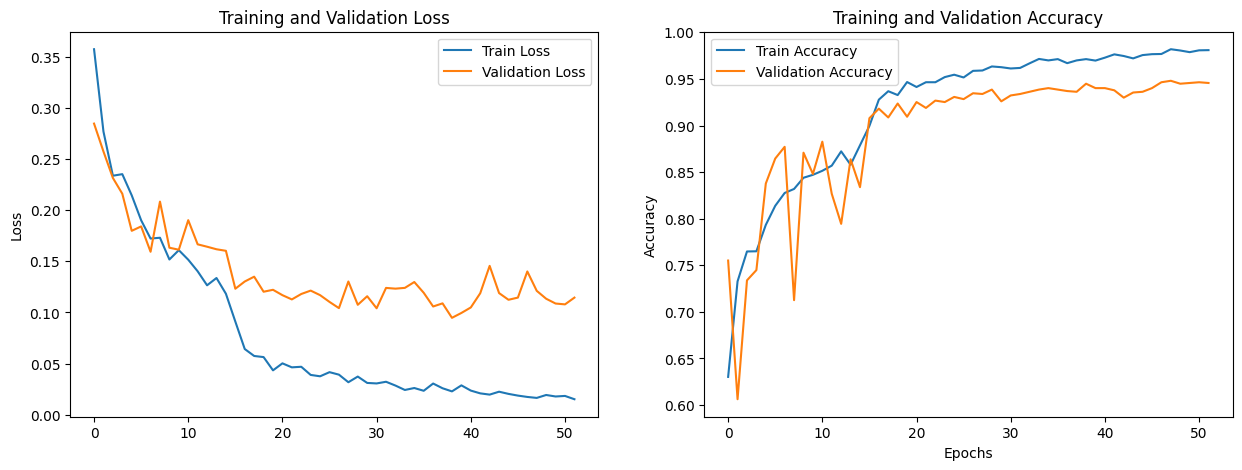

In [ ]:
plot_metrics(swin_transformer_s[1])

100%|██████████| 40/40 [00:30<00:00,  1.33it/s]



Test Loss: 0.3231 Acc: 0.9118, Kappa: 0.8427
Testing complete in 0m 30s




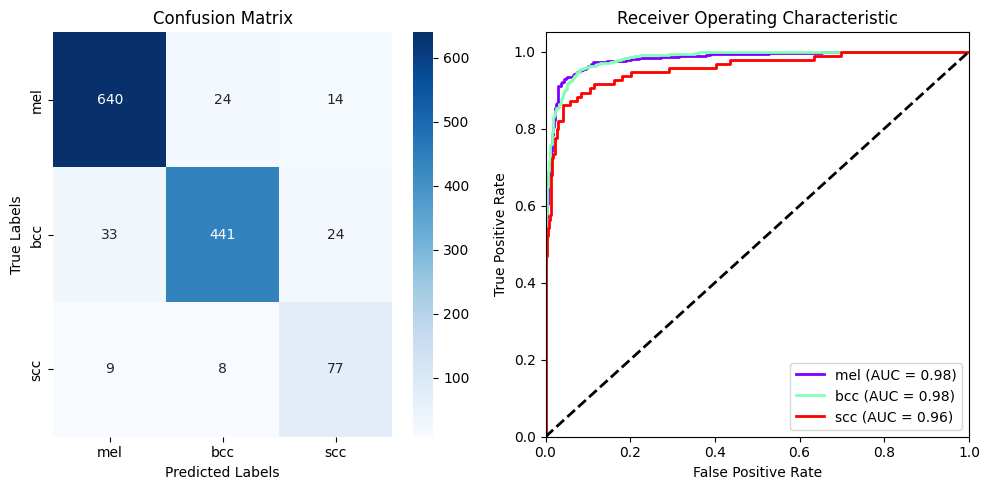

In [ ]:
# Define the EfficientNetB4 Model Structure
swin_transformer_s_model_predict = models.swin_s(weights=None)

# Modify the classifier layer

num_ftrs = swin_transformer_s_model_predict.head.in_features
swin_transformer_s_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_s_model_predict = swin_transformer_s_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerS/swin_transformer_s_fl_checkpoint_best.pth'

# Load the best model weights
swin_transformer_s_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b4_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# Swin Transorfomer S [Weighted Cross Entropy]

In [ ]:


# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerS/swin_transformer_s_wce.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Small model using torchvision
weights = Swin_S_Weights.DEFAULT
swin_transformer_s_model = models.swin_s(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_s_model.head.in_features
swin_transformer_s_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_s_model = swin_transformer_s_model.to(DEVICE)


# The rest of your settings and hyperparameters
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6


# The rest of your settings and hyperparameters
# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(swin_transformer_s_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerS/swin_transformer_s_wce_checkpoint.pth'
swin_transformer_s = train_model(swin_transformer_s_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [13:50<00:00,  2.61s/it]

train loss : 0.8490, acc: 0.6553, kappa: 0.4307



100%|██████████| 40/40 [03:16<00:00,  4.90s/it]

val loss : 0.6478, acc: 0.7173, kappa: 0.5490



Epoch 2/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.6812, acc: 0.7633, kappa: 0.5993



100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

val loss : 0.5347, acc: 0.7630, kappa: 0.6196



Epoch 3/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.6294, acc: 0.7851, kappa: 0.6346



100%|██████████| 40/40 [00:31<00:00,  1.28it/s]

val loss : 0.5875, acc: 0.7134, kappa: 0.5370



Epoch 4/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.5523, acc: 0.8072, kappa: 0.6724



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.5445, acc: 0.7961, kappa: 0.6524



Epoch 5/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.5190, acc: 0.8237, kappa: 0.6988



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.3566, acc: 0.8693, kappa: 0.7698



Epoch 6/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.4893, acc: 0.8288, kappa: 0.7065



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.3328, acc: 0.8701, kappa: 0.7747



Epoch 7/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.4526, acc: 0.8485, kappa: 0.7390



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3960, acc: 0.8646, kappa: 0.7692



Epoch 8/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.4260, acc: 0.8597, kappa: 0.7568



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.3127, acc: 0.8929, kappa: 0.8115



Epoch 9/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.3670, acc: 0.8782, kappa: 0.7882



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.3818, acc: 0.8795, kappa: 0.7879



Epoch 10/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.3454, acc: 0.8790, kappa: 0.7895



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3594, acc: 0.8827, kappa: 0.7984



Epoch 11/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.3432, acc: 0.8831, kappa: 0.7972



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.3143, acc: 0.8976, kappa: 0.8147



Epoch 12/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.3235, acc: 0.8831, kappa: 0.7975



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.4973, acc: 0.8110, kappa: 0.6865



Epoch 13/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.3218, acc: 0.8876, kappa: 0.8044



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.3991, acc: 0.8685, kappa: 0.7755



Epoch 14/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.3148, acc: 0.8953, kappa: 0.8175



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2388, acc: 0.9094, kappa: 0.8414



Epoch 15/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.2754, acc: 0.9071, kappa: 0.8372



100%|██████████| 40/40 [00:30<00:00,  1.29it/s]

val loss : 0.2371, acc: 0.9236, kappa: 0.8636



Epoch 16/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.2532, acc: 0.9134, kappa: 0.8481



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2456, acc: 0.9205, kappa: 0.8591



Epoch 17/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.2474, acc: 0.9138, kappa: 0.8488



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2543, acc: 0.9173, kappa: 0.8514



Epoch 18/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.2579, acc: 0.9109, kappa: 0.8435



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.3810, acc: 0.8654, kappa: 0.7627



Epoch 19/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.2291, acc: 0.9170, kappa: 0.8544



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2328, acc: 0.9197, kappa: 0.8575



Epoch 20/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.2054, acc: 0.9280, kappa: 0.8731



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2654, acc: 0.9189, kappa: 0.8537



Epoch 21/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.2495, acc: 0.9187, kappa: 0.8572



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.2925, acc: 0.9094, kappa: 0.8401



Epoch 22/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.2111, acc: 0.9321, kappa: 0.8803



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2445, acc: 0.9228, kappa: 0.8636



Epoch 23/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.2017, acc: 0.9286, kappa: 0.8739



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2087, acc: 0.9291, kappa: 0.8736



Epoch 24/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1898, acc: 0.9329, kappa: 0.8820



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2768, acc: 0.9134, kappa: 0.8437



Epoch 25/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.2059, acc: 0.9313, kappa: 0.8788



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.2908, acc: 0.9024, kappa: 0.8278



Epoch 26/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1778, acc: 0.9374, kappa: 0.8893



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2563, acc: 0.9268, kappa: 0.8710



Epoch 27/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.1748, acc: 0.9382, kappa: 0.8911



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2186, acc: 0.9268, kappa: 0.8685



Epoch 28/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.1925, acc: 0.9323, kappa: 0.8807



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.3286, acc: 0.9008, kappa: 0.8220



Epoch 29/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.1650, acc: 0.9431, kappa: 0.8995



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3295, acc: 0.8937, kappa: 0.8155



Epoch 30/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.1720, acc: 0.9418, kappa: 0.8968



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2307, acc: 0.9205, kappa: 0.8574



Epoch 31/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1491, acc: 0.9469, kappa: 0.9059



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.2506, acc: 0.9244, kappa: 0.8652



Epoch 32/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train loss : 0.0812, acc: 0.9703, kappa: 0.9469



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2220, acc: 0.9394, kappa: 0.8916



Epoch 33/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0623, acc: 0.9762, kappa: 0.9574



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2235, acc: 0.9409, kappa: 0.8942



Epoch 34/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.0628, acc: 0.9793, kappa: 0.9631



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2294, acc: 0.9433, kappa: 0.8979



Epoch 35/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0549, acc: 0.9799, kappa: 0.9641



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2413, acc: 0.9449, kappa: 0.9011



Epoch 36/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0574, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2278, acc: 0.9488, kappa: 0.9079


EARLY STOP AFTER 36 EPOCHS
Training complete in 116m 49s
Best val loss: 0.208679
Best val Kappa: 0.9078695374615519


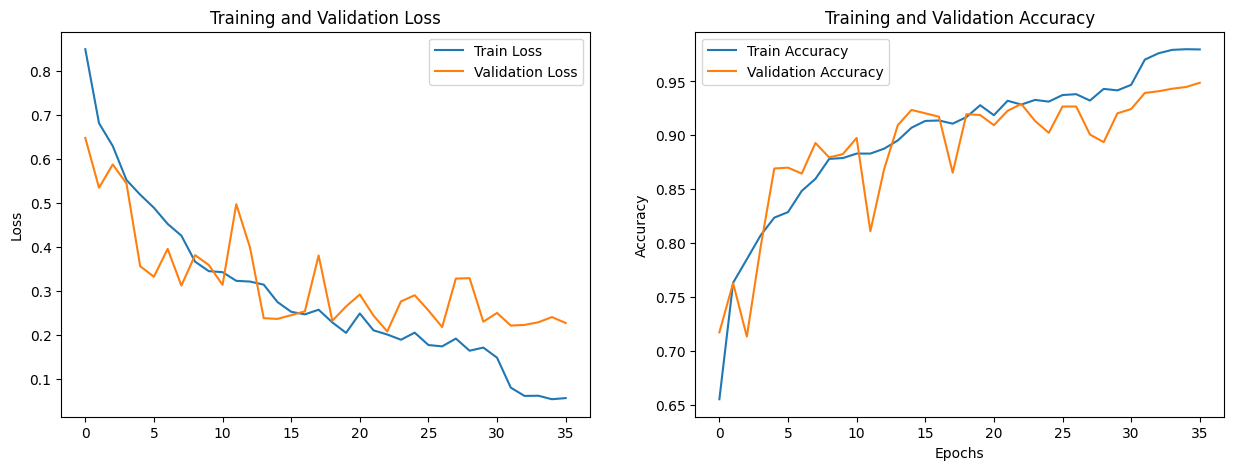

In [ ]:
plot_metrics(swin_transformer_s[1])

100%|██████████| 40/40 [00:36<00:00,  1.09it/s]



Test Loss: 0.3231 Acc: 0.9118, Kappa: 0.8427
Testing complete in 0m 37s




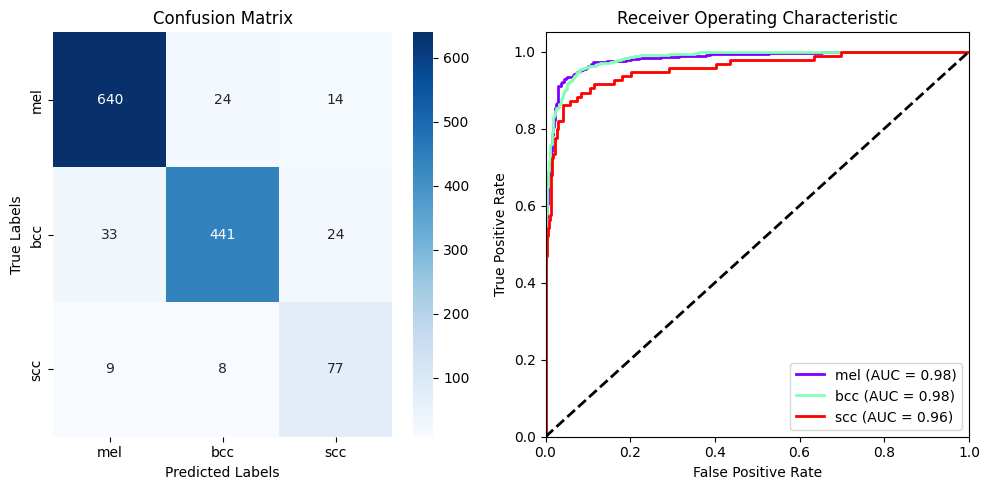

In [ ]:
# Define the EfficientNetB4 Model Structure
swin_transformer_s_model_predict = models.swin_s(weights=None)

# Modify the classifier layer

num_ftrs = swin_transformer_s_model_predict.head.in_features
swin_transformer_s_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_s_model_predict = swin_transformer_s_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerS/swin_transformer_s_wce_checkpoint_best.pth'

# Load the best model weights
swin_transformer_s_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model on the validation set
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(efficientnet_b4_model_predict, val_loader, DEVICE, criterion)


class_names = ["mel", "bcc", "scc"]
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# Swin Transformer B [Weighted Cross Entropy]


In [ ]:

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerB/swin_transformer_b_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Base model using torchvision
weights = Swin_B_Weights.DEFAULT
swin_transformer_b_model = models.swin_b(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_b_model.head.in_features
swin_transformer_b_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_b_model = swin_transformer_b_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-6

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(swin_transformer_b_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerB/swin_transformer_b_wce_checkpoint.pth'
swin_transformer_b = train_model(swin_transformer_b_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:03<00:00, 98.6MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.8164, acc: 0.7001, kappa: 0.4955



100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

val loss : 0.6817, acc: 0.6583, kappa: 0.4841



Epoch 2/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.6635, acc: 0.7515, kappa: 0.5865



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.5247, acc: 0.8181, kappa: 0.6810



Epoch 3/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.6056, acc: 0.7883, kappa: 0.6428



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.4538, acc: 0.8441, kappa: 0.7188



Epoch 4/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.5740, acc: 0.7987, kappa: 0.6585



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.3586, acc: 0.8685, kappa: 0.7685



Epoch 5/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.5549, acc: 0.7926, kappa: 0.6510



100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

val loss : 0.4401, acc: 0.8535, kappa: 0.7448



Epoch 6/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.4907, acc: 0.8262, kappa: 0.7032



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.3726, acc: 0.8756, kappa: 0.7822



Epoch 7/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.4644, acc: 0.8337, kappa: 0.7153



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.3699, acc: 0.8614, kappa: 0.7645



Epoch 8/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.4545, acc: 0.8375, kappa: 0.7226



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.2920, acc: 0.8992, kappa: 0.8163



Epoch 9/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.4310, acc: 0.8585, kappa: 0.7553



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.4930, acc: 0.8449, kappa: 0.7430



Epoch 10/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.4141, acc: 0.8603, kappa: 0.7586



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2975, acc: 0.9110, kappa: 0.8421



Epoch 11/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.3785, acc: 0.8656, kappa: 0.7679



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.4105, acc: 0.8370, kappa: 0.7264



Epoch 12/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.3656, acc: 0.8705, kappa: 0.7769



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.3505, acc: 0.8591, kappa: 0.7593



Epoch 13/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.3300, acc: 0.8843, kappa: 0.7995



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

val loss : 0.2961, acc: 0.9008, kappa: 0.8250



Epoch 14/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.72it/s]

train loss : 0.3242, acc: 0.8882, kappa: 0.8051



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

val loss : 0.2880, acc: 0.8890, kappa: 0.8070



Epoch 15/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.3230, acc: 0.8908, kappa: 0.8104



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.3214, acc: 0.9000, kappa: 0.8194



Epoch 16/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.3100, acc: 0.8898, kappa: 0.8085



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.3247, acc: 0.9008, kappa: 0.8245



Epoch 17/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.3011, acc: 0.8953, kappa: 0.8178



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.2290, acc: 0.9244, kappa: 0.8651



Epoch 18/100
---------------


100%|██████████| 318/318 [03:10<00:00,  1.67it/s]

train loss : 0.2682, acc: 0.9085, kappa: 0.8400



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2559, acc: 0.9142, kappa: 0.8491



Epoch 19/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.69it/s]

train loss : 0.2740, acc: 0.9036, kappa: 0.8321



100%|██████████| 40/40 [00:42<00:00,  1.06s/it]

val loss : 0.3289, acc: 0.8882, kappa: 0.8085



Epoch 20/100
---------------


100%|██████████| 318/318 [03:11<00:00,  1.66it/s]

train loss : 0.2718, acc: 0.9059, kappa: 0.8352



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2406, acc: 0.9283, kappa: 0.8707



Epoch 21/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.2580, acc: 0.9128, kappa: 0.8473



100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

val loss : 0.2834, acc: 0.9134, kappa: 0.8488



Epoch 22/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.2269, acc: 0.9237, kappa: 0.8653



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.2522, acc: 0.9173, kappa: 0.8542



Epoch 23/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.2200, acc: 0.9260, kappa: 0.8697



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2381, acc: 0.9220, kappa: 0.8620



Epoch 24/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.2218, acc: 0.9219, kappa: 0.8630



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.2893, acc: 0.9071, kappa: 0.8363



Epoch 25/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.2231, acc: 0.9225, kappa: 0.8640



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.3251, acc: 0.9016, kappa: 0.8239



Epoch 26/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.1416, acc: 0.9538, kappa: 0.9179



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.2066, acc: 0.9386, kappa: 0.8906



Epoch 27/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.70it/s]

train loss : 0.1022, acc: 0.9642, kappa: 0.9363



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.2006, acc: 0.9409, kappa: 0.8948



Epoch 28/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.1077, acc: 0.9638, kappa: 0.9356



100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

val loss : 0.1934, acc: 0.9433, kappa: 0.8986



Epoch 29/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0915, acc: 0.9681, kappa: 0.9431



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1982, acc: 0.9465, kappa: 0.9038



Epoch 30/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0854, acc: 0.9701, kappa: 0.9467



100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

val loss : 0.1938, acc: 0.9409, kappa: 0.8946



Epoch 31/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0845, acc: 0.9705, kappa: 0.9474



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1948, acc: 0.9441, kappa: 0.9000



Epoch 32/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0844, acc: 0.9726, kappa: 0.9513



100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

val loss : 0.1973, acc: 0.9441, kappa: 0.9001



Epoch 33/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0772, acc: 0.9738, kappa: 0.9533



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1964, acc: 0.9480, kappa: 0.9073



Epoch 34/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0703, acc: 0.9750, kappa: 0.9554



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1877, acc: 0.9496, kappa: 0.9090



Epoch 35/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.70it/s]

train loss : 0.0699, acc: 0.9784, kappa: 0.9613



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2056, acc: 0.9449, kappa: 0.9006



Epoch 36/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0750, acc: 0.9748, kappa: 0.9550



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.1856, acc: 0.9520, kappa: 0.9136



Epoch 37/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0738, acc: 0.9766, kappa: 0.9581



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1884, acc: 0.9512, kappa: 0.9123



Epoch 38/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0673, acc: 0.9774, kappa: 0.9595



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.1847, acc: 0.9488, kappa: 0.9079



Epoch 39/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0558, acc: 0.9809, kappa: 0.9658



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.1901, acc: 0.9496, kappa: 0.9093



Epoch 40/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0557, acc: 0.9784, kappa: 0.9613



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.1992, acc: 0.9528, kappa: 0.9151



Epoch 41/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0552, acc: 0.9805, kappa: 0.9651



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.1838, acc: 0.9504, kappa: 0.9108



Epoch 42/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0519, acc: 0.9805, kappa: 0.9651



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.1890, acc: 0.9535, kappa: 0.9163



Epoch 43/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0547, acc: 0.9827, kappa: 0.9690



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.1914, acc: 0.9520, kappa: 0.9137



Epoch 44/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0521, acc: 0.9799, kappa: 0.9640



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.1792, acc: 0.9543, kappa: 0.9179



Epoch 45/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0384, acc: 0.9858, kappa: 0.9746



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.1813, acc: 0.9543, kappa: 0.9177



Epoch 46/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0518, acc: 0.9805, kappa: 0.9651



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.1747, acc: 0.9575, kappa: 0.9234



Epoch 47/100
---------------


100%|██████████| 318/318 [03:11<00:00,  1.66it/s]

train loss : 0.0412, acc: 0.9852, kappa: 0.9735



100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

val loss : 0.1820, acc: 0.9567, kappa: 0.9223



Epoch 48/100
---------------


100%|██████████| 318/318 [03:14<00:00,  1.63it/s]

train loss : 0.0364, acc: 0.9870, kappa: 0.9767



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.1986, acc: 0.9583, kappa: 0.9247



Epoch 49/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.70it/s]

train loss : 0.0496, acc: 0.9847, kappa: 0.9725



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.1916, acc: 0.9591, kappa: 0.9266



Epoch 50/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.70it/s]

train loss : 0.0452, acc: 0.9854, kappa: 0.9739



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.1876, acc: 0.9543, kappa: 0.9178



Epoch 51/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0341, acc: 0.9874, kappa: 0.9774



100%|██████████| 40/40 [00:33<00:00,  1.21it/s]

val loss : 0.1874, acc: 0.9567, kappa: 0.9218



Epoch 52/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0452, acc: 0.9852, kappa: 0.9735



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.1948, acc: 0.9598, kappa: 0.9277



Epoch 53/100
---------------


100%|██████████| 318/318 [03:07<00:00,  1.69it/s]

train loss : 0.0499, acc: 0.9848, kappa: 0.9728



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.1856, acc: 0.9567, kappa: 0.9220



Epoch 54/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0374, acc: 0.9856, kappa: 0.9742



100%|██████████| 40/40 [00:31<00:00,  1.25it/s]

val loss : 0.2089, acc: 0.9543, kappa: 0.9176



Epoch 55/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0353, acc: 0.9878, kappa: 0.9781



100%|██████████| 40/40 [00:32<00:00,  1.24it/s]

val loss : 0.2059, acc: 0.9551, kappa: 0.9189



Epoch 56/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0319, acc: 0.9884, kappa: 0.9792



100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

val loss : 0.2039, acc: 0.9567, kappa: 0.9218



Epoch 57/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.70it/s]

train loss : 0.0340, acc: 0.9886, kappa: 0.9795



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.2002, acc: 0.9567, kappa: 0.9220



Epoch 58/100
---------------


100%|██████████| 318/318 [03:06<00:00,  1.71it/s]

train loss : 0.0329, acc: 0.9874, kappa: 0.9774



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.1994, acc: 0.9551, kappa: 0.9192



Epoch 59/100
---------------


100%|██████████| 318/318 [03:05<00:00,  1.71it/s]

train loss : 0.0355, acc: 0.9858, kappa: 0.9746



100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

val loss : 0.1983, acc: 0.9559, kappa: 0.9205


EARLY STOP AFTER 59 EPOCHS
Training complete in 223m 26s
Best val loss: 0.174690
Best val Kappa: 0.9277023708532393


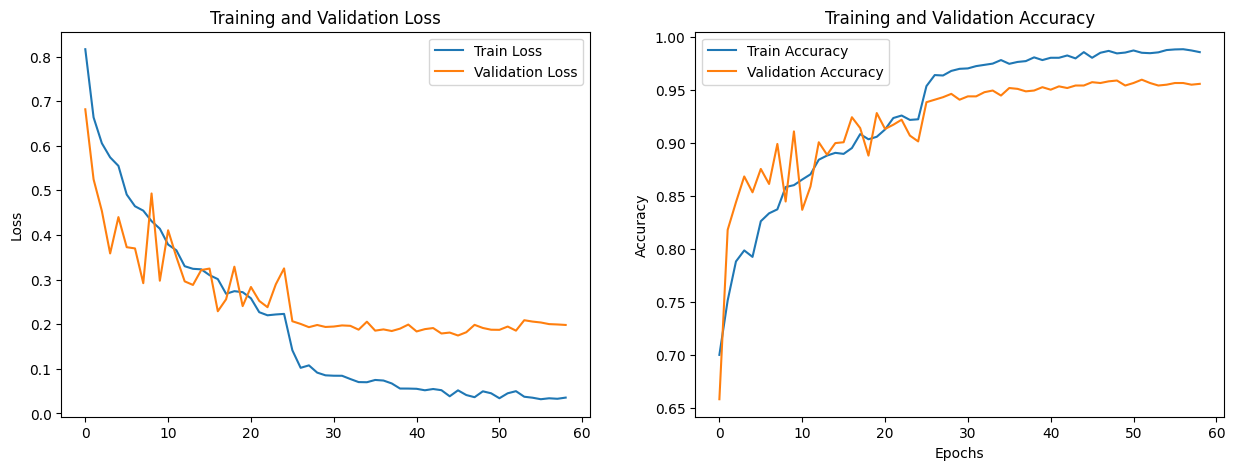

In [ ]:
plot_metrics(swin_transformer_b[1])

100%|██████████| 40/40 [00:34<00:00,  1.17it/s]



Test Loss: 0.1948 Acc: 0.9598, Kappa: 0.9277
Testing complete in 0m 34s




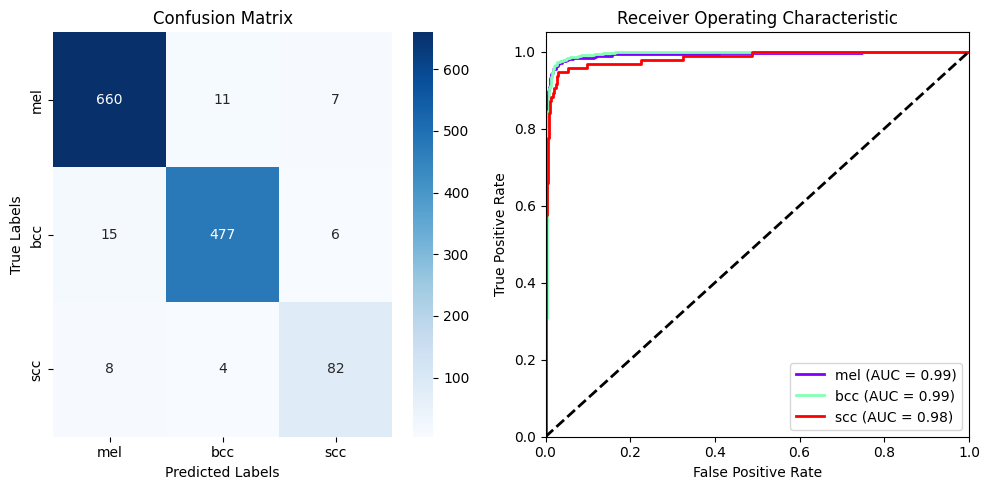

In [ ]:
from torchvision.models import swin_b
from torchvision.models.swin_transformer import Swin_B_Weights

# Define the EfficientNetB4 Model Structure
swin_transformer_b_model_predict = models.swin_b(weights=None)

# Modify the classifier layer
num_ftrs = swin_transformer_b_model_predict.head.in_features
swin_transformer_b_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_b_model_predict = swin_transformer_b_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerB/swin_transformer_b_wce_checkpoint_best.pth'

# Load the best model weights
swin_transformer_b_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_b_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


#Swin Transformer B [Focal Loss]


In [ ]:

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerB/swin_transformer_b_fl.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Base model using torchvision
weights = Swin_B_Weights.DEFAULT
swin_transformer_b_model = models.swin_b(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_b_model.head.in_features
swin_transformer_b_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_b_model = swin_transformer_b_model.to(DEVICE)


# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# The rest of your settings and hyperparameters
# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha=class_weights, gamma=2.0, size_average=True)
optimizer = optim.Adam(swin_transformer_b_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerB/swin_transformer_b_fl_checkpoint.pth'
swin_transformer_b = train_model(swin_transformer_b_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:09<00:00, 38.0MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [02:42<00:00,  1.95it/s]

train loss : 0.3528, acc: 0.6198, kappa: 0.4026



100%|██████████| 40/40 [05:30<00:00,  8.27s/it]


val loss : 0.2529, acc: 0.8276, kappa: 0.6958

Epoch 2/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.2771, acc: 0.7255, kappa: 0.5511



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


val loss : 0.2086, acc: 0.7528, kappa: 0.6098

Epoch 3/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.2473, acc: 0.7448, kappa: 0.5840



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1892, acc: 0.8543, kappa: 0.7467



Epoch 4/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.2291, acc: 0.7755, kappa: 0.6269



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.1869, acc: 0.8173, kappa: 0.6903



Epoch 5/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.2001, acc: 0.8013, kappa: 0.6670



100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

val loss : 0.2110, acc: 0.8535, kappa: 0.7356



Epoch 6/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.1940, acc: 0.8087, kappa: 0.6785



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2880, acc: 0.8906, kappa: 0.7960



Epoch 7/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1870, acc: 0.8060, kappa: 0.6751



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1538, acc: 0.8409, kappa: 0.7328



Epoch 8/100
---------------


100%|██████████| 318/318 [02:11<00:00,  2.41it/s]

train loss : 0.1831, acc: 0.8164, kappa: 0.6906



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.1616, acc: 0.8630, kappa: 0.7655



Epoch 9/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1662, acc: 0.8359, kappa: 0.7224



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1684, acc: 0.8787, kappa: 0.7838



Epoch 10/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1706, acc: 0.8320, kappa: 0.7154



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1697, acc: 0.8685, kappa: 0.7697



Epoch 11/100
---------------


100%|██████████| 318/318 [02:11<00:00,  2.42it/s]

train loss : 0.1428, acc: 0.8564, kappa: 0.7537



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1538, acc: 0.8921, kappa: 0.8102



Epoch 12/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.1443, acc: 0.8463, kappa: 0.7382



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1939, acc: 0.8457, kappa: 0.7334



Epoch 13/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.19it/s]


train loss : 0.1577, acc: 0.8398, kappa: 0.7279


100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1432, acc: 0.8811, kappa: 0.7930



Epoch 14/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.1588, acc: 0.8384, kappa: 0.7260



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1338, acc: 0.8780, kappa: 0.7882



Epoch 15/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.1379, acc: 0.8599, kappa: 0.7599



100%|██████████| 40/40 [00:31<00:00,  1.28it/s]

val loss : 0.1248, acc: 0.8693, kappa: 0.7784



Epoch 16/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.1254, acc: 0.8678, kappa: 0.7727



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1283, acc: 0.9094, kappa: 0.8393



Epoch 17/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.1194, acc: 0.8800, kappa: 0.7926



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1405, acc: 0.9008, kappa: 0.8231



Epoch 18/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.1220, acc: 0.8737, kappa: 0.7822



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1230, acc: 0.8913, kappa: 0.8107



Epoch 19/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.1038, acc: 0.8882, kappa: 0.8061



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.1913, acc: 0.9102, kappa: 0.8383



Epoch 20/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.37it/s]

train loss : 0.1134, acc: 0.8766, kappa: 0.7872



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1425, acc: 0.8803, kappa: 0.7866



Epoch 21/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.1240, acc: 0.8739, kappa: 0.7828



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1146, acc: 0.8992, kappa: 0.8243



Epoch 22/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.1053, acc: 0.8867, kappa: 0.8044



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1913, acc: 0.8591, kappa: 0.7489



Epoch 23/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.1104, acc: 0.8843, kappa: 0.7997



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


val loss : 0.1367, acc: 0.9079, kappa: 0.8386

Epoch 24/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.1062, acc: 0.8898, kappa: 0.8093



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1281, acc: 0.8756, kappa: 0.7840



Epoch 25/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1089, acc: 0.8863, kappa: 0.8035



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1118, acc: 0.8976, kappa: 0.8214



Epoch 26/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1161, acc: 0.8788, kappa: 0.7910



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1496, acc: 0.8480, kappa: 0.7421



Epoch 27/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.1137, acc: 0.8878, kappa: 0.8058



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1448, acc: 0.8693, kappa: 0.7733



Epoch 28/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0950, acc: 0.9042, kappa: 0.8328



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1189, acc: 0.9181, kappa: 0.8543



Epoch 29/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.0840, acc: 0.9113, kappa: 0.8451



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1195, acc: 0.9110, kappa: 0.8423



Epoch 30/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train loss : 0.0845, acc: 0.9081, kappa: 0.8395



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1176, acc: 0.9016, kappa: 0.8270



Epoch 31/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.0861, acc: 0.9081, kappa: 0.8396



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1733, acc: 0.9087, kappa: 0.8374



Epoch 32/100
---------------


100%|██████████| 318/318 [02:12<00:00,  2.39it/s]

train loss : 0.0764, acc: 0.9207, kappa: 0.8611



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1161, acc: 0.9047, kappa: 0.8336



Epoch 33/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train loss : 0.0624, acc: 0.9296, kappa: 0.8761



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1867, acc: 0.9134, kappa: 0.8446



Epoch 34/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.39it/s]

train loss : 0.0862, acc: 0.9040, kappa: 0.8328



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1265, acc: 0.9252, kappa: 0.8674



Epoch 35/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train loss : 0.0769, acc: 0.9107, kappa: 0.8442



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.0937, acc: 0.9008, kappa: 0.8275



Epoch 36/100
---------------


100%|██████████| 318/318 [02:12<00:00,  2.39it/s]

train loss : 0.0903, acc: 0.9046, kappa: 0.8338



100%|██████████| 40/40 [00:30<00:00,  1.29it/s]

val loss : 0.1345, acc: 0.8976, kappa: 0.8150



Epoch 37/100
---------------


100%|██████████| 318/318 [02:12<00:00,  2.40it/s]

train loss : 0.0819, acc: 0.9116, kappa: 0.8453



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1825, acc: 0.8976, kappa: 0.8164



Epoch 38/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.38it/s]

train loss : 0.0726, acc: 0.9227, kappa: 0.8645



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1225, acc: 0.9134, kappa: 0.8458



Epoch 39/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0607, acc: 0.9329, kappa: 0.8819



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1037, acc: 0.9213, kappa: 0.8607



Epoch 40/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train loss : 0.0729, acc: 0.9229, kappa: 0.8652



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


val loss : 0.1776, acc: 0.9087, kappa: 0.8354

Epoch 41/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]


train loss : 0.0810, acc: 0.9191, kappa: 0.8582


100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1014, acc: 0.9031, kappa: 0.8315



Epoch 42/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.38it/s]

train loss : 0.0771, acc: 0.9164, kappa: 0.8538



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1180, acc: 0.8984, kappa: 0.8246



Epoch 43/100
---------------


100%|██████████| 318/318 [02:12<00:00,  2.39it/s]

train loss : 0.0875, acc: 0.9122, kappa: 0.8469



100%|██████████| 40/40 [00:30<00:00,  1.29it/s]

val loss : 0.1160, acc: 0.9142, kappa: 0.8484



Epoch 44/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0673, acc: 0.9290, kappa: 0.8749



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1143, acc: 0.9142, kappa: 0.8495



Epoch 45/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0580, acc: 0.9366, kappa: 0.8882



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1182, acc: 0.9205, kappa: 0.8579



Epoch 46/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0716, acc: 0.9240, kappa: 0.8670



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.1361, acc: 0.8827, kappa: 0.7989



Epoch 47/100
---------------


100%|██████████| 318/318 [02:12<00:00,  2.39it/s]

train loss : 0.0503, acc: 0.9453, kappa: 0.9037



100%|██████████| 40/40 [00:31<00:00,  1.29it/s]

val loss : 0.1160, acc: 0.9213, kappa: 0.8601



Epoch 48/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.0408, acc: 0.9551, kappa: 0.9204



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1207, acc: 0.9268, kappa: 0.8698



Epoch 49/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train loss : 0.0321, acc: 0.9652, kappa: 0.9380



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


val loss : 0.1211, acc: 0.9323, kappa: 0.8792

Epoch 50/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0311, acc: 0.9681, kappa: 0.9432



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1044, acc: 0.9268, kappa: 0.8696



Epoch 51/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train loss : 0.0286, acc: 0.9709, kappa: 0.9480



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1160, acc: 0.9346, kappa: 0.8834


EARLY STOP AFTER 51 EPOCHS
Training complete in 152m 1s
Best val loss: 0.093731
Best val Kappa: 0.8833856978493673


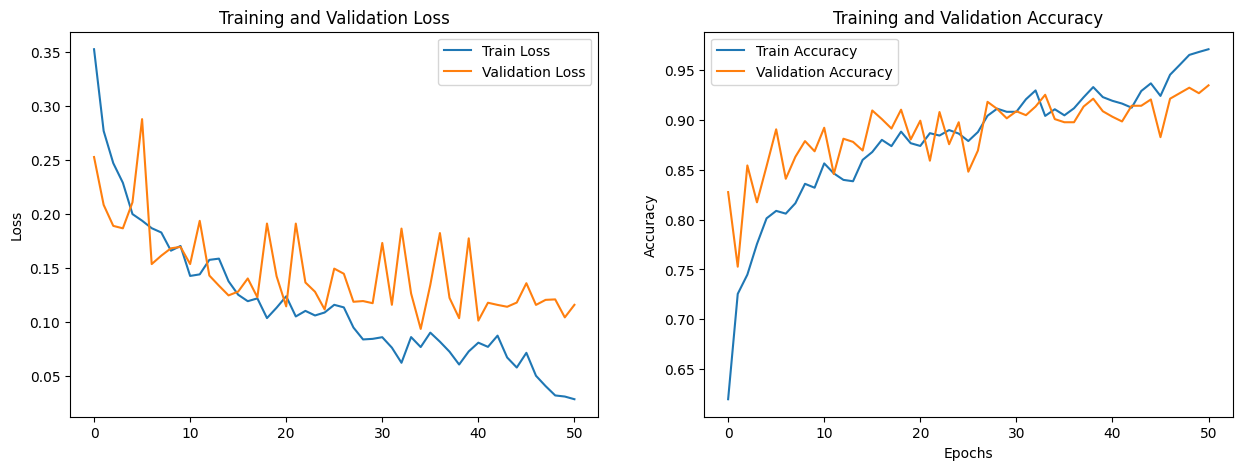

In [ ]:
plot_metrics(swin_transformer_b[1])

100%|██████████| 40/40 [00:39<00:00,  1.01it/s]



Test Loss: 0.2179 Acc: 0.9346, Kappa: 0.8834
Testing complete in 0m 40s




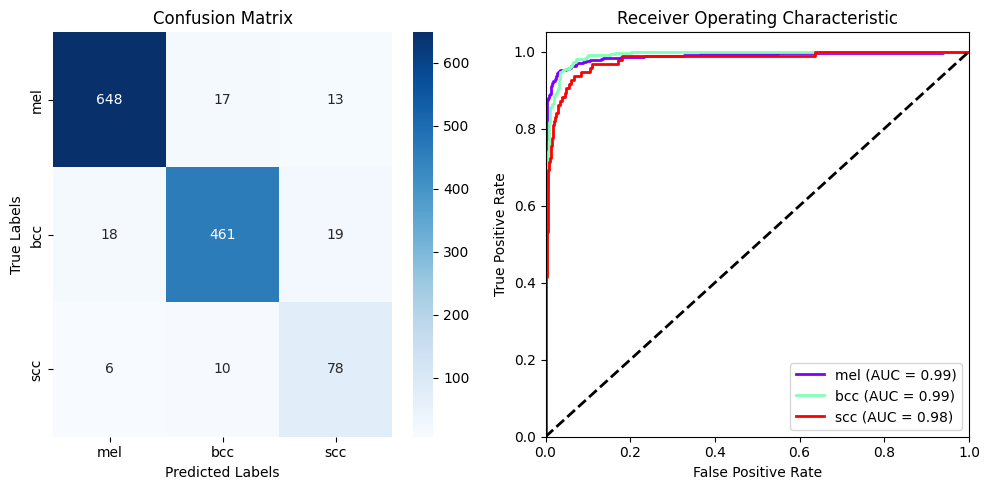

In [ ]:
from torchvision.models import swin_b
from torchvision.models.swin_transformer import Swin_B_Weights

# Define the EfficientNetB4 Model Structure
swin_transformer_b_model_predict = models.swin_b(weights=None)

# Modify the classifier layer
num_ftrs = swin_transformer_b_model_predict.head.in_features
swin_transformer_b_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_b_model_predict = swin_transformer_b_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerB/swin_transformer_b_fl_checkpoint_best.pth'

# Load the best model weights
swin_transformer_b_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_b_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)


# Swin Transformer T [Focal Loss]

In [ ]:

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerT/swin_transformer_t_fl.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Tiny model using torchvision
weights = Swin_T_Weights.DEFAULT
swin_transformer_t_model = models.swin_t(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_t_model.head.in_features
swin_transformer_t_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_t_model = swin_transformer_t_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha=class_weights, gamma=2.0, size_average=True)
optimizer = optim.Adam(swin_transformer_t_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerT/swin_transformer_t_fl_checkpoint.pth'
swin_transformer_t = train_model(swin_transformer_t_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 143MB/s]


Epoch 1/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.3514, acc: 0.6358, kappa: 0.4262



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2589, acc: 0.8307, kappa: 0.6958



Epoch 2/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.2815, acc: 0.7001, kappa: 0.5179



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.3085, acc: 0.7535, kappa: 0.5741



Epoch 3/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.2479, acc: 0.7407, kappa: 0.5741



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2324, acc: 0.7315, kappa: 0.5834



Epoch 4/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.2411, acc: 0.7464, kappa: 0.5870



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2147, acc: 0.8339, kappa: 0.7142



Epoch 5/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.2272, acc: 0.7676, kappa: 0.6158



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2356, acc: 0.8535, kappa: 0.7362



Epoch 6/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.2135, acc: 0.7839, kappa: 0.6412



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1900, acc: 0.8591, kappa: 0.7528



Epoch 7/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1992, acc: 0.7902, kappa: 0.6513



100%|██████████| 40/40 [00:29<00:00,  1.33it/s]

val loss : 0.1726, acc: 0.8717, kappa: 0.7761



Epoch 8/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.1972, acc: 0.7926, kappa: 0.6544



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1654, acc: 0.8811, kappa: 0.7906



Epoch 9/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.1793, acc: 0.8144, kappa: 0.6861



100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.1637, acc: 0.8535, kappa: 0.7489



Epoch 10/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.57it/s]

train loss : 0.1873, acc: 0.8093, kappa: 0.6805



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1670, acc: 0.8661, kappa: 0.7646



Epoch 11/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1838, acc: 0.8144, kappa: 0.6883



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1709, acc: 0.8677, kappa: 0.7663



Epoch 12/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.1653, acc: 0.8274, kappa: 0.7083



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1618, acc: 0.8543, kappa: 0.7514



Epoch 13/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1654, acc: 0.8325, kappa: 0.7152



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1804, acc: 0.8866, kappa: 0.7968



Epoch 14/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.1657, acc: 0.8302, kappa: 0.7123



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.1954, acc: 0.8386, kappa: 0.7236



Epoch 15/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1600, acc: 0.8381, kappa: 0.7246



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1566, acc: 0.8299, kappa: 0.7183



Epoch 16/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1534, acc: 0.8414, kappa: 0.7302



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.1637, acc: 0.8213, kappa: 0.7035



Epoch 17/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1518, acc: 0.8447, kappa: 0.7361



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1476, acc: 0.8913, kappa: 0.8082



Epoch 18/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]


train loss : 0.1316, acc: 0.8674, kappa: 0.7720


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.1203, acc: 0.8843, kappa: 0.8003



Epoch 19/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]


train loss : 0.1281, acc: 0.8571, kappa: 0.7552


100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.1970, acc: 0.8740, kappa: 0.7801



Epoch 20/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.72it/s]


train loss : 0.1367, acc: 0.8579, kappa: 0.7574


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.1555, acc: 0.8827, kappa: 0.7909



Epoch 21/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.75it/s]

train loss : 0.1284, acc: 0.8676, kappa: 0.7724



100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

val loss : 0.1888, acc: 0.8898, kappa: 0.8037



Epoch 22/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.84it/s]


train loss : 0.1221, acc: 0.8709, kappa: 0.7776


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.1774, acc: 0.8961, kappa: 0.8114



Epoch 23/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.1218, acc: 0.8729, kappa: 0.7813



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.1237, acc: 0.8764, kappa: 0.7872



Epoch 24/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.1202, acc: 0.8739, kappa: 0.7826



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1637, acc: 0.8362, kappa: 0.7250



Epoch 25/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.1184, acc: 0.8723, kappa: 0.7804



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1712, acc: 0.8819, kappa: 0.7930



Epoch 26/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.1112, acc: 0.8776, kappa: 0.7889



100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

val loss : 0.1507, acc: 0.8874, kappa: 0.8030



Epoch 27/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.1209, acc: 0.8678, kappa: 0.7737



100%|██████████| 40/40 [00:26<00:00,  1.49it/s]

val loss : 0.1502, acc: 0.9079, kappa: 0.8356



Epoch 28/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.79it/s]


train loss : 0.1078, acc: 0.8878, kappa: 0.8057


100%|██████████| 40/40 [00:26<00:00,  1.49it/s]

val loss : 0.1607, acc: 0.9126, kappa: 0.8437



Epoch 29/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]


train loss : 0.1054, acc: 0.8892, kappa: 0.8082


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


val loss : 0.1662, acc: 0.9071, kappa: 0.8361

Epoch 30/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.0700, acc: 0.9229, kappa: 0.8648



100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

val loss : 0.1340, acc: 0.8969, kappa: 0.8185



Epoch 31/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]


train loss : 0.0645, acc: 0.9286, kappa: 0.8750


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.1233, acc: 0.9205, kappa: 0.8591



Epoch 32/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.0569, acc: 0.9368, kappa: 0.8886



100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

val loss : 0.1279, acc: 0.9197, kappa: 0.8577



Epoch 33/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.82it/s]

train loss : 0.0567, acc: 0.9378, kappa: 0.8907



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1234, acc: 0.9173, kappa: 0.8534



Epoch 34/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]


train loss : 0.0510, acc: 0.9406, kappa: 0.8949


100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.1225, acc: 0.9197, kappa: 0.8583


EARLY STOP AFTER 34 EPOCHS
Training complete in 83m 14s
Best val loss: 0.120343
Best val Kappa: 0.8590761672057377


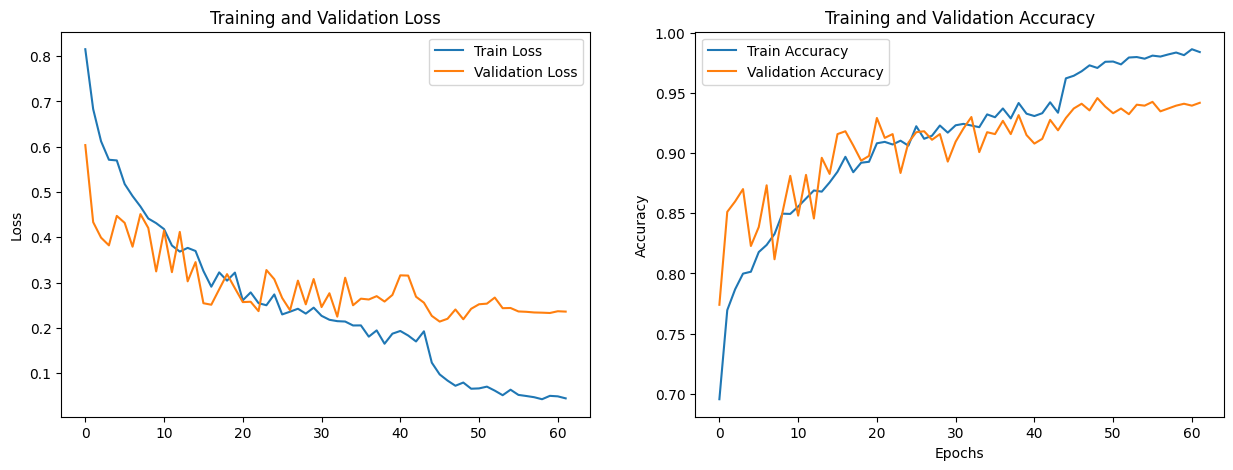

In [ ]:
plot_metrics(swin_transformer_t[1])

100%|██████████| 40/40 [00:46<00:00,  1.15s/it]



Test Loss: 0.2939 Acc: 0.9205, Kappa: 0.8591
Testing complete in 0m 46s




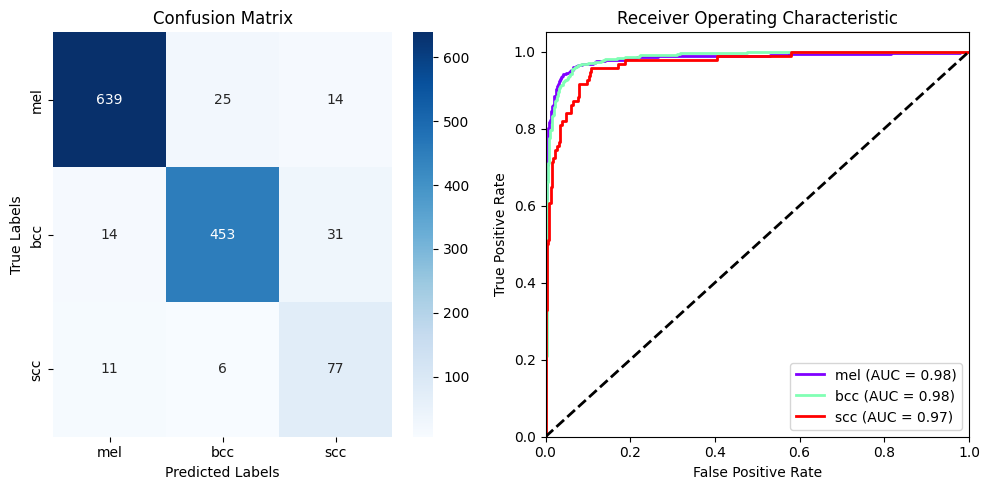

In [ ]:
from torchvision.models import swin_t
from torchvision.models.swin_transformer import Swin_T_Weights

# Define the Swin Transformer Tiny Model Structure
swin_transformer_t_model_predict = models.swin_t(weights=None)

# Modify the classifier layer
num_ftrs = swin_transformer_t_model_predict.head.in_features
swin_transformer_t_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_t_model_predict = swin_transformer_t_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerT/swin_transformer_t_fl_checkpoint_best.pth'

# Load the best model weights
swin_transformer_t_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_t_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)



# Swin Transformer T [Weighted Cross Entropy]

In [ ]:


# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerT/swin_transformer_t_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer Tiny model using torchvision
weights = Swin_T_Weights.DEFAULT
swin_transformer_t_model = models.swin_t(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_t_model.head.in_features
swin_transformer_t_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_t_model = swin_transformer_t_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(swin_transformer_t_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerT/swin_transformer_t_wce_checkpoint.pth'
swin_transformer_t = train_model(swin_transformer_t_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.83it/s]

train loss : 0.8152, acc: 0.6956, kappa: 0.4882



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.6035, acc: 0.7740, kappa: 0.6271



Epoch 2/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.6830, acc: 0.7696, kappa: 0.6083



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.4334, acc: 0.8512, kappa: 0.7283



Epoch 3/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.6120, acc: 0.7869, kappa: 0.6390



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.3991, acc: 0.8598, kappa: 0.7509



Epoch 4/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.5711, acc: 0.7999, kappa: 0.6604



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.3821, acc: 0.8701, kappa: 0.7634



Epoch 5/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.5697, acc: 0.8015, kappa: 0.6633



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.4472, acc: 0.8228, kappa: 0.7036



Epoch 6/100
---------------


100%|██████████| 318/318 [02:03<00:00,  2.58it/s]

train loss : 0.5176, acc: 0.8178, kappa: 0.6885



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.4318, acc: 0.8386, kappa: 0.7295



Epoch 7/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.4910, acc: 0.8237, kappa: 0.6992



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.3792, acc: 0.8732, kappa: 0.7767



Epoch 8/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.4680, acc: 0.8327, kappa: 0.7143



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.4511, acc: 0.8118, kappa: 0.6872



Epoch 9/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.4414, acc: 0.8497, kappa: 0.7415



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.4205, acc: 0.8504, kappa: 0.7410



Epoch 10/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.79it/s]

train loss : 0.4311, acc: 0.8495, kappa: 0.7407



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.3246, acc: 0.8811, kappa: 0.7874



Epoch 11/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.4180, acc: 0.8556, kappa: 0.7506



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.4147, acc: 0.8480, kappa: 0.7406



Epoch 12/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.3817, acc: 0.8623, kappa: 0.7615



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.3229, acc: 0.8819, kappa: 0.7923



Epoch 13/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]


train loss : 0.3683, acc: 0.8689, kappa: 0.7739


100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.4119, acc: 0.8457, kappa: 0.7402



Epoch 14/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.3765, acc: 0.8680, kappa: 0.7717



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.3027, acc: 0.8961, kappa: 0.8154



Epoch 15/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.62it/s]

train loss : 0.3697, acc: 0.8756, kappa: 0.7851



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3451, acc: 0.8827, kappa: 0.7971



Epoch 16/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.3256, acc: 0.8845, kappa: 0.7999



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2543, acc: 0.9157, kappa: 0.8497



Epoch 17/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.2908, acc: 0.8969, kappa: 0.8199



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2510, acc: 0.9181, kappa: 0.8533



Epoch 18/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.3224, acc: 0.8841, kappa: 0.7985



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2849, acc: 0.9063, kappa: 0.8318



Epoch 19/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.3042, acc: 0.8920, kappa: 0.8115



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3186, acc: 0.8937, kappa: 0.8155



Epoch 20/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.3220, acc: 0.8928, kappa: 0.8133



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2874, acc: 0.8976, kappa: 0.8205



Epoch 21/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.2608, acc: 0.9081, kappa: 0.8390



100%|██████████| 40/40 [00:32<00:00,  1.25it/s]

val loss : 0.2568, acc: 0.9291, kappa: 0.8748



Epoch 22/100
---------------


100%|██████████| 318/318 [02:29<00:00,  2.13it/s]

train loss : 0.2783, acc: 0.9093, kappa: 0.8411



100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

val loss : 0.2576, acc: 0.9126, kappa: 0.8461



Epoch 23/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]


train loss : 0.2545, acc: 0.9071, kappa: 0.8376


100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2368, acc: 0.9157, kappa: 0.8512



Epoch 24/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2498, acc: 0.9103, kappa: 0.8424



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3276, acc: 0.8835, kappa: 0.7998



Epoch 25/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.2738, acc: 0.9061, kappa: 0.8360



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.3074, acc: 0.9087, kappa: 0.8370



Epoch 26/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]

train loss : 0.2296, acc: 0.9223, kappa: 0.8633



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2659, acc: 0.9173, kappa: 0.8506



Epoch 27/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.2356, acc: 0.9118, kappa: 0.8455



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2388, acc: 0.9181, kappa: 0.8537



Epoch 28/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.2421, acc: 0.9144, kappa: 0.8499



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.3042, acc: 0.9110, kappa: 0.8403



Epoch 29/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.2314, acc: 0.9229, kappa: 0.8643



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2519, acc: 0.9157, kappa: 0.8518



Epoch 30/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2445, acc: 0.9170, kappa: 0.8542



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.3078, acc: 0.8929, kappa: 0.8146



Epoch 31/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2265, acc: 0.9231, kappa: 0.8647



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2458, acc: 0.9094, kappa: 0.8385



Epoch 32/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.2178, acc: 0.9242, kappa: 0.8666



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2764, acc: 0.9205, kappa: 0.8599



Epoch 33/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.2147, acc: 0.9229, kappa: 0.8646



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2247, acc: 0.9299, kappa: 0.8756



Epoch 34/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.2139, acc: 0.9215, kappa: 0.8617



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.3106, acc: 0.9008, kappa: 0.8244



Epoch 35/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.2052, acc: 0.9321, kappa: 0.8803



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


val loss : 0.2498, acc: 0.9173, kappa: 0.8530

Epoch 36/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.2054, acc: 0.9298, kappa: 0.8761



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2644, acc: 0.9157, kappa: 0.8484



Epoch 37/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.72it/s]

train loss : 0.1805, acc: 0.9370, kappa: 0.8887



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2625, acc: 0.9268, kappa: 0.8700



Epoch 38/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.1943, acc: 0.9288, kappa: 0.8742



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2699, acc: 0.9157, kappa: 0.8481



Epoch 39/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1649, acc: 0.9416, kappa: 0.8966



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2580, acc: 0.9315, kappa: 0.8768



Epoch 40/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.1871, acc: 0.9327, kappa: 0.8812



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2726, acc: 0.9150, kappa: 0.8492



Epoch 41/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1931, acc: 0.9307, kappa: 0.8780



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.3159, acc: 0.9079, kappa: 0.8389



Epoch 42/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.1830, acc: 0.9331, kappa: 0.8820



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.3154, acc: 0.9118, kappa: 0.8413



Epoch 43/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1699, acc: 0.9421, kappa: 0.8977



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2687, acc: 0.9276, kappa: 0.8716



Epoch 44/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.72it/s]

train loss : 0.1923, acc: 0.9335, kappa: 0.8827



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2555, acc: 0.9189, kappa: 0.8554



Epoch 45/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.1231, acc: 0.9620, kappa: 0.9323



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2264, acc: 0.9291, kappa: 0.8746



Epoch 46/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.0971, acc: 0.9642, kappa: 0.9363



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2138, acc: 0.9370, kappa: 0.8873



Epoch 47/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.0835, acc: 0.9679, kappa: 0.9428



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2200, acc: 0.9409, kappa: 0.8942



Epoch 48/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.72it/s]

train loss : 0.0721, acc: 0.9728, kappa: 0.9516



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2405, acc: 0.9354, kappa: 0.8844



Epoch 49/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0792, acc: 0.9707, kappa: 0.9476



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2189, acc: 0.9457, kappa: 0.9026



Epoch 50/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.0655, acc: 0.9758, kappa: 0.9567



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2421, acc: 0.9386, kappa: 0.8907



Epoch 51/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0662, acc: 0.9760, kappa: 0.9571



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2520, acc: 0.9331, kappa: 0.8803



Epoch 52/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0701, acc: 0.9736, kappa: 0.9529



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2534, acc: 0.9370, kappa: 0.8877



Epoch 53/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.76it/s]

train loss : 0.0613, acc: 0.9793, kappa: 0.9631



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2668, acc: 0.9323, kappa: 0.8789



Epoch 54/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.0512, acc: 0.9797, kappa: 0.9637



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2434, acc: 0.9402, kappa: 0.8927



Epoch 55/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.0634, acc: 0.9784, kappa: 0.9612



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.2438, acc: 0.9394, kappa: 0.8917



Epoch 56/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.0519, acc: 0.9809, kappa: 0.9658



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2362, acc: 0.9425, kappa: 0.8971



Epoch 57/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.73it/s]

train loss : 0.0495, acc: 0.9801, kappa: 0.9644



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2354, acc: 0.9346, kappa: 0.8829



Epoch 58/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.0468, acc: 0.9819, kappa: 0.9676



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2339, acc: 0.9370, kappa: 0.8872



Epoch 59/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.0423, acc: 0.9835, kappa: 0.9704



100%|██████████| 40/40 [00:29<00:00,  1.33it/s]

val loss : 0.2335, acc: 0.9394, kappa: 0.8913



Epoch 60/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.67it/s]

train loss : 0.0498, acc: 0.9813, kappa: 0.9665



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2328, acc: 0.9409, kappa: 0.8939



Epoch 61/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.0487, acc: 0.9862, kappa: 0.9753



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2366, acc: 0.9394, kappa: 0.8912



Epoch 62/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.0443, acc: 0.9839, kappa: 0.9711



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2358, acc: 0.9417, kappa: 0.8956


EARLY STOP AFTER 62 EPOCHS
Training complete in 154m 18s
Best val loss: 0.213785
Best val Kappa: 0.9025813767342583


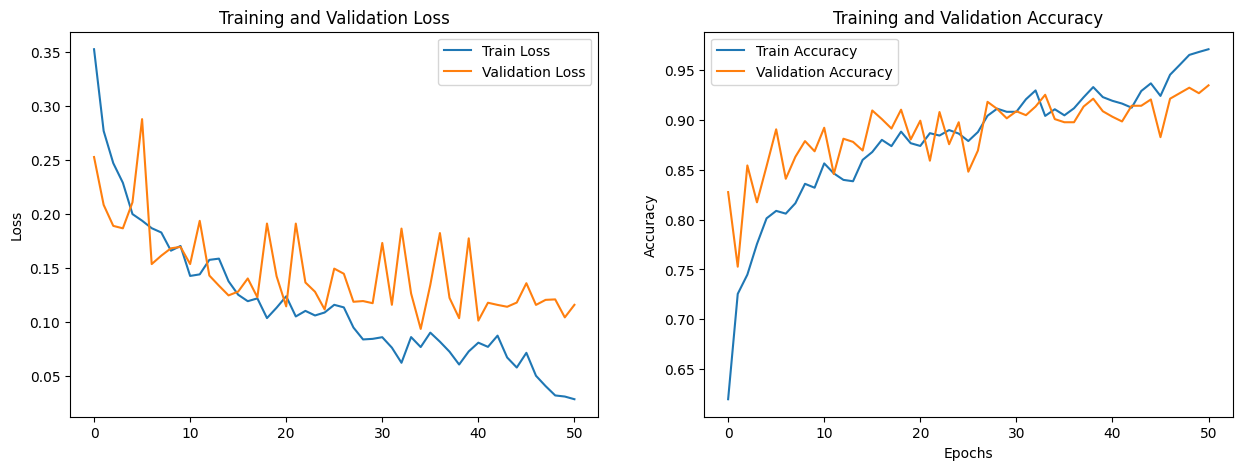

In [ ]:
plot_metrics(swin_transformer_t[1])

100%|██████████| 40/40 [00:40<00:00,  1.00s/it]



Test Loss: 0.2189 Acc: 0.9457, Kappa: 0.9026
Testing complete in 0m 40s




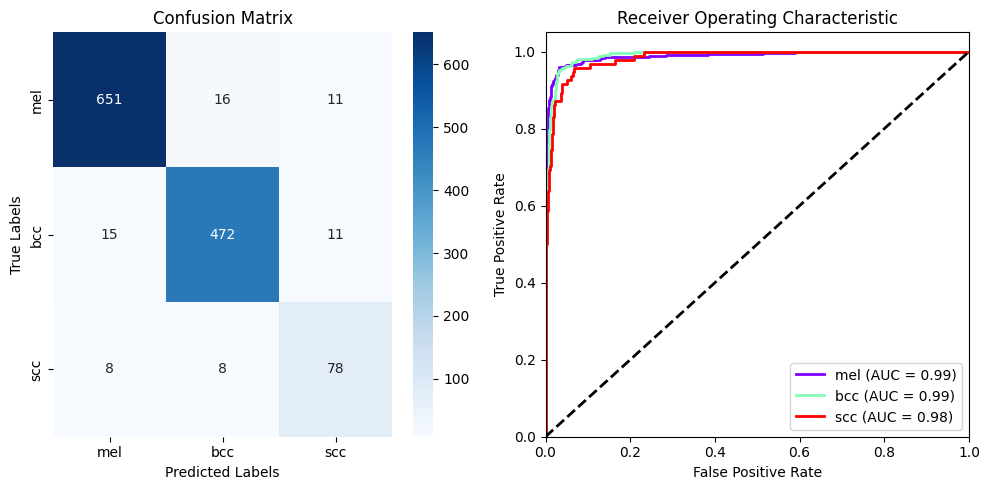

In [ ]:
from torchvision.models import swin_t
from torchvision.models.swin_transformer import Swin_T_Weights

# Define the Swin Transformer Tiny Model Structure
swin_transformer_t_model_predict = models.swin_t(weights=None)

# Modify the classifier layer
num_ftrs = swin_transformer_t_model_predict.head.in_features
swin_transformer_t_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_t_model_predict = swin_transformer_t_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerT/swin_transformer_t_wce_checkpoint_best.pth'

# Load the best model weights
swin_transformer_t_model_predict.load_state_dict(torch.load(best_model_path))


# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_t_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)




# Swin Transformer V2 S [Focal Loss]

In [ ]:

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerV2S/swin_transformer_v2_s_fl.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer V2 Small model using torchvision
weights = Swin_V2_S_Weights.DEFAULT
swin_transformer_v2_s_model = swin_v2_s(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_v2_s_model.head.in_features
swin_transformer_v2_s_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_s_model = swin_transformer_v2_s_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined
criterion = FocalLoss(alpha=class_weights, gamma=2.0, size_average=True)
optimizer = optim.Adam(swin_transformer_v2_s_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerV2S/swin_transformer_v2_s_fl_checkpoint.pth'
swin_transformer_v2_s = train_model(swin_transformer_v2_s_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:39<00:00,  1.99it/s]

train loss : 0.3791, acc: 0.5968, kappa: 0.3690



100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

val loss : 0.2619, acc: 0.7394, kappa: 0.5864



Epoch 2/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.2882, acc: 0.7084, kappa: 0.5275



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2572, acc: 0.7677, kappa: 0.6180



Epoch 3/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.2530, acc: 0.7497, kappa: 0.5883



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2185, acc: 0.8449, kappa: 0.7258



Epoch 4/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.20it/s]

train loss : 0.2255, acc: 0.7688, kappa: 0.6193



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2098, acc: 0.8378, kappa: 0.7166



Epoch 5/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.2232, acc: 0.7753, kappa: 0.6261



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2382, acc: 0.8220, kappa: 0.6953



Epoch 6/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.2061, acc: 0.7981, kappa: 0.6620



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1992, acc: 0.8724, kappa: 0.7760



Epoch 7/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.2006, acc: 0.7995, kappa: 0.6649



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1714, acc: 0.8614, kappa: 0.7575



Epoch 8/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.1768, acc: 0.8292, kappa: 0.7106



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1633, acc: 0.8874, kappa: 0.8014



Epoch 9/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.1549, acc: 0.8410, kappa: 0.7298



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.1436, acc: 0.8701, kappa: 0.7754



Epoch 10/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.29it/s]

train loss : 0.1554, acc: 0.8398, kappa: 0.7272



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1657, acc: 0.8331, kappa: 0.7187



Epoch 11/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.1454, acc: 0.8479, kappa: 0.7414



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1865, acc: 0.8638, kappa: 0.7646



Epoch 12/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.1431, acc: 0.8505, kappa: 0.7447



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1421, acc: 0.8866, kappa: 0.8040



Epoch 13/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.1638, acc: 0.8361, kappa: 0.7223



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1526, acc: 0.8228, kappa: 0.7067



Epoch 14/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train loss : 0.1269, acc: 0.8634, kappa: 0.7663



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1982, acc: 0.7575, kappa: 0.6064



Epoch 15/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.1239, acc: 0.8642, kappa: 0.7673



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.1932, acc: 0.8646, kappa: 0.7610



Epoch 16/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.1464, acc: 0.8593, kappa: 0.7596



100%|██████████| 40/40 [00:29<00:00,  1.33it/s]

val loss : 0.1694, acc: 0.8465, kappa: 0.7362



Epoch 17/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.1212, acc: 0.8821, kappa: 0.7962



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1896, acc: 0.8646, kappa: 0.7633



Epoch 18/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.1059, acc: 0.8882, kappa: 0.8062



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2374, acc: 0.9047, kappa: 0.8284



Epoch 19/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.1136, acc: 0.8754, kappa: 0.7852



100%|██████████| 40/40 [00:31<00:00,  1.29it/s]

val loss : 0.1421, acc: 0.8693, kappa: 0.7781



Epoch 20/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.1006, acc: 0.8947, kappa: 0.8173



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1609, acc: 0.8976, kappa: 0.8189



Epoch 21/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.29it/s]

train loss : 0.1109, acc: 0.8867, kappa: 0.8038



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1298, acc: 0.8898, kappa: 0.8086



Epoch 22/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0948, acc: 0.9014, kappa: 0.8285



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1378, acc: 0.8669, kappa: 0.7721



Epoch 23/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0981, acc: 0.8939, kappa: 0.8158



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2205, acc: 0.8528, kappa: 0.7333



Epoch 24/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.1008, acc: 0.8939, kappa: 0.8168



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1293, acc: 0.9142, kappa: 0.8469



Epoch 25/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.1006, acc: 0.8916, kappa: 0.8121



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.1554, acc: 0.8858, kappa: 0.8012



Epoch 26/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.1086, acc: 0.8811, kappa: 0.7957



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.1344, acc: 0.8976, kappa: 0.8214



Epoch 27/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0790, acc: 0.9134, kappa: 0.8486



100%|██████████| 40/40 [00:29<00:00,  1.38it/s]

val loss : 0.2285, acc: 0.9150, kappa: 0.8466



Epoch 28/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0888, acc: 0.9040, kappa: 0.8328



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1259, acc: 0.8953, kappa: 0.8166



Epoch 29/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.0878, acc: 0.9046, kappa: 0.8335



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1206, acc: 0.9236, kappa: 0.8635



Epoch 30/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.21it/s]

train loss : 0.0768, acc: 0.9187, kappa: 0.8579



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1307, acc: 0.9197, kappa: 0.8569



Epoch 31/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.0738, acc: 0.9201, kappa: 0.8602



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.1381, acc: 0.8386, kappa: 0.7341



Epoch 32/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.1011, acc: 0.8937, kappa: 0.8167



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1851, acc: 0.8937, kappa: 0.8093



Epoch 33/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0757, acc: 0.9233, kappa: 0.8650



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1403, acc: 0.9236, kappa: 0.8633



Epoch 34/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.24it/s]


train loss : 0.0695, acc: 0.9229, kappa: 0.8645


100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


val loss : 0.1822, acc: 0.9173, kappa: 0.8501

Epoch 35/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.0710, acc: 0.9215, kappa: 0.8624



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1479, acc: 0.9205, kappa: 0.8583



Epoch 36/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.0804, acc: 0.9091, kappa: 0.8415



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2452, acc: 0.8457, kappa: 0.7253



Epoch 37/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.24it/s]

train loss : 0.0747, acc: 0.9238, kappa: 0.8665



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2175, acc: 0.9087, kappa: 0.8326



Epoch 38/100
---------------


100%|██████████| 318/318 [03:09<00:00,  1.68it/s]

train loss : 0.0982, acc: 0.9034, kappa: 0.8320



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1291, acc: 0.8843, kappa: 0.8001



Epoch 39/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.19it/s]

train loss : 0.0711, acc: 0.9280, kappa: 0.8736



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.1220, acc: 0.8969, kappa: 0.8203



Epoch 40/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0601, acc: 0.9309, kappa: 0.8785



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1553, acc: 0.8898, kappa: 0.8060



Epoch 41/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.0590, acc: 0.9364, kappa: 0.8882



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.1344, acc: 0.9173, kappa: 0.8526



Epoch 42/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0394, acc: 0.9569, kappa: 0.9235



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.1465, acc: 0.9252, kappa: 0.8657



Epoch 43/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0320, acc: 0.9608, kappa: 0.9304



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1433, acc: 0.9299, kappa: 0.8745



Epoch 44/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0336, acc: 0.9644, kappa: 0.9366



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.1370, acc: 0.9354, kappa: 0.8844



Epoch 45/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.20it/s]

train loss : 0.0239, acc: 0.9725, kappa: 0.9509



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.1593, acc: 0.9354, kappa: 0.8837


EARLY STOP AFTER 45 EPOCHS
Training complete in 134m 9s
Best val loss: 0.120621
Best val Kappa: 0.8844111561992204


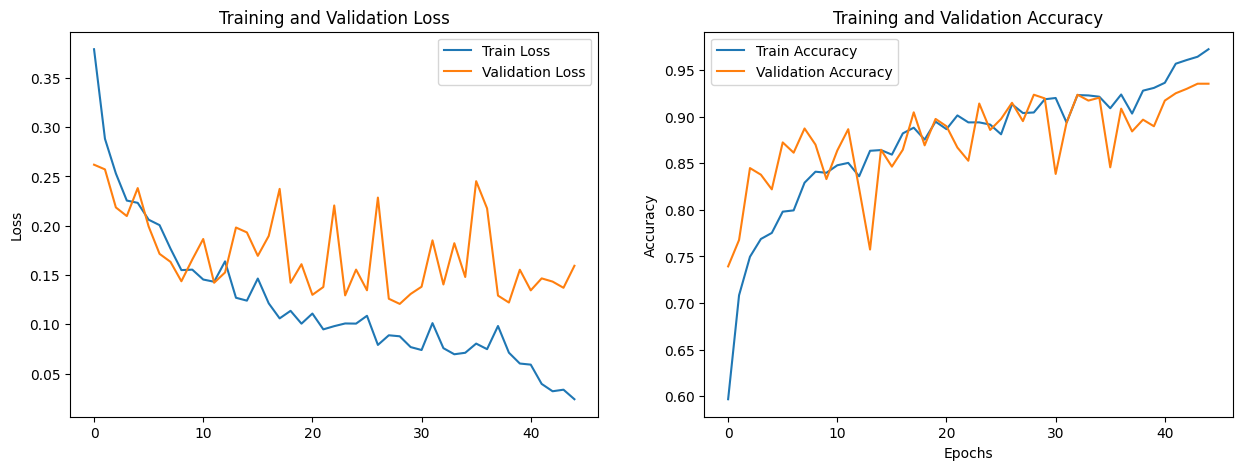

In [ ]:
plot_metrics(swin_transformer_v2_s[1])

100%|██████████| 40/40 [00:50<00:00,  1.27s/it]



Test Loss: 0.2287 Acc: 0.9354, Kappa: 0.8844
Testing complete in 0m 51s




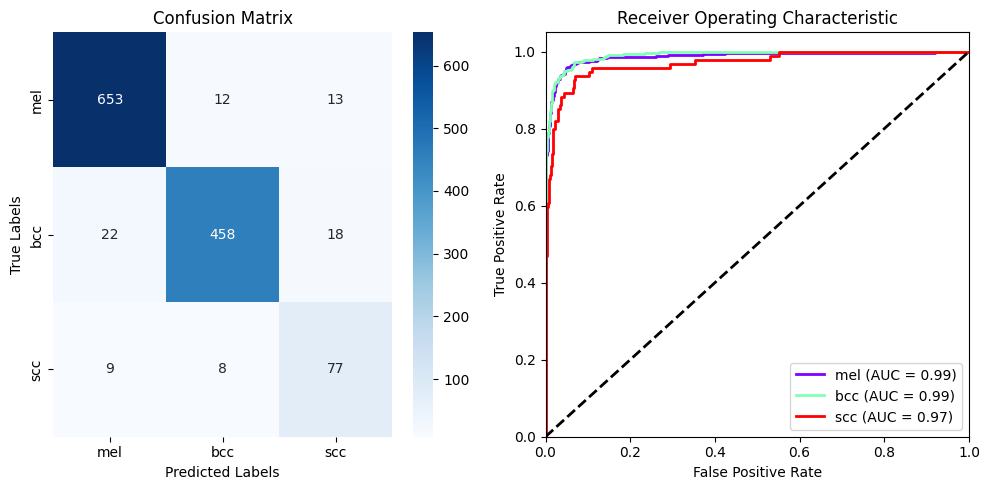

In [ ]:
from torchvision.models import swin_v2_s


# Define the Swin Transformer V2 Small Model Structure
swin_transformer_v2_s_model_predict = models.swin_v2_s(weights=None)

# Modify the classifier layer
num_ftrs = swin_transformer_v2_s_model_predict.head.in_features
swin_transformer_v2_s_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_s_model_predict = swin_transformer_v2_s_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerV2S/swin_transformer_v2_s_fl_checkpoint_best.pth'

# Load the best model weights
swin_transformer_v2_s_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_v2_s_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)




# Swin Transformer V2 S [Weighted Corss Entropy]

In [ ]:


# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerV2S/swin_transformer_v2_s_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer V2 Small model using torchvision
weights = Swin_V2_S_Weights.DEFAULT
swin_transformer_v2_s_model = swin_v2_s(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_v2_s_model.head.in_features
swin_transformer_v2_s_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_s_model = swin_transformer_v2_s_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(swin_transformer_v2_s_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerV2S/swin_transformer_v2_s_wce_checkpoint.pth'
swin_transformer_v2_s = train_model(swin_transformer_v2_s_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:39<00:00,  1.99it/s]

train loss : 0.8017, acc: 0.6836, kappa: 0.4767



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.4917, acc: 0.8315, kappa: 0.7038



Epoch 2/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.6591, acc: 0.7605, kappa: 0.5994



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5257, acc: 0.8063, kappa: 0.6801



Epoch 3/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.5940, acc: 0.7743, kappa: 0.6218



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.4987, acc: 0.7921, kappa: 0.6628



Epoch 4/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train loss : 0.5268, acc: 0.8101, kappa: 0.6786



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.4332, acc: 0.8598, kappa: 0.7499



Epoch 5/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train loss : 0.5004, acc: 0.8284, kappa: 0.7064



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.3846, acc: 0.8598, kappa: 0.7581



Epoch 6/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.19it/s]

train loss : 0.4563, acc: 0.8406, kappa: 0.7266



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.3908, acc: 0.8732, kappa: 0.7785



Epoch 7/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.4401, acc: 0.8534, kappa: 0.7479



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2895, acc: 0.8874, kappa: 0.8013



Epoch 8/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.3901, acc: 0.8664, kappa: 0.7693



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.4809, acc: 0.8402, kappa: 0.7237



Epoch 9/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.4039, acc: 0.8630, kappa: 0.7629



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.4620, acc: 0.8283, kappa: 0.7134



Epoch 10/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.3411, acc: 0.8784, kappa: 0.7886



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


val loss : 0.3742, acc: 0.8496, kappa: 0.7468

Epoch 11/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.3543, acc: 0.8772, kappa: 0.7873



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.3257, acc: 0.8835, kappa: 0.7963



Epoch 12/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train loss : 0.3063, acc: 0.8882, kappa: 0.8063



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.3512, acc: 0.8969, kappa: 0.8175



Epoch 13/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.19it/s]

train loss : 0.2860, acc: 0.8996, kappa: 0.8252



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.3190, acc: 0.8913, kappa: 0.8118



Epoch 14/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.2656, acc: 0.9022, kappa: 0.8296



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.3907, acc: 0.8709, kappa: 0.7756



Epoch 15/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train loss : 0.3101, acc: 0.8908, kappa: 0.8106



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.3432, acc: 0.8732, kappa: 0.7804



Epoch 16/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.2785, acc: 0.9054, kappa: 0.8353



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2903, acc: 0.8961, kappa: 0.8171



Epoch 17/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]


train loss : 0.2396, acc: 0.9185, kappa: 0.8571


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2421, acc: 0.9197, kappa: 0.8581



Epoch 18/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]


train loss : 0.2473, acc: 0.9109, kappa: 0.8441


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.3717, acc: 0.8551, kappa: 0.7564



Epoch 19/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.2407, acc: 0.9140, kappa: 0.8496



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.2864, acc: 0.9063, kappa: 0.8329



Epoch 20/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train loss : 0.2138, acc: 0.9290, kappa: 0.8748



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2737, acc: 0.9055, kappa: 0.8337



Epoch 21/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.1892, acc: 0.9404, kappa: 0.8947



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2429, acc: 0.9236, kappa: 0.8648



Epoch 22/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.1993, acc: 0.9323, kappa: 0.8809



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2566, acc: 0.9197, kappa: 0.8570



Epoch 23/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.1954, acc: 0.9325, kappa: 0.8811



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2428, acc: 0.9205, kappa: 0.8558



Epoch 24/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.1957, acc: 0.9343, kappa: 0.8842



100%|██████████| 40/40 [00:29<00:00,  1.35it/s]

val loss : 0.4069, acc: 0.8756, kappa: 0.7839



Epoch 25/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.1671, acc: 0.9449, kappa: 0.9022



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2443, acc: 0.9299, kappa: 0.8748



Epoch 26/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.1768, acc: 0.9433, kappa: 0.8998



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.2558, acc: 0.9220, kappa: 0.8611



Epoch 27/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.1651, acc: 0.9425, kappa: 0.8985



100%|██████████| 40/40 [00:29<00:00,  1.33it/s]

val loss : 0.2822, acc: 0.9118, kappa: 0.8428



Epoch 28/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.20it/s]

train loss : 0.1635, acc: 0.9435, kappa: 0.9003



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.2612, acc: 0.9197, kappa: 0.8570



Epoch 29/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.0859, acc: 0.9725, kappa: 0.9507



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2216, acc: 0.9354, kappa: 0.8841



Epoch 30/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train loss : 0.0653, acc: 0.9791, kappa: 0.9627



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2271, acc: 0.9386, kappa: 0.8899



Epoch 31/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0521, acc: 0.9827, kappa: 0.9690



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2291, acc: 0.9378, kappa: 0.8883



Epoch 32/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]


train loss : 0.0486, acc: 0.9843, kappa: 0.9718


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2233, acc: 0.9433, kappa: 0.8978



Epoch 33/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.0504, acc: 0.9819, kappa: 0.9676



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.2164, acc: 0.9425, kappa: 0.8969



Epoch 34/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0510, acc: 0.9821, kappa: 0.9679



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2195, acc: 0.9402, kappa: 0.8929



Epoch 35/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.0494, acc: 0.9829, kappa: 0.9694



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


val loss : 0.2221, acc: 0.9449, kappa: 0.9004

Epoch 36/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0405, acc: 0.9839, kappa: 0.9711



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2110, acc: 0.9496, kappa: 0.9096



Epoch 37/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]


train loss : 0.0542, acc: 0.9856, kappa: 0.9743


100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2108, acc: 0.9528, kappa: 0.9152



Epoch 38/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0463, acc: 0.9845, kappa: 0.9722



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2100, acc: 0.9496, kappa: 0.9091



Epoch 39/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train loss : 0.0347, acc: 0.9902, kappa: 0.9823



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2107, acc: 0.9472, kappa: 0.9055



Epoch 40/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train loss : 0.0345, acc: 0.9896, kappa: 0.9813



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.2176, acc: 0.9512, kappa: 0.9125



Epoch 41/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train loss : 0.0423, acc: 0.9852, kappa: 0.9735



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2133, acc: 0.9488, kappa: 0.9080



Epoch 42/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.0388, acc: 0.9870, kappa: 0.9767



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2243, acc: 0.9472, kappa: 0.9053



Epoch 43/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train loss : 0.0390, acc: 0.9868, kappa: 0.9764



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.2071, acc: 0.9528, kappa: 0.9153



Epoch 44/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]


train loss : 0.0308, acc: 0.9904, kappa: 0.9827


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.2140, acc: 0.9528, kappa: 0.9149



Epoch 45/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.0322, acc: 0.9896, kappa: 0.9813



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2396, acc: 0.9480, kappa: 0.9065



Epoch 46/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train loss : 0.0252, acc: 0.9904, kappa: 0.9827



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.2451, acc: 0.9480, kappa: 0.9064



Epoch 47/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train loss : 0.0429, acc: 0.9864, kappa: 0.9756



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2306, acc: 0.9488, kappa: 0.9078



Epoch 48/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train loss : 0.0304, acc: 0.9888, kappa: 0.9799



100%|██████████| 40/40 [00:29<00:00,  1.34it/s]

val loss : 0.2322, acc: 0.9496, kappa: 0.9093



Epoch 49/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train loss : 0.0284, acc: 0.9898, kappa: 0.9816



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2168, acc: 0.9488, kappa: 0.9079



Epoch 50/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.0266, acc: 0.9909, kappa: 0.9837



100%|██████████| 40/40 [00:30<00:00,  1.32it/s]

val loss : 0.2315, acc: 0.9496, kappa: 0.9100



Epoch 51/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0280, acc: 0.9913, kappa: 0.9845



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2120, acc: 0.9551, kappa: 0.9195



Epoch 52/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.0200, acc: 0.9931, kappa: 0.9876



100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

val loss : 0.2239, acc: 0.9551, kappa: 0.9196



Epoch 53/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.18it/s]

train loss : 0.0331, acc: 0.9896, kappa: 0.9813



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2266, acc: 0.9551, kappa: 0.9192



Epoch 54/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.21it/s]

train loss : 0.0213, acc: 0.9935, kappa: 0.9883



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.2279, acc: 0.9567, kappa: 0.9221



Epoch 55/100
---------------


100%|██████████| 318/318 [02:25<00:00,  2.19it/s]

train loss : 0.0241, acc: 0.9915, kappa: 0.9848



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.2248, acc: 0.9591, kappa: 0.9263



Epoch 56/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.0217, acc: 0.9927, kappa: 0.9869



100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

val loss : 0.2223, acc: 0.9606, kappa: 0.9292



Epoch 57/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train loss : 0.0187, acc: 0.9927, kappa: 0.9869



100%|██████████| 40/40 [00:30<00:00,  1.31it/s]

val loss : 0.2258, acc: 0.9598, kappa: 0.9278



Epoch 58/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.21it/s]

train loss : 0.0201, acc: 0.9931, kappa: 0.9876



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.2280, acc: 0.9591, kappa: 0.9263



Epoch 59/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.19it/s]

train loss : 0.0252, acc: 0.9929, kappa: 0.9873



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.2276, acc: 0.9575, kappa: 0.9235


EARLY STOP AFTER 59 EPOCHS
Training complete in 172m 40s
Best val loss: 0.207149
Best val Kappa: 0.9292299325065309


100%|██████████| 40/40 [00:38<00:00,  1.04it/s]



Test Loss: 0.2223 Acc: 0.9606, Kappa: 0.9292
Testing complete in 0m 38s




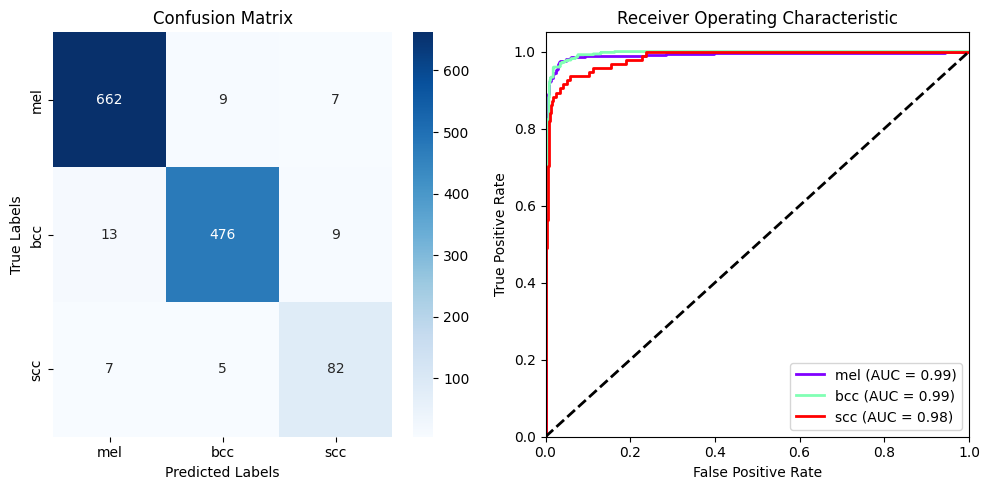

In [ ]:
from torchvision.models import swin_v2_s
from torchvision.models.swin_transformer import Swin_V2_S_Weights

# Define the Swin Transformer V2 Small Model Structure
swin_transformer_v2_s_model_predict = models.swin_v2_s(weights=None)

# Number of classes
num_classes = 3
# Modify the classifier layer
num_ftrs = swin_transformer_v2_s_model_predict.head.in_features
swin_transformer_v2_s_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_s_model_predict = swin_transformer_v2_s_model_predict.to(DEVICE)

# Number of classes
num_classes = 3
best_model_path = TENSORBOARD_PATH + '/SwinTransformerV2S/swin_transformer_v2_s_wce_checkpoint_best.pth'
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Load the best model weights
swin_transformer_v2_s_model_predict.load_state_dict(torch.load(best_model_path))
# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
# Evaluate the model on validation data


# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_v2_s_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)



# Swin Trasnsformer V2 B [Weighted Cross Entropy]

In [ ]:
from torchvision.models import swin_v2_b
from torchvision.models.swin_transformer import Swin_V2_B_Weights

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/SwinTransformerV2B/swin_transformer_v2_b_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Swin Transformer V2 Base model using torchvision
weights = Swin_V2_B_Weights.DEFAULT
swin_transformer_v2_b_model = swin_v2_b(weights=weights)

# Modify the classifier layer
num_ftrs = swin_transformer_v2_b_model.head.in_features
swin_transformer_v2_b_model.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_b_model = swin_transformer_v2_b_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(swin_transformer_v2_b_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/SwinTransformerV2B/swin_transformer_v2_b_wce_checkpoint.pth'
swin_transformer_v2_b = train_model(swin_transformer_v2_b_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [12:43<00:00,  2.40s/it]

train loss : 0.8318, acc: 0.6789, kappa: 0.4644



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.5463, acc: 0.8157, kappa: 0.6756



Epoch 2/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.6709, acc: 0.7654, kappa: 0.6045



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.5082, acc: 0.8142, kappa: 0.6736



Epoch 3/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.6045, acc: 0.7908, kappa: 0.6448



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.4589, acc: 0.8362, kappa: 0.7213



Epoch 4/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.5744, acc: 0.8117, kappa: 0.6783



100%|██████████| 40/40 [00:42<00:00,  1.05s/it]

val loss : 0.3813, acc: 0.8559, kappa: 0.7385



Epoch 5/100
---------------


100%|██████████| 318/318 [04:25<00:00,  1.20it/s]

train loss : 0.5173, acc: 0.8142, kappa: 0.6841



100%|██████████| 40/40 [00:53<00:00,  1.33s/it]

val loss : 0.3389, acc: 0.8913, kappa: 0.8038



Epoch 6/100
---------------


100%|██████████| 318/318 [04:22<00:00,  1.21it/s]

train loss : 0.4875, acc: 0.8312, kappa: 0.7114



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.3267, acc: 0.8819, kappa: 0.7954



Epoch 7/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.4377, acc: 0.8518, kappa: 0.7454



100%|██████████| 40/40 [00:33<00:00,  1.19it/s]

val loss : 0.2955, acc: 0.8921, kappa: 0.8080



Epoch 8/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.4306, acc: 0.8514, kappa: 0.7442



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.3199, acc: 0.8874, kappa: 0.8040



Epoch 9/100
---------------


100%|██████████| 318/318 [04:17<00:00,  1.24it/s]

train loss : 0.4019, acc: 0.8623, kappa: 0.7615



100%|██████████| 40/40 [00:33<00:00,  1.18it/s]

val loss : 0.3020, acc: 0.9016, kappa: 0.8262



Epoch 10/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]


train loss : 0.3677, acc: 0.8723, kappa: 0.7794


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.3196, acc: 0.8984, kappa: 0.8216



Epoch 11/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.3402, acc: 0.8857, kappa: 0.8006



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.4985, acc: 0.8039, kappa: 0.6803



Epoch 12/100
---------------


100%|██████████| 318/318 [04:17<00:00,  1.23it/s]

train loss : 0.3424, acc: 0.8802, kappa: 0.7913



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.3645, acc: 0.8630, kappa: 0.7684



Epoch 13/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.3105, acc: 0.8973, kappa: 0.8205



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.3886, acc: 0.8638, kappa: 0.7690



Epoch 14/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2837, acc: 0.9018, kappa: 0.8285



100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

val loss : 0.2976, acc: 0.8772, kappa: 0.7906



Epoch 15/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2682, acc: 0.9075, kappa: 0.8378



100%|██████████| 40/40 [00:37<00:00,  1.08it/s]

val loss : 0.3213, acc: 0.8976, kappa: 0.8222



Epoch 16/100
---------------


100%|██████████| 318/318 [04:17<00:00,  1.23it/s]

train loss : 0.2690, acc: 0.9006, kappa: 0.8265



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.4702, acc: 0.8346, kappa: 0.7122



Epoch 17/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2463, acc: 0.9172, kappa: 0.8549



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2777, acc: 0.9181, kappa: 0.8551



Epoch 18/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.2668, acc: 0.9077, kappa: 0.8386



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.3272, acc: 0.8850, kappa: 0.8007



Epoch 19/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2340, acc: 0.9193, kappa: 0.8580



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2479, acc: 0.9252, kappa: 0.8668



Epoch 20/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2324, acc: 0.9225, kappa: 0.8641



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.3179, acc: 0.8929, kappa: 0.8166



Epoch 21/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2244, acc: 0.9237, kappa: 0.8659



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2471, acc: 0.9260, kappa: 0.8656



Epoch 22/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2025, acc: 0.9307, kappa: 0.8780



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2355, acc: 0.9260, kappa: 0.8683



Epoch 23/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.22it/s]

train loss : 0.2070, acc: 0.9256, kappa: 0.8691



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2149, acc: 0.9323, kappa: 0.8808



Epoch 24/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.2126, acc: 0.9233, kappa: 0.8650



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2680, acc: 0.9110, kappa: 0.8439



Epoch 25/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.2073, acc: 0.9266, kappa: 0.8709



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.2699, acc: 0.9079, kappa: 0.8348



Epoch 26/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1875, acc: 0.9384, kappa: 0.8909



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2363, acc: 0.9354, kappa: 0.8852



Epoch 27/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1898, acc: 0.9353, kappa: 0.8861



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2644, acc: 0.9150, kappa: 0.8479



Epoch 28/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.1872, acc: 0.9394, kappa: 0.8927



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2116, acc: 0.9378, kappa: 0.8892



Epoch 29/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1857, acc: 0.9372, kappa: 0.8892



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2308, acc: 0.9386, kappa: 0.8884



Epoch 30/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1784, acc: 0.9421, kappa: 0.8977



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.3029, acc: 0.9134, kappa: 0.8441



Epoch 31/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1374, acc: 0.9528, kappa: 0.9162



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2276, acc: 0.9402, kappa: 0.8931



Epoch 32/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.23it/s]

train loss : 0.1744, acc: 0.9441, kappa: 0.9010



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2522, acc: 0.9339, kappa: 0.8821



Epoch 33/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1726, acc: 0.9463, kappa: 0.9050



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2842, acc: 0.9110, kappa: 0.8409



Epoch 34/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1472, acc: 0.9455, kappa: 0.9035



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.2604, acc: 0.9315, kappa: 0.8768



Epoch 35/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1534, acc: 0.9445, kappa: 0.9017



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.2470, acc: 0.9299, kappa: 0.8746



Epoch 36/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1740, acc: 0.9423, kappa: 0.8980



100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

val loss : 0.3447, acc: 0.8835, kappa: 0.7998



Epoch 37/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1290, acc: 0.9559, kappa: 0.9218



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2772, acc: 0.9260, kappa: 0.8687



Epoch 38/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1344, acc: 0.9565, kappa: 0.9227



100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

val loss : 0.2234, acc: 0.9346, kappa: 0.8843



Epoch 39/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.1419, acc: 0.9536, kappa: 0.9175



100%|██████████| 40/40 [00:34<00:00,  1.16it/s]

val loss : 0.2265, acc: 0.9354, kappa: 0.8834



Epoch 40/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.0897, acc: 0.9742, kappa: 0.9539



100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

val loss : 0.2227, acc: 0.9425, kappa: 0.8970



Epoch 41/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.0559, acc: 0.9789, kappa: 0.9623



100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

val loss : 0.2127, acc: 0.9512, kappa: 0.9123



Epoch 42/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.0513, acc: 0.9852, kappa: 0.9735



100%|██████████| 40/40 [00:36<00:00,  1.11it/s]

val loss : 0.2256, acc: 0.9520, kappa: 0.9136



Epoch 43/100
---------------


100%|██████████| 318/318 [04:18<00:00,  1.23it/s]

train loss : 0.0566, acc: 0.9817, kappa: 0.9672



100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

val loss : 0.2224, acc: 0.9465, kappa: 0.9040



Epoch 44/100
---------------


100%|██████████| 318/318 [04:19<00:00,  1.22it/s]

train loss : 0.0430, acc: 0.9852, kappa: 0.9736



100%|██████████| 40/40 [00:34<00:00,  1.14it/s]

val loss : 0.2258, acc: 0.9543, kappa: 0.9178


EARLY STOP AFTER 44 EPOCHS
Training complete in 229m 58s
Best val loss: 0.211571
Best val Kappa: 0.9177710897172557


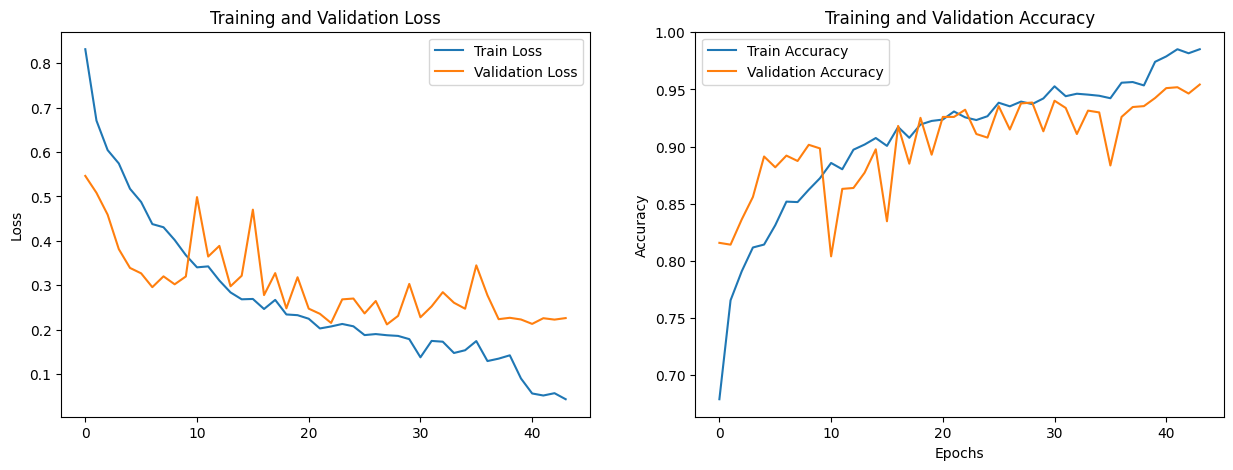

In [ ]:
plot_metrics(swin_transformer_v2_b[1])

100%|██████████| 40/40 [00:34<00:00,  1.16it/s]



Test Loss: 0.2502 Acc: 0.9433, Kappa: 0.8979
Testing complete in 0m 34s




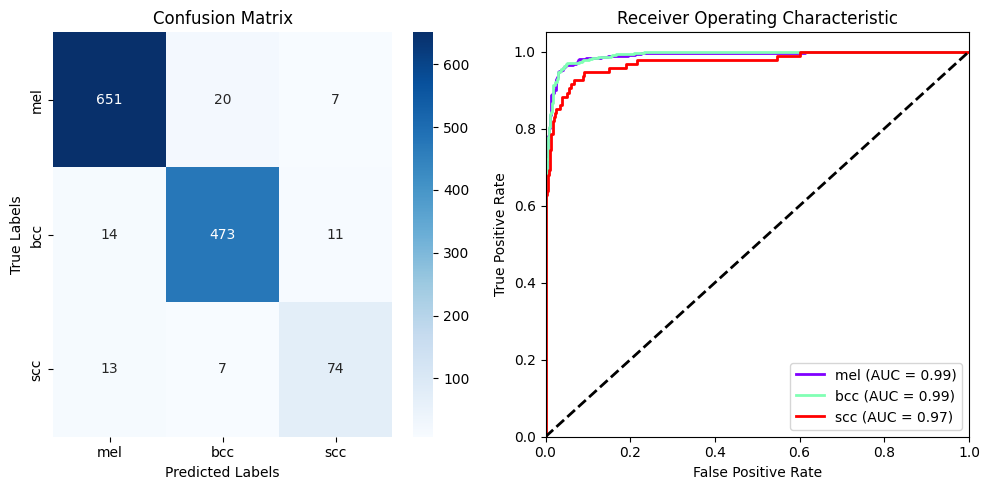

In [ ]:
from torchvision.models import swin_v2_b
from torchvision.models.swin_transformer import Swin_V2_B_Weights

# Define the Swin Transformer V2 Base Model Structure
swin_transformer_v2_b_model_predict = models.swin_v2_b(weights=None)

# Number of classes
num_classes = 3
# Modify the classifier layer
num_ftrs = swin_transformer_v2_b_model_predict.head.in_features
swin_transformer_v2_b_model_predict.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
swin_transformer_v2_b_model_predict = swin_transformer_v2_b_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/SwinTransformerV2B/swin_transformer_v2_b_wce_checkpoint_best.pth'
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Load the best model weights
swin_transformer_v2_b_model_predict.load_state_dict(torch.load(best_model_path))

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(swin_transformer_v2_b_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)



# Vision Transformer B 32

In [ ]:
from torchvision.models import vit_b_32
from torchvision.models.vision_transformer import ViT_B_32_Weights

# Your logging setup remains the same
logging.basicConfig(filename=TENSORBOARD_PATH + "/VisionTransformerVitB32/vit_b_32_wce.txt", level=logging.INFO,
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = TENSORBOARD_PATH

# Number of classes
num_classes = 3

# Load the pre-trained Vision Transformer ViT_B_32 model using torchvision
weights = ViT_B_32_Weights.DEFAULT
vit_b_32_model = vit_b_32(weights=weights)

# Modify the classifier layer
num_ftrs = vit_b_32_model.heads.head.in_features
vit_b_32_model.heads.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
vit_b_32_model = vit_b_32_model.to(DEVICE)

# The rest of your settings and hyperparameters remain the same
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15
EPOCHS = 100
WD = 1e-8

# Assuming FocalLoss and class_weights are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(vit_b_32_model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=0.1, mode="min")

# Assuming you have 'train_dataset' and 'val_dataset' defined somewhere
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

checkpoint_p = TENSORBOARD_PATH + '/VisionTransformerVitB32/vit_b_32_wce_checkpoint.pth'
vit_b_32 = train_model(vit_b_32_model, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path=writer_path)


Epoch 1/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.71it/s]

train loss : 0.9816, acc: 0.5844, kappa: 0.3010



100%|██████████| 40/40 [02:25<00:00,  3.65s/it]


val loss : 1.3962, acc: 0.1417, kappa: 0.0234

Epoch 2/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.66it/s]

train loss : 0.8917, acc: 0.6379, kappa: 0.3927



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.7040, acc: 0.7520, kappa: 0.5378



Epoch 3/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.61it/s]


train loss : 0.8454, acc: 0.6812, kappa: 0.4569


100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.8758, acc: 0.6630, kappa: 0.4130



Epoch 4/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.8309, acc: 0.6675, kappa: 0.4408



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.6065, acc: 0.7780, kappa: 0.5840



Epoch 5/100
---------------


100%|██████████| 318/318 [02:01<00:00,  2.63it/s]

train loss : 0.8259, acc: 0.6802, kappa: 0.4598



100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

val loss : 0.8029, acc: 0.5976, kappa: 0.3843



Epoch 6/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.8099, acc: 0.6863, kappa: 0.4726



100%|██████████| 40/40 [00:29<00:00,  1.37it/s]

val loss : 0.6849, acc: 0.7118, kappa: 0.5158



Epoch 7/100
---------------


100%|██████████| 318/318 [02:00<00:00,  2.64it/s]

train loss : 0.7912, acc: 0.7043, kappa: 0.4971



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.7449, acc: 0.6205, kappa: 0.4141



Epoch 8/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.7809, acc: 0.6936, kappa: 0.4856



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.6485, acc: 0.7433, kappa: 0.5539



Epoch 9/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.7687, acc: 0.6938, kappa: 0.4902



100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.6958, acc: 0.6520, kappa: 0.4480



Epoch 10/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.68it/s]

train loss : 0.7637, acc: 0.7027, kappa: 0.5029



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.6256, acc: 0.7591, kappa: 0.5503



Epoch 11/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.75it/s]

train loss : 0.7683, acc: 0.7046, kappa: 0.5037



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.6530, acc: 0.7331, kappa: 0.5379



Epoch 12/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.7528, acc: 0.7015, kappa: 0.5027



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.6230, acc: 0.7512, kappa: 0.5600



Epoch 13/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]


train loss : 0.7662, acc: 0.6991, kappa: 0.4955


100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.5747, acc: 0.7748, kappa: 0.5859



Epoch 14/100
---------------


100%|██████████| 318/318 [01:59<00:00,  2.67it/s]

train loss : 0.7542, acc: 0.7082, kappa: 0.5106



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5812, acc: 0.7535, kappa: 0.5709



Epoch 15/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.79it/s]


train loss : 0.7300, acc: 0.7170, kappa: 0.5260


100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.7213, acc: 0.6591, kappa: 0.4618



Epoch 16/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.7256, acc: 0.7141, kappa: 0.5235



100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

val loss : 0.5850, acc: 0.7677, kappa: 0.5893



Epoch 17/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.7203, acc: 0.7202, kappa: 0.5317



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5774, acc: 0.7622, kappa: 0.5734



Epoch 18/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.75it/s]

train loss : 0.7411, acc: 0.7080, kappa: 0.5130



100%|██████████| 40/40 [00:25<00:00,  1.55it/s]

val loss : 0.6235, acc: 0.7307, kappa: 0.5482



Epoch 19/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.7130, acc: 0.7174, kappa: 0.5277



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

val loss : 0.6563, acc: 0.7110, kappa: 0.5316



Epoch 20/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.7126, acc: 0.7216, kappa: 0.5349



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.6270, acc: 0.7417, kappa: 0.5551



Epoch 21/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]


train loss : 0.7053, acc: 0.7224, kappa: 0.5367


100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.5955, acc: 0.7528, kappa: 0.5763



Epoch 22/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.7247, acc: 0.7198, kappa: 0.5309



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.6488, acc: 0.7299, kappa: 0.5491



Epoch 23/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.6942, acc: 0.7377, kappa: 0.5589



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.6900, acc: 0.7102, kappa: 0.5260



Epoch 24/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.6889, acc: 0.7328, kappa: 0.5507



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.6601, acc: 0.7268, kappa: 0.5480



Epoch 25/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.83it/s]


train loss : 0.6562, acc: 0.7452, kappa: 0.5720


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5723, acc: 0.7496, kappa: 0.5757



Epoch 26/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.6252, acc: 0.7574, kappa: 0.5908



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5654, acc: 0.7606, kappa: 0.5929



Epoch 27/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.6078, acc: 0.7676, kappa: 0.6063



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5834, acc: 0.7362, kappa: 0.5620



Epoch 28/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.6126, acc: 0.7544, kappa: 0.5889



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5718, acc: 0.7465, kappa: 0.5748



Epoch 29/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.5901, acc: 0.7649, kappa: 0.6026



100%|██████████| 40/40 [00:25<00:00,  1.54it/s]

val loss : 0.6028, acc: 0.7331, kappa: 0.5601



Epoch 30/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.82it/s]

train loss : 0.6037, acc: 0.7568, kappa: 0.5914



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.5932, acc: 0.7362, kappa: 0.5655



Epoch 31/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.83it/s]


train loss : 0.5911, acc: 0.7652, kappa: 0.6061


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.5685, acc: 0.7535, kappa: 0.5905



Epoch 32/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.5830, acc: 0.7682, kappa: 0.6091



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5777, acc: 0.7425, kappa: 0.5752



Epoch 33/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.81it/s]

train loss : 0.5807, acc: 0.7672, kappa: 0.6086



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.5718, acc: 0.7457, kappa: 0.5790



Epoch 34/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.5877, acc: 0.7584, kappa: 0.5956



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5883, acc: 0.7370, kappa: 0.5684



Epoch 35/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.82it/s]

train loss : 0.5661, acc: 0.7731, kappa: 0.6181



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5402, acc: 0.7614, kappa: 0.5980



Epoch 36/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]


train loss : 0.5761, acc: 0.7757, kappa: 0.6202


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


val loss : 0.5547, acc: 0.7520, kappa: 0.5860

Epoch 37/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.5681, acc: 0.7733, kappa: 0.6200



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val loss : 0.5389, acc: 0.7598, kappa: 0.5952



Epoch 38/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.5746, acc: 0.7721, kappa: 0.6159



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5500, acc: 0.7512, kappa: 0.5875



Epoch 39/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.5737, acc: 0.7694, kappa: 0.6126



100%|██████████| 40/40 [00:25<00:00,  1.57it/s]

val loss : 0.5360, acc: 0.7772, kappa: 0.6258



Epoch 40/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.5721, acc: 0.7794, kappa: 0.6285



100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

val loss : 0.5434, acc: 0.7638, kappa: 0.6045



Epoch 41/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.79it/s]


train loss : 0.5622, acc: 0.7725, kappa: 0.6177


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5477, acc: 0.7598, kappa: 0.5963



Epoch 42/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.79it/s]

train loss : 0.5536, acc: 0.7820, kappa: 0.6321



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.5610, acc: 0.7512, kappa: 0.5835



Epoch 43/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.83it/s]

train loss : 0.5555, acc: 0.7796, kappa: 0.6289



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.5733, acc: 0.7504, kappa: 0.5889



Epoch 44/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]

train loss : 0.5561, acc: 0.7767, kappa: 0.6234



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5574, acc: 0.7606, kappa: 0.6035



Epoch 45/100
---------------


100%|██████████| 318/318 [01:52<00:00,  2.83it/s]

train loss : 0.5429, acc: 0.7879, kappa: 0.6404



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val loss : 0.5365, acc: 0.7606, kappa: 0.5983



Epoch 46/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.5390, acc: 0.7843, kappa: 0.6364



100%|██████████| 40/40 [00:26<00:00,  1.52it/s]

val loss : 0.5202, acc: 0.7866, kappa: 0.6374



Epoch 47/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.81it/s]


train loss : 0.5290, acc: 0.7845, kappa: 0.6365


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5144, acc: 0.7827, kappa: 0.6275



Epoch 48/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]


train loss : 0.5453, acc: 0.7810, kappa: 0.6297


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


val loss : 0.5522, acc: 0.7638, kappa: 0.6056

Epoch 49/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]


train loss : 0.5294, acc: 0.7922, kappa: 0.6477


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5504, acc: 0.7677, kappa: 0.6121



Epoch 50/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.5244, acc: 0.7841, kappa: 0.6362



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5266, acc: 0.7701, kappa: 0.6086



Epoch 51/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.74it/s]

train loss : 0.5272, acc: 0.7891, kappa: 0.6431



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.5529, acc: 0.7575, kappa: 0.5980



Epoch 52/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]


train loss : 0.5356, acc: 0.7871, kappa: 0.6405


100%|██████████| 40/40 [00:28<00:00,  1.39it/s]

val loss : 0.5311, acc: 0.7717, kappa: 0.6153



Epoch 53/100
---------------


100%|██████████| 318/318 [01:58<00:00,  2.69it/s]

train loss : 0.5142, acc: 0.7975, kappa: 0.6573



100%|██████████| 40/40 [00:26<00:00,  1.48it/s]

val loss : 0.5247, acc: 0.7717, kappa: 0.6114



Epoch 54/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.5083, acc: 0.7989, kappa: 0.6573



100%|██████████| 40/40 [00:28<00:00,  1.38it/s]

val loss : 0.5565, acc: 0.7591, kappa: 0.6010



Epoch 55/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.4986, acc: 0.7983, kappa: 0.6585



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5665, acc: 0.7606, kappa: 0.6022



Epoch 56/100
---------------


100%|██████████| 318/318 [01:56<00:00,  2.74it/s]

train loss : 0.5086, acc: 0.7965, kappa: 0.6548



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.5451, acc: 0.7677, kappa: 0.6103



Epoch 57/100
---------------


100%|██████████| 318/318 [01:57<00:00,  2.70it/s]

train loss : 0.5240, acc: 0.7938, kappa: 0.6509



100%|██████████| 40/40 [00:26<00:00,  1.48it/s]

val loss : 0.5364, acc: 0.7709, kappa: 0.6163



Epoch 58/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]


train loss : 0.4888, acc: 0.8032, kappa: 0.6669


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val loss : 0.5541, acc: 0.7504, kappa: 0.5859



Epoch 59/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.77it/s]

train loss : 0.4912, acc: 0.7922, kappa: 0.6511



100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.5273, acc: 0.7732, kappa: 0.6178



Epoch 60/100
---------------


100%|██████████| 318/318 [01:55<00:00,  2.75it/s]


train loss : 0.4986, acc: 0.7999, kappa: 0.6611


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

val loss : 0.5273, acc: 0.7764, kappa: 0.6233



Epoch 61/100
---------------


100%|██████████| 318/318 [01:54<00:00,  2.78it/s]

train loss : 0.4941, acc: 0.7981, kappa: 0.6577



100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

val loss : 0.5209, acc: 0.7811, kappa: 0.6299



Epoch 62/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]


train loss : 0.4984, acc: 0.8005, kappa: 0.6607


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


val loss : 0.5224, acc: 0.7764, kappa: 0.6230

Epoch 63/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train loss : 0.4937, acc: 0.8048, kappa: 0.6698



100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

val loss : 0.5214, acc: 0.7772, kappa: 0.6243


EARLY STOP AFTER 63 EPOCHS
Training complete in 159m 43s
Best val loss: 0.514418
Best val Kappa: 0.6374272579020779


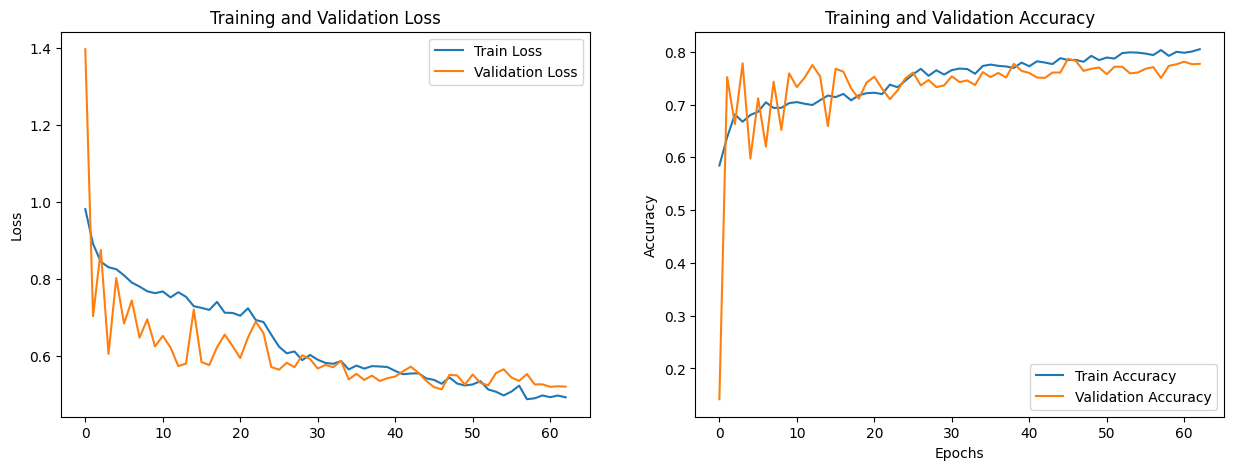

In [ ]:
plot_metrics(vit_b_32[1])

100%|██████████| 40/40 [00:30<00:00,  1.29it/s]



Test Loss: 0.5202 Acc: 0.7866, Kappa: 0.6374
Testing complete in 0m 31s




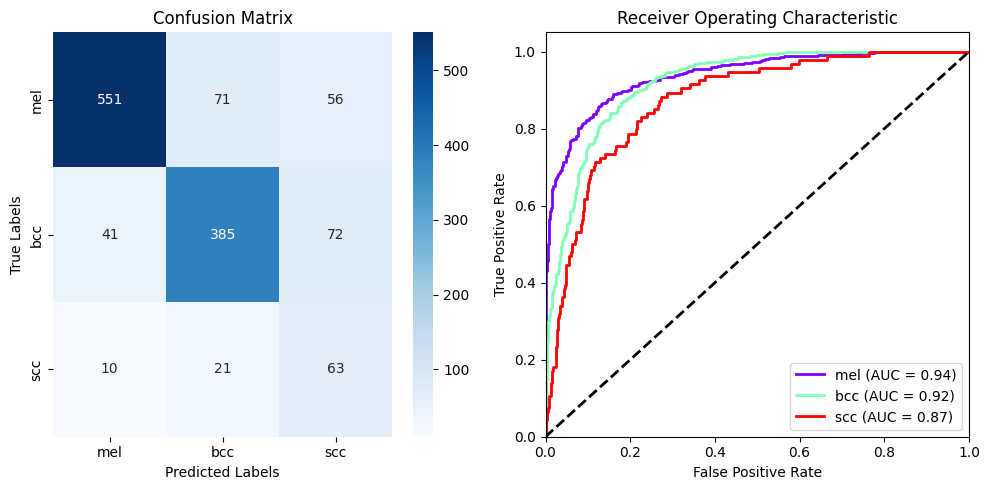

In [ ]:
from torchvision.models import vit_b_32
from torchvision.models.vision_transformer import ViT_B_32_Weights

# Define the Vision Transformer ViT_B_32 Model Structure
vit_b_32_model_predict = vit_b_32(weights=None)

# Number of classes
num_classes = 3

# Modify the classifier layer
num_ftrs = vit_b_32_model_predict.heads.head.in_features
vit_b_32_model_predict.heads.head = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
vit_b_32_model_predict = vit_b_32_model_predict.to(DEVICE)

best_model_path = TENSORBOARD_PATH + '/VisionTransformerVitB32/vit_b_32_wce_checkpoint_best.pth'
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Load the best model weights
vit_b_32_model_predict.load_state_dict(torch.load(best_model_path))

# Evaluate the model
val_loss, val_acc, val_kappa, true_labels, predicted_labels, predicted_probs = test_model(vit_b_32_model_predict, val_loader, DEVICE, criterion)

# Plot
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, np.array(predicted_probs), class_names=class_names)

# Ensembles

In [ ]:
def ensemble_predictions(data_loader, models):
    for model in models:
        model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, _ = data  # Unpack three elements, ignoring the third one
            inputs = inputs.to(DEVICE)
            outputs = [model(inputs) for model in models]

            # Averaging the predictions from all models
            avg_outputs = sum(outputs) / len(models)

            # Convert outputs to predicted class labels
            _, preds = torch.max(avg_outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_preds), np.concatenate(all_labels)


def plot_evaluation_metrics(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # ROC Curve
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.subplot(1, 2, 2)
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        label = class_names[i] if class_names else f'Class {i}'
        plt.plot(fpr[i], tpr[i], color=next(colors), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [ ]:

# Assuming the device and number of classes are defined
DEVICE = 'cuda'  # or 'cpu'
from torchvision import models  # Ensure this is not being overshadowed

# Load the pre-trained ResNeXt-50 model
best_resnext50_model = models.resnext50_32x4d(pretrained=False)

num_classes = 3  # Example number of classes

num_ftrs_resnext50 = best_resnext50_model.fc.in_features
best_resnext50_model.fc = nn.Linear(num_ftrs_resnext50, num_classes)
best_resnext50_model.to(DEVICE)
best_resnext50_model_path = TENSORBOARD_PATH + '/ResNext50/resnext50_wce_checkpoint_best.pth'
best_resnext50_model.load_state_dict(torch.load(best_resnext50_model_path, map_location=DEVICE))

print('ResNext50 model has been uploaded!')


# Define the RegNet Y 32 GF Model Structure
best_regnet_y_32gf_model = regnet_y_32gf(weights=None)
num_ftrs_regnet_y_32gf = best_regnet_y_32gf_model.fc.in_features
best_regnet_y_32gf_model.fc = nn.Linear(num_ftrs_regnet_y_32gf, num_classes)
best_regnet_y_32gf_model.to(DEVICE)
best_regnet_y_32gf_model_path = TENSORBOARD_PATH + '/RegNetY23GF/regnet_y23gf_wce_checkpoint_best.pth'
best_regnet_y_32gf_model.load_state_dict(torch.load(best_regnet_y_32gf_model_path, map_location=DEVICE))

print('RegNet Y 32 GF model has been uploaded!')

best_densenet121_model = models.densenet121(weights=None)
num_ftrs_densenet121 = best_densenet121_model.classifier.in_features
best_densenet121_model.classifier = nn.Linear(num_ftrs_densenet121, num_classes)
best_densenet121_model_path = TENSORBOARD_PATH + '/DenseNet121/densenet121_wce_checkpoint_best.pth'
best_densenet121_model.load_state_dict(torch.load(best_densenet121_model_path, map_location=DEVICE))
best_densenet121_model.to(DEVICE)
print('DenseNet121 model has been uploaded!')

best_efficientnet_b2_model = efficientnet_b2(weights=None)
num_ftrs_efficientnet_b2 = best_efficientnet_b2_model.classifier[1].in_features
best_efficientnet_b2_model.classifier[1] = nn.Linear(num_ftrs_efficientnet_b2, num_classes)
best_efficientnet_b2_model_path = TENSORBOARD_PATH + '/EfficientNetB2/efficientnetb2_wce_checkpoint_best.pth'
best_efficientnet_b2_model.load_state_dict(torch.load(best_efficientnet_b2_model_path, map_location=DEVICE))
best_efficientnet_b2_model.to(DEVICE)
print('EfficientNet B2 model has been uploaded!')


best_efficientnet_b4_model = efficientnet_b4(weights=None)
num_classes = 3
num_ftrs_efficientnet_b4 = best_efficientnet_b4_model.classifier[1].in_features
best_efficientnet_b4_model.classifier[1] = nn.Linear(num_ftrs_efficientnet_b4, num_classes)
best_efficientnet_b4_model_path = TENSORBOARD_PATH + '/EfficientNetB4/efficientnetb4_wce_checkpoint_best.pth'
best_efficientnet_b4_model.load_state_dict(torch.load(best_efficientnet_b4_model_path, map_location=DEVICE))
best_efficientnet_b4_model.to(DEVICE)
print('EfficientNet B4 model has been uploaded!')

best_swin_t_model = swin_t(weights=None)
num_classes = 3
num_ftrs_swin_t = best_swin_t_model.head.in_features
best_swin_t_model.head = nn.Linear(num_ftrs_swin_t, num_classes)
best_swin_t_model_path = TENSORBOARD_PATH + '/SwinTransformerT/swin_transformer_t_wce_checkpoint_best.pth'
best_swin_t_model.load_state_dict(torch.load(best_swin_t_model_path, map_location=DEVICE))
best_swin_t_model.to(DEVICE)
print('Swin Transformer T model has been uploaded!')


best_swin_s_model = swin_s(weights=None)
num_ftrs_swin_s = best_swin_s_model.head.in_features
best_swin_s_model.head = nn.Linear(num_ftrs_swin_s, num_classes)
best_swin_s_model_path = TENSORBOARD_PATH + '/SwinTransformerS/swin_transformer_s_wce_checkpoint_best.pth'
best_swin_s_model.load_state_dict(torch.load(best_swin_s_model_path, map_location=DEVICE))
best_swin_s_model.to(DEVICE)
print('Swin Transformer S model has been uploaded!')


best_swin_b_model = swin_b(weights=None)
num_ftrs_swin_b = best_swin_b_model.head.in_features
best_swin_b_model.head = nn.Linear(num_ftrs_swin_b, num_classes)
best_swin_b_model_path = TENSORBOARD_PATH + '/SwinTransformerB/swin_transformer_b_wce_checkpoint_best.pth'
best_swin_b_model.load_state_dict(torch.load(best_swin_b_model_path, map_location=DEVICE))
best_swin_b_model.to(DEVICE)
print('Swin Transformer B model has been uploaded!')


best_swin_v2_s_model = swin_v2_s(weights=None)
num_ftrs_swin_v2_s = best_swin_v2_s_model.head.in_features
best_swin_v2_s_model.head = nn.Linear(num_ftrs_swin_v2_s, num_classes)
best_swin_v2_s_model_path = TENSORBOARD_PATH + '/SwinTransformerV2S/swin_transformer_v2_s_wce_checkpoint_best.pth'
best_swin_v2_s_model.load_state_dict(torch.load(best_swin_v2_s_model_path, map_location=DEVICE))
best_swin_v2_s_model.to(DEVICE)
print('Swin Transformer V2 S model has been uploaded!')


from torchvision.models import swin_v2_b

# Number of classes for your task
num_classes = 3
best_swin_v2_b_model = swin_v2_b(weights=None)
num_ftrs_swin_v2_b = best_swin_v2_b_model.head.in_features
best_swin_v2_b_model.head = nn.Linear(num_ftrs_swin_v2_b, num_classes)
best_swin_v2_b_model_path = TENSORBOARD_PATH + '/SwinTransformerV2B/swin_transformer_v2_b_wce_checkpoint_best.pth'
best_swin_v2_b_model.load_state_dict(torch.load(best_swin_v2_b_model_path, map_location=DEVICE))
best_swin_v2_b_model.to(DEVICE)

print('Swin Transformer V2 B model has been uploaded!')


from torchvision.models import vit_b_32
from torch import nn

# Number of classes for your task
num_classes = 3

best_vit_b_32_model = vit_b_32(weights=None)
num_ftrs_vit_b_32 = best_vit_b_32_model.heads.head.in_features
best_vit_b_32_model.heads.head = nn.Linear(num_ftrs_vit_b_32, num_classes)
best_vit_b_32_model.to(DEVICE)
best_vit_b_32_model_path = TENSORBOARD_PATH + '/VisionTransformerVitB32/vit_b_32_wce_checkpoint_best.pth'
best_vit_b_32_model.load_state_dict(torch.load(best_vit_b_32_model_path, map_location=DEVICE))
print('Vision Transformer B 32 model has been uploaded!')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNext50 model has been uploaded!
RegNet Y 32 GF model has been uploaded!
DenseNet121 model has been uploaded!
EfficientNet B2 model has been uploaded!
EfficientNet B4 model has been uploaded!
Swin Transformer T model has been uploaded!
Swin Transformer S model has been uploaded!
Swin Transformer B model has been uploaded!
Swin Transformer V2 S model has been uploaded!
Swin Transformer V2 B model has been uploaded!
Vision Transformer B 32 model has been uploaded!


### Swin Transformer B2 + Swin Transformer v2 B

In [ ]:
# List of models
models = [best_swin_b_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


Accuracy: 0.9598425196850394
Cohen's Kappa Score: 0.9277820147446447


### Swin Transformer B + Swin Transformer v2 S + Swin Transformer v2 B

In [ ]:
# List of models
models = [best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


Accuracy: 0.9661417322834646
Cohen's Kappa Score: 0.9391103261572494


### ResNext 50 + Swin Transformer B + Swin Transformer v2 S + Swin Transformer v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


Accuracy: 0.9669291338582677
Cohen's Kappa Score: 0.9405382989539022


### ResNext 50 + Swin Transformer S + Swin Transformer B + Swin Transformer v2 S + Swin Transformer v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


Accuracy: 0.9677165354330709
Cohen's Kappa Score: 0.9418871984428849


### ResNext 50 + DenseNet 121 + Swin Transformer S + Swin Transformer B + Swin Transformer v2 S + Swin Transformer v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_densenet121_model, best_efficientnet_b2_model ,best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


Accuracy: 0.9669291338582677
Cohen's Kappa Score: 0.9405324652158402


# ResNext 50 + DenseNet 121 + Swin T + Swin S + Swin B + Swin v2 S + Swin v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_densenet121_model, best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")

Accuracy: 0.9677165354330709
Cohen's Kappa Score: 0.941983286908078


# ResNet 50 + DenseNet 121 + EfficientNet B2 + EfficientNet B4 + Swin T + Swin S + Swin B + Swin v2 S + Swin v2 B

Accuracy: 0.9692913385826771
Cohen's Kappa Score: 0.9448050066639624




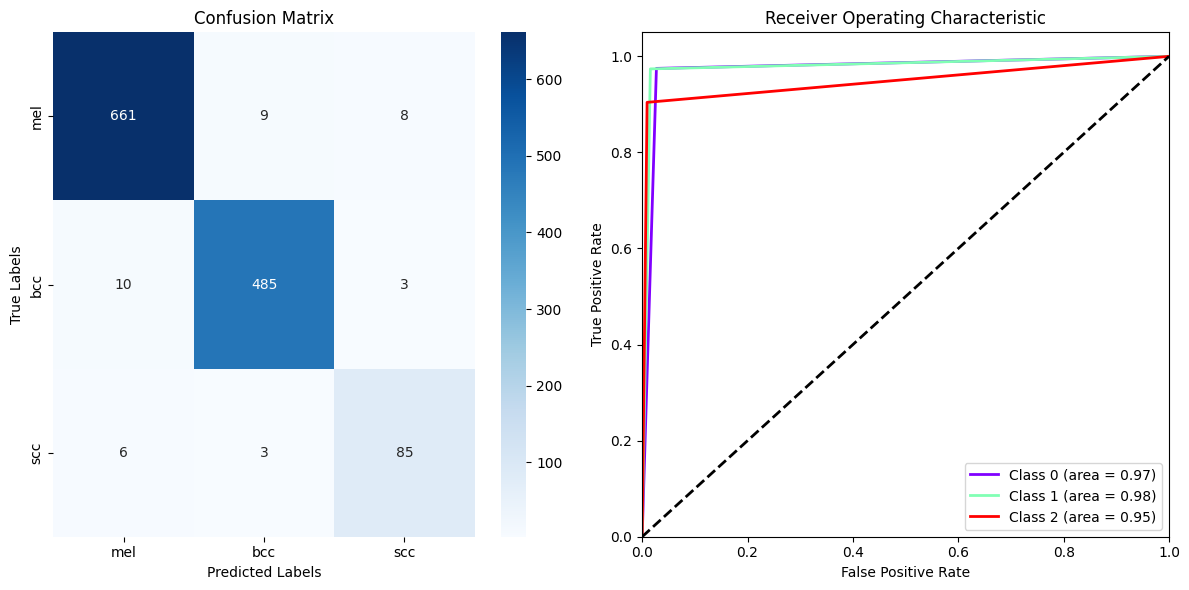

In [ ]:
# List of models
models = [best_resnext50_model, best_densenet121_model, best_efficientnet_b2_model, best_efficientnet_b4_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")

print('\n')
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, predicted_labels, class_names=class_names)


# ResNet 50 + DenseNet 121 + RegNet Y32 GF + EfficientNet B2 + EfficientNet B4 + Swin T + Swin S + Swin B + Swin v2 S + Swin v2 B

Accuracy: 0.968503937007874
Cohen's Kappa Score: 0.9434492401269943




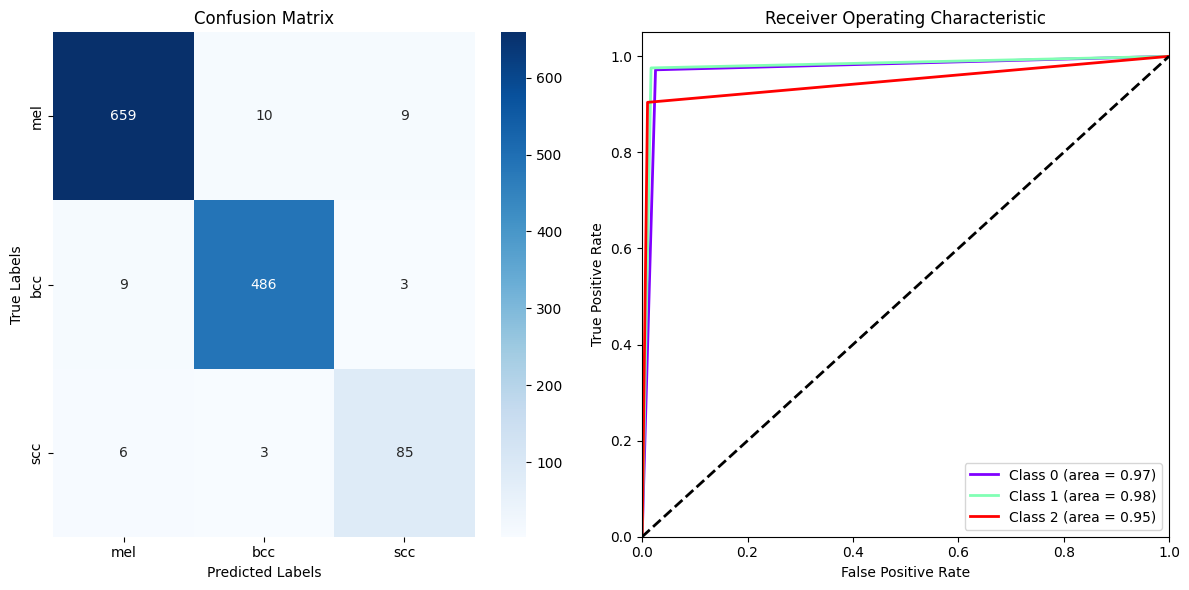

In [ ]:
# List of models
models = [best_resnext50_model, best_densenet121_model,best_regnet_y_32gf_model, best_efficientnet_b2_model, best_efficientnet_b4_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


print('\n')
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, predicted_labels, class_names=class_names)

# ResNet 50 + RegNet Y32 GF + EfficientNet B4 + Swin T + Swin S + Swin B + Swin v2 S + Swin v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_regnet_y_32gf_model, best_efficientnet_b4_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")


print('\n')
class_names = ["mel", "bcc", "scc"]  # Replace with your actual class names
plot_evaluation_metrics(true_labels, predicted_labels, class_names=class_names)

Accuracy: 0.9692913385826771
Cohen's Kappa Score: 0.9447663526389037


# ResNet 50 + EfficientNet B2 + EfficientNet B4 + Swin T + Swin B + Swin B + Swin v2 S + Swin v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_efficientnet_b2_model, best_efficientnet_b4_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")

Accuracy: 0.9692913385826771
Cohen's Kappa Score: 0.9447939330170846


# ResNet 50 +  DenseNet121 + EfficientNet B2 + Swin T + Swin B + Swin B + Swin v2 S + Swin v2 B

In [ ]:
# List of models
models = [best_resnext50_model, best_densenet121_model, best_efficientnet_b2_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]

# Assuming you have a DataLoader for your test data
 # Your test data loader here
predicted_labels, true_labels = ensemble_predictions(val_loader, models)

# Calculate Accuracy and Cohen's Kappa Score
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Cohen's Kappa Score: {kappa}")

Accuracy: 0.968503937007874
Cohen's Kappa Score: 0.9434492401269943


# Prediction Test Data with Best Model


In [ ]:
import os

def ensemble_prediction_test(data_loader, models):
    for model in models:
        model.eval()

    all_preds = []
    all_file_names = []

    with torch.no_grad():
        for inputs, file_paths in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = [model(inputs) for model in models]

            # Averaging the predictions from all models
            avg_outputs = sum(outputs) / len(models)

            # Convert outputs to predicted class labels
            _, preds = torch.max(avg_outputs, 1)

            # Only store the filename without the path
            filenames = [os.path.splitext(os.path.basename(file_path))[0] for file_path in file_paths]
            all_preds.extend(preds.cpu().numpy())
            all_file_names.extend(filenames)

    # Sort the results by filename
    sorted_file_names, sorted_preds = zip(*sorted(zip(all_file_names, all_preds), key=lambda x: x[0]))

    return sorted_file_names, sorted_preds


In [ ]:
models = [best_resnext50_model, best_densenet121_model, best_efficientnet_b2_model, best_efficientnet_b4_model ,best_swin_t_model, best_swin_s_model, best_swin_b_model, best_swin_v2_s_model, best_swin_v2_b_model]


file_names, predicted_labels = ensemble_prediction_test(test_loader, models)

predictions_df = pd.DataFrame({
    'FileName': file_names,
    'PredictedLabel': predicted_labels
})
predictions_df.to_csv('test_predictions_final.csv', index=False)
